**Please don't edit this cell!**

# Marks and Feedback

**Total Marks:**   XX/100

**Overall comments:**


## Part 1. Investigations into Neural Networks (35 marks)

* **Task 1**:   *Experiments with learning rate schedules* - XX/5
    * learning rate schedulers implemented
    * experiments carried out
    * further comments


* **Task 2**:   *Experiments with regularisation* - XX/5
    * L1 experiments
    * L2 experiments
    * dropout experiments
    * annealed dropout implmented
    * further experiments carried out
    * further comments
    

* **Task 3**:   *Experiments with pretraining* - XX/15
    * autoencoder pretraining implemented
    * denoising autoencoder pretraining implemented
    * CE layer-by-layer pretraining implemented
    * experiments
    * further comments


* **Task 4**:   *Experiments with data augmentation* - XX/5
    * training data augmneted using noise, rotation, ...
    * any further augmnetations
    * experiments 
    * further comments


* **Task 5**:   *State of the art* - XX/5
    * motivation for systems constructed
    * experiments
    * accuracy of best system
    * further comments



## Part 2. Convolutional Neural Networks (55 marks)

* **Task 6**:   *Implement convolutional layer* - XX/20
    * linear conv layer
    * sigmoid conv layer
    * relu conv layer
    * any checks for correctness
    * loop-based or vectorised implementations
    * timing comparisons


* **Task 7**:   *Implement maxpooling layer* - XX/10
    * implementation of non-overlapping pooling
    * generic implementation
    * any checks for correctness


* **Task 8**:   *Experiments with convolutional networks* - XX/25
    * 1 conv layer (1 fmap)
    * 1 conv layer (5 fmaps)
    * 2 conv layers
    * further experiments



## Presentation (10 marks)

* ** Marks:**   XX/10
    * Concise description of each system constructed
    * Experiment design and motivations for different systems
    * Presentation of results - graphs, tables, diagrams
    * Conclusions



# Coursework #2

## Introduction


## Previous Tutorials

Before starting this coursework make sure that you have completed the following labs:

* [04_Regularisation.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/04_Regularisation.ipynb) - regularising the model
* [05_Transfer_functions.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/05_Transfer_functions.ipynb) - building and training different activation functions
* [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb) - Notes on numpy and tensors


## Submission
**Submission Deadline:  Thursday 14 January 2016, 16:00** 

Submit the coursework as an ipython notebook file, using the `submit` command in the terminal on a DICE machine. If your file is `06_MLP_Coursework1.ipynb` then you would enter:

`submit mlp 2 06_MLP_Coursework1.ipynb` 

where `mlp 2` indicates this is the second coursework of MLP.

After submitting, you should receive an email of acknowledgment from the system confirming that your submission has been received successfully. Keep the email as evidence of your coursework submission.

**Please make sure you submit a single `ipynb` file (and nothing else)!**

**Submission Deadline:  Thursday 14 January 2016, 16:00** 



## Getting Started
Please enter your student number and the date in the next code cell.

In [ ]:
#MLP Coursework 2
#Student number: s1569105
#Exam Number: B076165
#Ruslan Burakov
#Date: 14.01.2016

## GENERAL NOTE!

I put many of my comments in the markdown cells. Sorry for all grammatical mistakes I have made!

I am using doctests module to test most of my code (especially functions). I develop the core elements in PyCharm and there doctests are extremely useful and easy to work with. It is like your debug session which is always with you. 
The doctests are performed in function or class descriptions started on lines with >>> and after that you must put correct output on the next line. 

I rely on doctests heavily especially in Convolution part, where there are a lot functions which do numpy array manipulation. That is why, please, account doctests as additional tests.

Here is example of function with 4 doctest. Note the output error that occured in the last test.


In [41]:
# %load doc_test_disclaimer.py
import doctest

def dummy_backprop(igrad):
    """

    :param igrad: input gradients
    :return: output gradients usage doctest

    Usage/Doctest:
    >>> dummy_backprop([5])
    Too much work!
    >>> dummy_backprop([2, 2])
    Too much work!
    >>> dummy_backprop([])
    Nothing to work with
    >>> dummy_backprop(45)
    This is is wrong output
    """
    if not isinstance(igrad, list) or len(igrad) == 0:
        print "Nothing to work with"
    elif len(igrad) > 0:
        print "Too much work!"

if __name__ == "__main__":
    doctest.testmod()


**********************************************************************
File "__main__", line 17, in __main__.dummy_backprop
Failed example:
    dummy_backprop(45)
Expected:
    This is is wrong output
Got:
    Nothing to work with
**********************************************************************
1 items had failures:
   1 of   4 in __main__.dummy_backprop
***Test Failed*** 1 failures.


Here I load some general usefull code

In [2]:
import numpy
import logging
from mlp.dataset import MNISTDataProvider

rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()

logger = logging.getLogger()
logger.setLevel(logging.INFO)



In [ ]:
#preload data
logger.info("Data Preloading")
train_dp_flat = train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp_flat = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-10, randomize=False)
test_dp_flat = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False)
logger.info("Data Preloading is over")

In [3]:
%matplotlib inline
# %load support.py
#support functions

import numpy
import logging
import cPickle
from mlp.costs import CECost
from mlp.layers import MLP, Softmax, Sigmoid
import matplotlib.pyplot as plt

from mlp.optimisers import SGDOptimiser, Optimiser#import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider #Ruslan Burakov - s1569105
from mlp.schedulers import LearningRateFixed

def count_num_hidden_units(n_in_uts, n_out_uts, n_total_whts, n_hlrs):
    a = float(n_hlrs - 1)
    b = float(n_in_uts + n_out_uts + n_hlrs)
    c = float(n_out_uts - n_total_whts)
    answer = None
    if n_hlrs == 1:
        return int(-c/b)

    opd = (b * b - 4 * a * c)**0.5
    #only x1 because min_point = -b/2a and b/a always > 0 so always min_point < 0
    x1 = (-b + opd) / (2 * a)
    return x1

def count_total_num_weights(n_in_uts, n_out_uts, n_whts_per_hlrs, n_hlrs):
    a = float(n_hlrs - 1)
    b = float(n_in_uts + n_out_uts + n_hlrs)
    c = float(n_out_uts)
    return  n_whts_per_hlrs * n_whts_per_hlrs * a + n_whts_per_hlrs * b + c

def create_one_hid_model():
    """
    In CW1 with default parameters (learning rate was 0.5) this
    model achieved 97.5% accuracy and it takes only 3 seconds per epoch.
    That is why I think it will suit as petri dish for many tasks.
    """
    cost = CECost()
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=100, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    return model

def create_many_hid_models(n_hlrs,
                           total_weights,
                           layer_fun = lambda idim, odim, rng: Sigmoid(idim=idim, odim=odim, rng=rng)):
    n_whts_per_hlrs = int(count_num_hidden_units(784, 10, total_weights, n_hlrs))
    cost = CECost()
    model = MLP(cost=cost)
    model.add_layer(layer_fun(idim=784, odim=n_whts_per_hlrs, rng=rng))
    for hlr in range(1, n_hlrs):
        model.add_layer(Sigmoid(idim=n_whts_per_hlrs, odim=n_whts_per_hlrs, rng=rng))
    model.add_layer(Softmax(idim=n_whts_per_hlrs, odim=10, rng=rng))
    return model

#test the model against training set
def test_model(model, label="no_name", test_dp=test_dp_flat):
    logger.info('Testing the model {0} on test set:'.format(label))
    test_dp_flat.reset()
    optimiser = Optimiser()
    cost, accuracy = optimiser.validate(model, test_dp)
    logger.info('MNIST test set accuracy is %.2f %% (cost is %.3f)'%(accuracy * 100., cost))
    return cost, accuracy
    
def learn(**kwargs):
    #to not interrupt other tasks
    try:
        if "model" not in kwargs:
            logger.info("Don't found a model. Return [(0, 0)], [(0, 0)]")
            print "Don't found a model. Return [(0, 0)], [(0, 0)]"
            return [(0, 0)], [(0, 0)]
        #default parameters
        model = kwargs["model"]
        label = kwargs["label"] if "label" in kwargs else "no_name"
        max_epochs = kwargs["max_epochs"] if "max_epochs" in kwargs else 30
        lr_rate = kwargs["lr_rate"] if "lr_rate" in kwargs  else 0.1
        lr_scheduler = kwargs["lr_scheduler"] if "lr_scheduler" in kwargs else LearningRateFixed(lr_rate, max_epochs)
        optimiser = kwargs["optimiser"] if "optimiser" in kwargs else None
        valid_dp = kwargs["valid_dp"] if "valid_dp" in kwargs else valid_dp_flat
        train_dp = kwargs["train_dp"] if "train_dp" in kwargs else train_dp_flat
        save = kwargs["save"] if "save" in kwargs else False

        if optimiser is None:
            optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        logger.info('Reinitialising data providers..')
        #randomize
        valid_dp.reset()
        train_dp.reset()
        logger.info('Training started {0} ..'.format(label))

        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        if save:
            print "saving data for " + label
            logger.info("saving data for " + label)
            #saving for future use
            with open(label + '_model.pkl','wb') as f:
                cPickle.dump(model, f)
            with open(label + '_train_stats.pkl','wb') as f:
                    cPickle.dump(tr_stats, f)
            with open(label + '_valid_stats.pkl','wb') as f:
                cPickle.dump(valid_stats, f)

        logger.info('returning result')
        #training, validation sets stats
        return tr_stats, valid_stats

    except Exception as e:
        print str(e)
        logger.info(str(e))
        logger.info("Return [(0, 0)], [(0, 0)]")
        print "Return [(0, 0)], [(0, 0)]"
        return [(0, 0)], [(0, 0)]

#(in order not to recalculate it each time we make changes in plot functions)
def get_models_statistics(tasks):
    #num_models x 2 {train, validation} x epoches x 2 {error_cost, accuracy}
    return numpy.array([learn(**task) for task in tasks])

#all of them return #-> num_models x epoches
def get_train_accuracies(models_statistics):
    return models_statistics[:, 0, :, 1]

def get_train_error_costs(models_statistics):
    return models_statistics[:, 0, :, 0]

def get_valid_accuracies(models_statistics):
    return models_statistics[:, 1, :, 1]

def get_valid_error_costs(models_statistics):
    return models_statistics[:, 1, :, 0]



def plot_epoch_dynamic(values_list, labels, y_label, loc = 1):
    lines = []
    for label, values in zip(labels, values_list):
        line, = plt.plot(values, label=label)
        lines.append(line)

    num_epoches = len(values_list[0])
    plt.xlabel("epoch")
    plt.xticks(range(0, num_epoches, 2))
    plt.ylabel(y_label)
    plt.legend(lines, loc=loc)

def plot_error_rate(tr_accrs, vd_accrs, labels, figsize=(12,12)):
    plt.figure(1, figsize=figsize)
    plot_epoch_dynamic([(1 - ta) * 100 for ta in tr_accrs], labels, "training error rate")
    plt.figure(2, figsize=figsize)
    plot_epoch_dynamic([(1 - va) * 100 for va in vd_accrs], labels, "validation error rate")
    plt.show()

def print_test_error_rate(test_accrs, learning_rates, padding=33):
    row_format =("{:<" + str(padding) + "}") * 2
    header = row_format.format("model", "error rate")
    table = "\n".join([ row_format.format(lr, (1 - test_accr) * 100)\
                       for lr, test_accr in zip(learning_rates, test_accrs)])
    print header
    print table



Support drawing routines

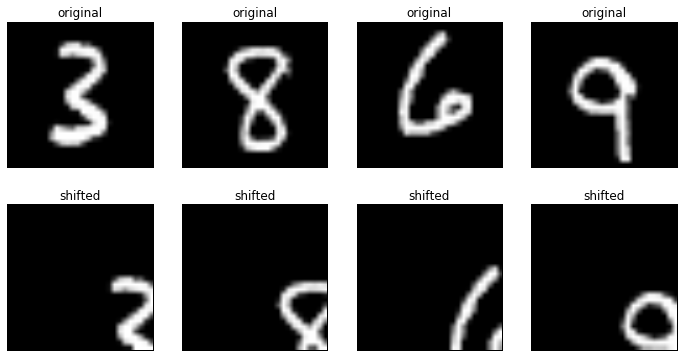

In [4]:
# %load noise_tries
%matplotlib inline
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from mlp.dataset import MNISTDataProvider

def show_mnist_image(img):
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(img, cmap=cm.Greys_r)
    plt.show()

def show_mnist_images(imgs, imgs_per_line, img_size, labels=None):
    n = imgs.shape[0]
    form = (imgs_per_line, n/imgs_per_line + (n%imgs_per_line != 0))
    fig = plt.figure(figsize=(form[0] * img_size, form[1] * img_size))
    gs = gridspec.GridSpec(form[1], form[0])

    for img_id, img in enumerate(imgs):
        row_id, column_id = img_id / form[0], img_id % form[0]
        a = 5
        ax = fig.add_subplot(gs[row_id, column_id])
        #remove clumsy numbers on both axis
        if labels is not None:
            ax.set_title(labels[img_id])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #convert from mnist image format
        ax.imshow(img, cmap=cm.Greys_r)
    plt.show()
    
def test_show_mnist_images():
    mnist_dp = MNISTDataProvider(dset='valid', batch_size=4, max_num_examples=4, randomize=False)
    for batch in mnist_dp:
        features, targets = batch
        num_imgs = features.shape[0]
        imgs = features.reshape(num_imgs, 28, 28)

        shf_img = ndimage.interpolation.shift(imgs, shift=(0, 10, 10))
        tot_imgs = np.concatenate((imgs, shf_img), axis=0)
        show_mnist_images(tot_imgs, 4, 3, ["original"] * 4 + ["shifted"] * 4)
        
test_show_mnist_images()        
    #show_mnist_image(shf_img)

Weights drawing

In [5]:
def show_weight(weight, shape, image_shape, drawer = None):
    def default_drawer(matrix, axar):
        #remove ticks, axes, labels - otherwise too cluttered
        axar.axis('off')
        axar.imshow(matrix, cmap=cm.Greys_r)
    
    drawer = default_drawer if drawer is None else drawer
        
    fig = plt.figure(figsize=(2, 2)) 
    fif, axarr = plt.subplots(*shape, figsize=(15,15))
    axarr_iter = axarr.reshape(shape[0] * shape[1])
    for k, axar in enumerate(axarr_iter):
        drawer(weight[k].reshape(*image_shape), axar)
    plt.show()
#example usage 
#show_weight(model_3c.layers[0].W.T, (10, 10), (28, 28))

In [ ]:
Cost function

In [6]:
def plot_error_cost(error_costs, labels, name, figsize=(12,12)):    
    for label, error_cost in zip(labels, error_costs):
        plt.figure(figsize=figsize)
        plot_epoch_dynamic([error_cost], [label], name, loc = 1)

# Part 1. Investigations into Neural Networks (35 marks)

In this part you are may choose exactly what you implement. However, you are expected to express your motivations, observations, and findings in a clear and cohesive way. Try to make it clear why you decided to do certain things. Use graphs and/or tables of results to show trends and other characteristics you think are important. 

For example, in Task 1 you could experiment with different schedulers in order to compare their convergence properties. In Task 2 you could look into (and visualise) what happens to weights when applying L1 and/or L2 regularisation when training. For instance, you could create sorted histograms of weight magnitudes in in each layer, etc..

**Before submission, please collapse all the log entries into smaller boxes (by clicking on the bar on the left hand side)**

### Task 1 - Experiments with learning rate schedules (5 marks)

Investigate the effect of learning rate schedules on training and accuracy.  Implement at least one additional learning rate scheduler mentioned in the lectures. 

### general note for part 1.
In the previous coursework we thoroughly studied model with one hidden sigmoid layer with 100 units. That is why for most of the part 1, I use this model (created via create_one_hid_model function) as its optimal learning rates are already known for it and its standard behaviour is known. I understand that it would be interesting to try other functions such as Relu or Tanh but for each of them I have to at least find optimal learning rates all over again, and each time I try to find other optimal parameters, I have to do for each kind of layer all over again. There is no just enough CPU for that.

Implemented schedular classes

In [ ]:
# %load -s LearningRateExponential mlp/schedulers.py
class LearningRateExponential(LearningRateList):
    def __init__(self, initial_learning_rate, max_epochs, r):
        assert initial_learning_rate > 0, (
            "initial learning rate expected to be > 0, got %f" % initial_learning_rate
        )
        assert r > 0, (
            "r expected to be > 0, got %f" % r
        )

        import numpy as np
        tt = np.arange(0, max_epochs)
        yy = initial_learning_rate * np.exp(-tt / r)
        super(LearningRateExponential, self).__init__(list(yy), max_epochs)


In [ ]:
# %load -s LearningRateReciprocal mlp/schedulers.py
class LearningRateReciprocal(LearningRateList):
    def __init__(self, initial_learning_rate, max_epochs, r, c):
        assert initial_learning_rate > 0, (
            "initial learning rate expected to be > 0, got %f" % initial_learning_rate
        )
        assert r > 0, (
            "r to be > 0, got %f" % r
        )
        assert c >= 0, (
            "c expected to be > 0, got %f" % c
        )
        import numpy as np
        tt = np.arange(0, max_epochs)
        yy = initial_learning_rate * (1 + tt / r) ** (-c)
        super(LearningRateReciprocal, self).__init__(list(yy), max_epochs)


In [2]:
# %load plot_schedulers_fun_dynamic
import numpy as np
import matplotlib.pyplot as plt
from mlp.schedulers import LearningRateExponential
from mlp.schedulers import LearningRateReciprocal

def get_xx_yy(sch):
    epoches, values = [],[]
    while sch.get_rate() != 0:
        epoches.append(sch.epoch)
        values.append(sch.get_rate())
        sch.get_next_rate(None)
    return epoches, values

def reciprocal(lr0, max_epoch, r, cc):
    lines = []
    for c in cc:
        xx, yy = get_xx_yy(LearningRateReciprocal(lr0, max_epoch, r, c))
        line, = plt.plot(xx, yy, label="reciprocal with r {}, c {}".format(r, c))
        lines.append(line)
    return lines

def exponential(lr0, max_epoch, r):
    xx, yy = get_xx_yy(LearningRateExponential(lr0, max_epoch, r))
    line, = plt.plot(xx, yy, label="exponential with r {}".format(r))
    return [line]

def default_run():
    initial_learning_rate = 0.7
    epoches = 30
    #proportional to overall batch size
    r = 0.0001 * 50000
    cc =[0.5, 1.0, 2]
    lines = []
    plt.figure(0, figsize=(10,10))
    lines += reciprocal(initial_learning_rate, epoches, r, cc)
    lines += exponential(initial_learning_rate, epoches, r)
    plt.legend(lines, loc=1)
    plt.xlabel("epoch")
    plt.ylabel("learning rate")
    plt.show()



In the previous course work the best accuracy values (above > 90%) was reached
by using learning rate = 0.5. So it logical to desire high values
of learning rate at the beginning (let's say first 10 epoch) and
then use small values for final tunning

Due to the following plot I choose parameters that
results in high learning rates at the beginning and low one at the end
and I test my implementation of LearningRateExponential and LearningRateReciprocal, as well.

This is what I have found.
    

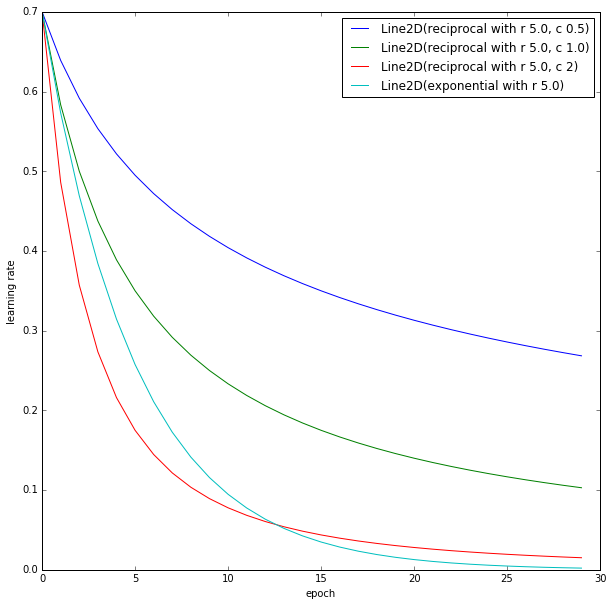

In [3]:
%matplotlib inline
default_run()

Judging by the plot the best result should be achived via exponential with r 5.0
and reciprocal with r 5.0 and c 2.0. 
But that is in theory. Let see them on practice.

In [97]:
# %load tsk1_1.py
#data computaton
from mlp.schedulers import LearningRateExponential, LearningRateReciprocal, LearningRateFixed

schd_tasks  = [
    {
    "model": create_one_hid_model(),
    "label": "Normal Fixed LR lr0=0.7",
    "lr_scheduler": LearningRateFixed(0.7, 50)
    },
    {
    "model": create_one_hid_model(),
    "label": "Exponential r=5 lr0=0.7",
    "lr_scheduler": LearningRateExponential(0.7, 50, 5.0)
    },
    {
    "model": create_one_hid_model(),
    "label": "Reciprocal r=5 lr0=0.7 c=0.5",
    "lr_scheduler": LearningRateReciprocal(0.7, 50, 5.0, 0.5)
    },
    {
    "model": create_one_hid_model(),
    "label": "Reciprocal r=5 lr0=0.7 c=1",
    "lr_scheduler": LearningRateReciprocal(0.7, 50, 5.0, 1.0)
    },
    {
    "model": create_one_hid_model(),
    "label": "Reciprocal r=5 lr0=0.7 c=2",
    "lr_scheduler": LearningRateReciprocal(0.7, 50, 5.0, 2.0)
    }
]

schd_stats = get_models_statistics(schd_tasks)

INFO:root:Reinitialising data providers..
INFO:root:Training started Normal Fixed LR lr0=0.7 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.314. Accuracy is 12.20%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.311. Accuracy is 12.14%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.507. Accuracy is 85.24%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.271. Accuracy is 92.28%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 13533 pps. Validation speed 38590 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.257. Accuracy is 92.54%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.225. Accuracy is 93.38%
INFO:mlp.optimisers:Epoch 2: Took 4 seconds. Training speed 11995 pps. Validation speed 33969 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.204. Accuracy is 93.98%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.171. Accuracy is 95.27%
INFO:mlp.optimisers:Epoch 3: Took 5 seconds. T

In [98]:
schd_test_stats = [test_model(job["model"], job["label"]) for job in schd_tasks]

INFO:root:Testing the model Normal Fixed LR lr0=0.7 on test set:
INFO:root:MNIST test set accuracy is 97.78 % (cost is 0.074)
INFO:root:Testing the model Exponential r=5 lr0=0.7 on test set:
INFO:root:MNIST test set accuracy is 96.18 % (cost is 0.127)
INFO:root:Testing the model Reciprocal r=5 lr0=0.7 c=0.5 on test set:
INFO:root:MNIST test set accuracy is 97.78 % (cost is 0.075)
INFO:root:Testing the model Reciprocal r=5 lr0=0.7 c=1 on test set:
INFO:root:MNIST test set accuracy is 97.41 % (cost is 0.087)
INFO:root:Testing the model Reciprocal r=5 lr0=0.7 c=2 on test set:
INFO:root:MNIST test set accuracy is 96.35 % (cost is 0.130)


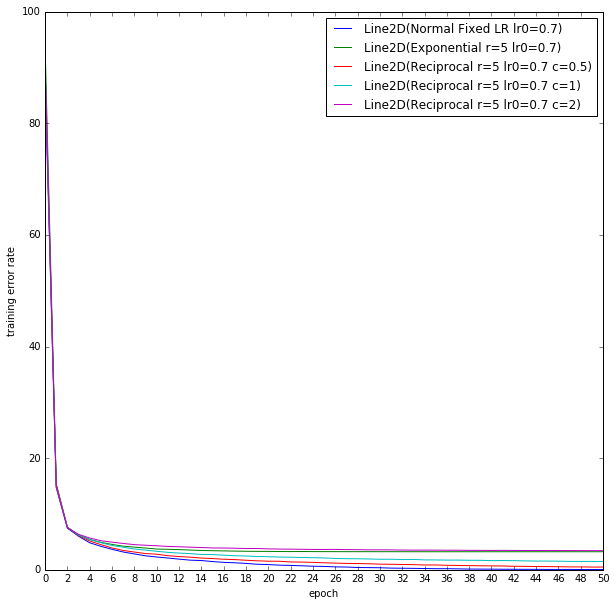

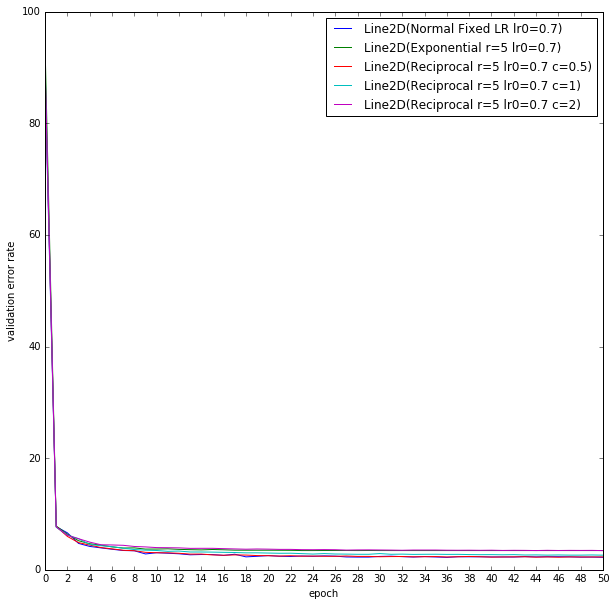

final learning rates on the test data
model                            error rate                       
Normal Fixed LR lr0=0.7          2.22                             
Exponential r=5 lr0=0.7          3.82                             
Reciprocal r=5 lr0=0.7 c=0.5     2.22                             
Reciprocal r=5 lr0=0.7 c=1       2.59                             
Reciprocal r=5 lr0=0.7 c=2       3.65                             


In [176]:
#unboxing
schd_tr_accrs = get_train_accuracies(schd_stats)
schd_vd_accrs = get_valid_accuracies(schd_stats)
schd_test_accrs = [test_stat[1] for test_stat in schd_test_stats] 

#plotting
schd_labels = [ job["label"] for job in schd_tasks]
plot_error_rate(schd_tr_accrs, schd_vd_accrs, schd_labels, figsize=(10,10))
print "{:>15}".format("final learning rates on the test data")
print_test_error_rate(schd_test_accrs, schd_labels)

#### Final results on the test data:
| Scheduler           | r   | Initial learning rate | c   | Eror rate | Accuracy % |
| -------------       |:---:|:---------------------:|:---:|:---------:|:----------:|  
| Fixed Learning Rate | NaN | 0.7                   | NaN |   2.22    |    97.78   |
| Exponential         |  5  | 0.7                   | NaN |   3.82    |    96.18   |
| Reciprocal          |  5  | 0.7                   | 0.5 |   2.22    |    97.78   |
| Reciprocal          |  5  | 0.7                   | 1.0 |   2.59    |    97.41   |
| Reciprocal          |  5  | 0.7                   | 2.0 |   3.65    |    96.35   |


Overall final results are quite close. But my initial intuition was slightly wrong. In Course Work 1 the biggest learning rate we tried was 0.5. Apparanetly lr 0.7 doing quite good as well (the error rate is 2.22 or 97.78% accuracy).

From the plot it can be seen that error rates of all models drop significantly on the first epoch and the second reaching error rate on validation set below 10%, but after that there is no need to drop very quickcly. 

After 20 epoches there is no significant improvement.

Probably that is why one of the best results is achieved by the simple model with the fixed learning rate of 0.7. "Reciprocal r=5 lr0=0.7 c=0.5" has excatly the same performance. This points out that probably for the current model 97.78% accuracy is a maximum.

Let't try different parameters

25.0


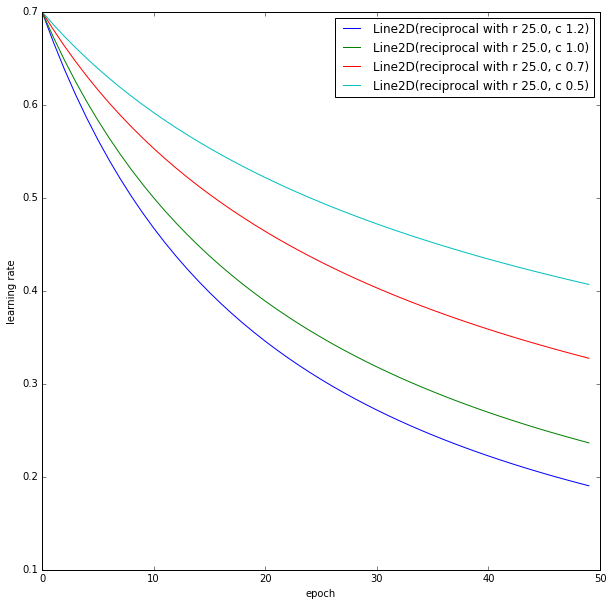

In [93]:
%matplotlib inline
initial_learning_rate = 0.7
epoches = 50
#proportional to overall batch size
r = 0.0005 * 50000
print r
cc =[1.2, 1.0, 0.7, 0.5]
lines = []
plt.figure(0, figsize=(10,10))
lines += reciprocal(initial_learning_rate, epoches, r, cc)
plt.legend(lines, loc=1)
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.show()

In [94]:
# %load tsk1_1.py
#data computaton
from mlp.schedulers import LearningRateExponential, LearningRateReciprocal, LearningRateFixed
0.45
cc =[1.2, 1.0, 0.7, 0.5]
schd_jobs_2  = [
    {
    "model": create_one_hid_model(),
    "label": "Reciprocal r=25 lr0=0.7 c=1.2",
    "lr_scheduler": LearningRateReciprocal(0.7, 50, 25, 1.2)
    },
    {
    "model": create_one_hid_model(),
    "label": "Reciprocal r=25 lr0=0.7 c=1.0",
    "lr_scheduler": LearningRateReciprocal(0.7, 50, 25, 1.0)
    },
    {
    "model": create_one_hid_model(),
    "label": "Reciprocal r=25 lr0=0.7 c=0.7",
    "lr_scheduler": LearningRateReciprocal(0.7, 50, 25, 0.7)
    },
    {
    "model": create_one_hid_model(),
    "label": "Reciprocal r=25 lr0=0.7 c=0.5",
    "lr_scheduler": LearningRateReciprocal(0.7, 50, 25, 0.5)
    }
]

schd_stats_2 = get_models_statistics(schd_jobs_2)

INFO:root:Reinitialising data providers..
INFO:root:Training started Reciprocal r=25 lr0=0.7 c=1.2 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.318. Accuracy is 10.49%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.321. Accuracy is 10.23%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.510. Accuracy is 84.76%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.282. Accuracy is 91.79%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 12398 pps. Validation speed 40533 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.256. Accuracy is 92.52%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.207. Accuracy is 94.18%
INFO:mlp.optimisers:Epoch 2: Took 4 seconds. Training speed 13850 pps. Validation speed 38775 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.201. Accuracy is 94.03%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.174. Accuracy is 95.10%
INFO:mlp.optimisers:Epoch 3: Took 4 seco

In [95]:
schd_test_stats_2 = [test_model(job["model"], job["label"]) for job in schd_jobs_2]

INFO:root:Testing the model Reciprocal r=25 lr0=0.7 c=1.2 on test set:
INFO:root:MNIST test set accuracy is 97.80 % (cost is 0.069)
INFO:root:Testing the model Reciprocal r=25 lr0=0.7 c=1.0 on test set:
INFO:root:MNIST test set accuracy is 97.77 % (cost is 0.070)
INFO:root:Testing the model Reciprocal r=25 lr0=0.7 c=0.7 on test set:
INFO:root:MNIST test set accuracy is 97.74 % (cost is 0.072)
INFO:root:Testing the model Reciprocal r=25 lr0=0.7 c=0.5 on test set:
INFO:root:MNIST test set accuracy is 97.93 % (cost is 0.069)


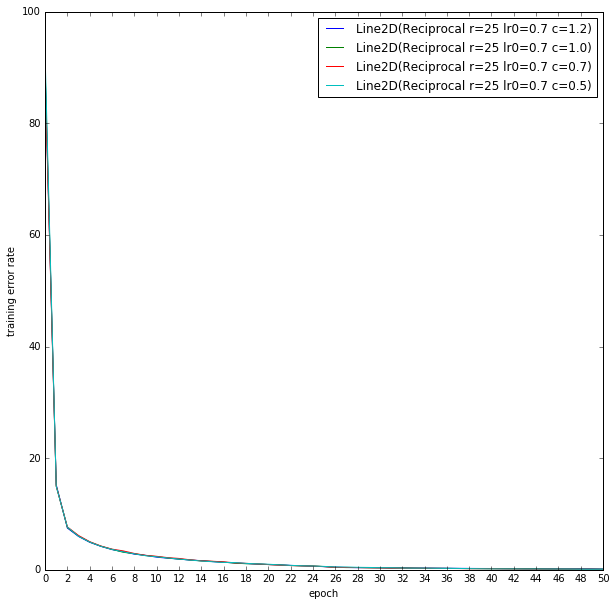

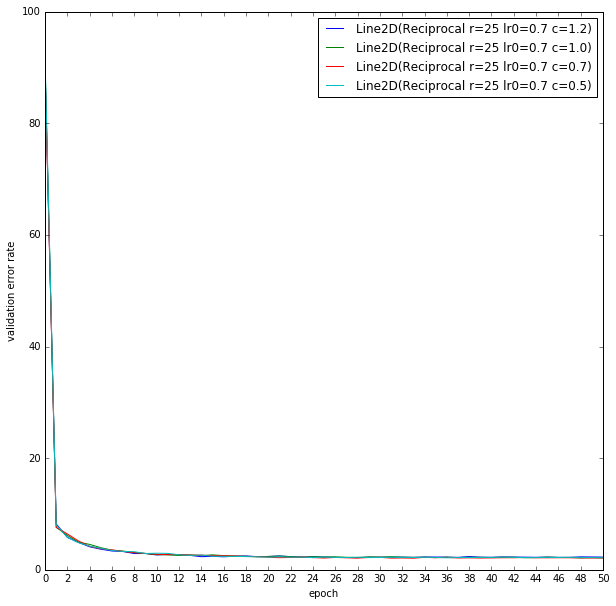

final learning rates on the test data
model                            error rate                       
Reciprocal r=25 lr0=0.7 c=1.2    2.2                              
Reciprocal r=25 lr0=0.7 c=1.0    2.23                             
Reciprocal r=25 lr0=0.7 c=0.7    2.26                             
Reciprocal r=25 lr0=0.7 c=0.5    2.07                             


In [177]:
#unboxing
schd_tr_accrs = get_train_accuracies(schd_stats_2)
schd_vd_accrs = get_valid_accuracies(schd_stats_2)
schd_test_accrs = [test_stat[1] for test_stat in schd_test_stats_2] 

#plotting
schd_labels = [ job["label"] for job in schd_jobs_2]
plot_error_rate(schd_tr_accrs, schd_vd_accrs, schd_labels, figsize=(10,10))
print "{:>15}".format("final learning rates on the test data")
print_test_error_rate(schd_test_accrs, schd_labels)


#### Final results on the test data:
| Scheduler           | r   | Initial learning rate | c   | Eror rate | Accuracy % |
| -------------       |:---:|:---------------------:|:---:|:---------:|:----------:|  
| Reciprocal          |  25 | 0.7                   | 1.2 |   2.20    |    97.80   |
| Reciprocal          |  25 | 0.7                   | 1.0 |   2.23    |    97.77   |
| Reciprocal          |  25 | 0.7                   | 0.7 |   2.26    |    97.74   |
| Reciprocal          |  25 | 0.7                   | 0.5 |   2.07    |    97.93   |


Here all results are very close (note how similiar curves are). But here the scheduler with c=0.5 has attained new maximum for this model (1 hidden layer with 100 hidden untis) with the error rate of 2.07 or accuracy 97.93%! 

This scheduler also has the lowest difference between starting and final learning rates. This points out that probably even better performance can be squized out from this model using this schedulers. 

In this and previous attempt, note that the training error_rate is almost 0.0. This means that model probably is overfitting peculiarities of training data. So there is a chance to improve this model.

For the last let's try  LearningRateNewBob scheduler starting with fixed learning rate of 0.5 which got the best results in CW1 (min_derror_ramp_start=0.0001 and min_derror_stop=.00005). For comparison we take fixed learning rate scheduler with learning rate 0.5

In [56]:
# %load tsk1_1.py
#data computaton
from mlp.schedulers import LearningRateExponential, LearningRateReciprocal, LearningRateFixed, LearningRateNewBob

schd_jobs_3  = [
    {
    "model": create_one_hid_model(),
    "label": "NewBob",
    "lr_scheduler": LearningRateNewBob(0.5, min_derror_ramp_start=0.0001, min_derror_stop=.00005, max_epochs=50)
    },
    {
    "model": create_one_hid_model(),
    "label": "Fixed",
    "lr_scheduler": LearningRateFixed(0.5, 30)
    }
]

schd_stats_3 = get_models_statistics(schd_jobs_3)

INFO:root:Reinitialising data providers..
INFO:root:Training started NewBob ..
INFO:mlp.optimisers:Epoch 1: Training cost (ce) for initial model is 2.342. Accuracy is 9.35%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) for initial model is 2.334. Accuracy is 9.86%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.574. Accuracy is 83.31%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.293. Accuracy is 91.51%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 15544 pps. Validation speed 38639 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.287. Accuracy is 91.54%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.233. Accuracy is 93.26%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training speed 17817 pps. Validation speed 43950 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.235. Accuracy is 93.13%
INFO:mlp.optimisers:Epoch 4: Validation cost (ce) is 0.201. Accuracy is 94.32%
INFO:mlp.optimisers:Epoch 4: Took 3 seconds. Training speed 18547

In [67]:
schd_test_stats_3 = [test_model(job["model"], job["label"]) for job in schd_jobs_3]


INFO:root:Testing the model NewBob on test set:
INFO:root:MNIST test set accuracy is 97.16 % (cost is 0.093)
INFO:root:Testing the model Fixed on test set:
INFO:root:MNIST test set accuracy is 97.59 % (cost is 0.075)


In [123]:
schd_test_accrs = [test_stat[1] for test_stat in schd_test_stats_3] 

schd_labels = [ job["label"] for job in schd_jobs_3]
print "{:>15}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(schd_test_accrs, schd_labels, padding=20)

final learning rates on the test data, with initial learning rate 0.7
model               error rate          
NewBob              2.84                
Fixed               2.41                


#### Final results on the test data:
| Scheduler         | Error rate | Accuracy %
| ------------- |:-------------:|:-------------:|  
| NewBob initial_learning_rate=0.5 (stopped on 16th epoch)  |  2.84 | 97.16 |
| Normal Fixed LR learning_rate=0.5                         |  2.41 | 97.59 |

Here we can see that although the fixed learning rate scheduler achieved better results, it took only 16 epoches (from the log info) for new Bob scheduler to achive the almost same result.

### Task 2 - Experiments with regularisers (5 marks)

Investigate the effect of different regularisation approaches (L1, L2, dropout).  Implement the annealing dropout scheduler (mentioned in lecture 5). Do some further investigations and experiments with model structures (and regularisers) of your choice. 

In [4]:
# %load -s DropoutAnnealed mlp/schedulers.py
from mlp.schedulers import LearningRateScheduler

class DropoutAnnealed(LearningRateScheduler):

    def __init__(self, p_inp_keep0, p_hid_keep0, inc_amnt, lr_scheduler):
        """
        In the implementation of optimisers dp_scheduler is never called
        So I wasn't sure where I have to take the current value of the epoch, and
        I didn't want to store it in two places and sync them.
        That is why I pass lr_scheduler as parameter
        """
        assert 0 < p_inp_keep0 <= 1 and 0 < p_hid_keep0 <= 1, (
            "Dropout 'keep' probabilites are suppose to be in (0, 1] range"
        )
        assert 0 < inc_amnt <= 1, (
            "increase amount must between 0 and 1"
        )

        super(DropoutAnnealed, self).__init__(max_epochs=999)
        self.p_inp_keep0 = p_inp_keep0
        self.p_hid_keep0 = p_hid_keep0
        self.inc_amnt = inc_amnt
        self.lr_scheduler = lr_scheduler

    def get_rate(self):
        
        epoch = self.lr_scheduler.epoch
        eps = epoch * self.inc_amnt
        
        p_inp_keep = min(1, self.p_inp_keep0 + eps)
        p_hid_keep = min(1, self.p_hid_keep0 + eps)
        #logger.info("Current p_inp {0}".format(p_inp_keep))
        #logger.info("Current p_hid {0}".format(p_hid_keep))
        return (p_inp_keep, p_hid_keep)

    def get_next_rate(self, current_accuracy=None):
        super(DropoutAnnealed, self).get_next_rate(current_accuracy)
        return self.get_rate()


Implementation note, in the orignal optimiser loop the get_next_rate method is never called for dp_scheduler, so it always has the same epoch. In order to bypass it, I pass the lr_scheduler as for optimiser into constructor of DropoutAnnealed

I have no idea what values for weights to choose for L1 and L2 regularization. Let's investigate which values give the best performance.

To be able to compare them, I am using the same number of epoches and the best found fixed learning rate 0.7. Although probably they can give better results with smaller learning rates suitable for subtle tuning. Moreover, NewBob scheduler potentially may give the best time to stop.

Note! I don't plot the epoch dynamic here because I am primary interested in their best final test performance. I use tables for final statistics because I have only 5 values in each case.

In [118]:
# %load tsk2_1.py
#L1 test
from mlp.schedulers import LearningRateFixed
from mlp.optimisers import SGDOptimiser

LearningRate = 0.7
Num_epoches = 30
l1_weights = [1.0, 0.1, 0.001, 0.0001, 0.00001]
tsk2_1_jobs  = []
for l1_w in l1_weights:
    lr_scheduler = LearningRateFixed(LearningRate, Num_epoches)
    tsk2_1_jobs.append(
        {
            "model": create_one_hid_model(),
            "label": "l1_w={}".format(l1_w),
            "optimiser": SGDOptimiser(lr_scheduler, l1_weight=l1_w)
        }
    )

tsk2_1_stats = get_models_statistics(tsk2_1_jobs)

INFO:root:Reinitialising data providers...
INFO:root:Training started l1_w=1.0 ...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 3969.355. Accuracy is 9.68%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 3969.352. Accuracy is 10.09%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 298.425. Accuracy is 9.96%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 298.452. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 15250 pps. Validation speed 41806 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 293.102. Accuracy is 10.15%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 293.040. Accuracy is 9.91%
INFO:mlp.optimisers:Epoch 2: Took 4 seconds. Training speed 14902 pps. Validation speed 41835 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 290.074. Accuracy is 9.89%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 289.899. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 3: Took 5 seconds. Tr

In [119]:
tsk2_1_test_stats = [test_model(job["model"], job["label"]) for job in tsk2_1_jobs]

INFO:root:Testing the model l1_w=1.0 on test set:
INFO:root:MNIST test set accuracy is 9.74 % (cost is 2.584)
INFO:root:Testing the model l1_w=0.1 on test set:
INFO:root:MNIST test set accuracy is 90.84 % (cost is 0.320)
INFO:root:Testing the model l1_w=0.001 on test set:
INFO:root:MNIST test set accuracy is 97.93 % (cost is 0.069)
INFO:root:Testing the model l1_w=0.0001 on test set:
INFO:root:MNIST test set accuracy is 97.74 % (cost is 0.074)
INFO:root:Testing the model l1_w=1e-05 on test set:
INFO:root:MNIST test set accuracy is 97.77 % (cost is 0.071)


In [124]:
tsk2_1_test_accrs = [test_stat[1] for test_stat in tsk2_1_test_stats ]
tsk2_1_labels = [ job["label"] for job in tsk2_1_jobs]
print "{:>15}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk2_1_test_accrs, tsk2_1_labels, padding=20)

final learning rates on the test data, with initial learning rate 0.7
model               error rate          
l1_w=1.0            90.26               
l1_w=0.1            9.16                
l1_w=0.001          2.07                
l1_w=0.0001         2.26                
l1_w=1e-05          2.23                


#### Final results on the test data:
| Regularization   | Error rate | Accuracy % |
| ------------- |:-------------:|:-------------:| 
| L1=1.0    |  90.26 | 9.74  | 
| L1=0.1    |  9.16  | 90.84 |
| L1=0.001  |  2.07  | 97.93 |
| L1=0.0001 |  2.26  | 97.74 |
| L1=1e-05  |  2.23  | 97.77 |

The best L1_weight is 0.001, and with that the current model reaches the best accuracy of 97.93% or error_rate 2.07!
Let's see results for L2.

In [130]:
#L2 test
from mlp.schedulers import LearningRateFixed
from mlp.optimisers import SGDOptimiser

LearningRate = 0.7
Num_epoches = 30
l2_weights = [1.0, 0.1, 0.001, 0.0001, 0.00001]
tsk2_2_jobs  = []
for l2_w in l1_weights:
    lr_scheduler = LearningRateFixed(LearningRate, Num_epoches)
    tsk2_2_jobs.append(
        {
            "model": create_one_hid_model(),
            "label": "l2_w={}".format(l2_w),
            "optimiser": SGDOptimiser(lr_scheduler, l2_weight=l2_w)
        }
    )

tsk2_2_stats = get_models_statistics(tsk2_2_jobs)

INFO:root:Reinitialising data providers...
INFO:root:Training started l2_w=1.0 ...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 134.770. Accuracy is 13.81%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 134.774. Accuracy is 12.95%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 48.064. Accuracy is 80.61%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 47.887. Accuracy is 87.03%
INFO:mlp.optimisers:Epoch 1: Took 3 seconds. Training speed 17803 pps. Validation speed 43895 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 47.870. Accuracy is 85.93%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 47.830. Accuracy is 87.32%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 16094 pps. Validation speed 45051 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 48.189. Accuracy is 86.26%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 48.149. Accuracy is 88.86%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Trai

In [131]:
tsk2_2_test_stats = [test_model(job["model"], job["label"]) for job in tsk2_2_jobs]

INFO:root:Testing the model l2_w=1.0 on test set:
INFO:root:MNIST test set accuracy is 86.49 % (cost is 0.532)
INFO:root:Testing the model l2_w=0.1 on test set:
INFO:root:MNIST test set accuracy is 95.23 % (cost is 0.185)
INFO:root:Testing the model l2_w=0.001 on test set:
INFO:root:MNIST test set accuracy is 97.78 % (cost is 0.072)
INFO:root:Testing the model l2_w=0.0001 on test set:
INFO:root:MNIST test set accuracy is 97.66 % (cost is 0.072)
INFO:root:Testing the model l2_w=1e-05 on test set:
INFO:root:MNIST test set accuracy is 97.70 % (cost is 0.075)


In [135]:
tsk2_2_test_accrs = [test_stat[1] for test_stat in tsk2_2_test_stats ]
tsk2_2_labels = [ job["label"] for job in tsk2_2_jobs]
print "{:>15}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk2_2_test_accrs, tsk2_2_labels)

final learning rates on the test data, with initial learning rate 0.7
model                            error rate                       
l2_w=1.0                         13.51                            
l2_w=0.1                         4.77                             
l2_w=0.001                       2.22                             
l2_w=0.0001                      2.34                             
l2_w=1e-05                       2.3                              


#### Final results on the test data:
| Regularization        | Error rate | Accuracy % |
| ------------- |:-------------:|:-------------:| 
| L2=1.0    |  13.51 | 86.49 |
| L2=0.1    |  4.77  | 95.23 |
| L2=0.001  |  2.22  | 97.78 |
| L2=0.0001 |  2.34  | 97.66 |
| L2=1e-05  |  2.30  | 97.70 |

Once again the best results are achieved with 0.001 L2 weight. However, it is worse than the result achieved by L1 regularization. 
As L1 and L2 regularization share have a lot in common let's compare the weights magnitutes in models with regularization and without it. For that I will train the model without regularization.

In [136]:
#the default with no regularization
from mlp.schedulers import LearningRateFixed
from mlp.optimisers import SGDOptimiser

LearningRate = 0.7
Num_epoches = 30
tsk2_3_jobs  = [
        {
            "model": create_one_hid_model(),
            "label": "no_regularization",
            "lr_scheduler": LearningRateFixed(LearningRate, 30)
        }
]

tsk2_3_stats = get_models_statistics(tsk2_3_jobs)

INFO:root:Reinitialising data providers..
INFO:root:Training started no_regularization ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.327. Accuracy is 10.82%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.324. Accuracy is 11.11%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.510. Accuracy is 84.81%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.290. Accuracy is 91.53%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 14816 pps. Validation speed 38390 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.258. Accuracy is 92.51%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.208. Accuracy is 94.11%
INFO:mlp.optimisers:Epoch 2: Took 4 seconds. Training speed 13763 pps. Validation speed 38462 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.204. Accuracy is 93.95%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.175. Accuracy is 95.26%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Trainin

78400 hidden units in the intial layer is just too much for sorted histogram.
So just the histograms of the best regularizers.

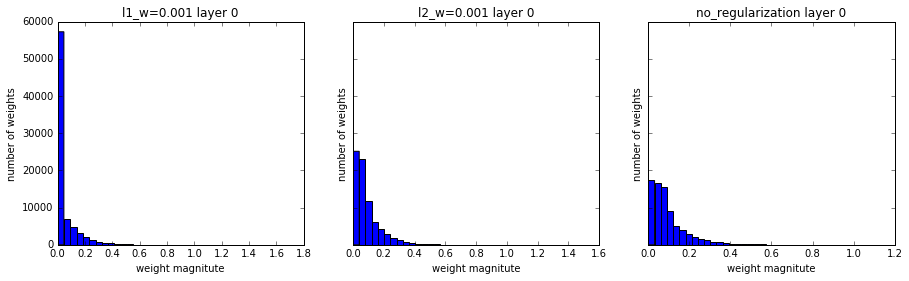

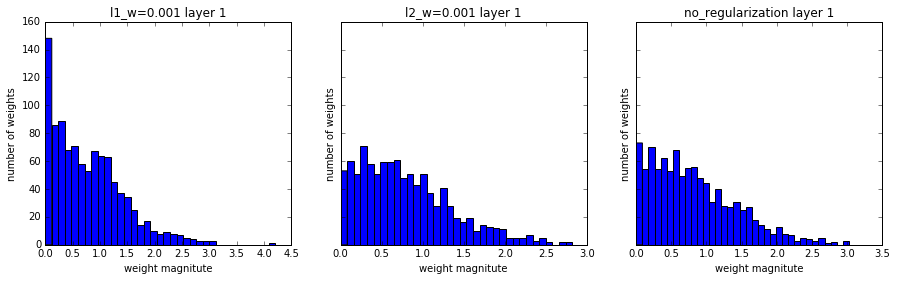

In [162]:

def layer_hist(layers, labels):
    f, axis = plt.subplots(1, len(layers), sharey=True, figsize=(15,4))
    for nth, label, layer in zip(range(len(layers)), labels, layers):
        ax = axis[nth]
        W, b = layer.get_params()
        w_mag = list(np.abs(W.reshape(-1)))
        ax.set_title(label)
        ax.hist(w_mag, bins=35)
        ax.set_ylabel("number of weights")
        ax.set_xlabel("weight magnitude")

    plt.show()
    
ml_l1, lb_l1 = tsk2_1_jobs[2]["model"], tsk2_1_jobs[2]["label"]
ml_l2, lb_l2 = tsk2_2_jobs[2]["model"], tsk2_2_jobs[2]["label"]
ml_nr, lb_nr = tsk2_3_jobs[0]["model"], tsk2_3_jobs[0]["label"]

for i in range(2):
    ad = " layer {}".format(i)
    layer_hist([ml_l1.layers[i], ml_l2.layers[i], ml_nr.layers[i]], [lb_l1 + ad, lb_l2 + ad, lb_nr + ad])

From these histograms it can be seen that L1 regularization prunes magintudes most of all for the current model. In input layer only  tiny fraction of weight has magnitude bigger then 0.05 (almost 60000 weights are below that value of magnitude!). As we saw earlier, this L1 regularizer has the best performance which follows our intuiton that only small number of wheights is really important. 

L2 regularization also prunes weights as it can be seen in comparison to no_regularization model but L2 does it not so effectively as L1.

The success of L1 regularizer can be described by the fact that in the current model the hidden layer is using Sigmoid and the values are quite small (between 0 and 1) so L1 prune it faster than L2 because L2 is proportional to the weight magnitude. Most likely for Relu functions the result would be quite opposite, as their weights magnitude are unbounded.

Note! In the layer 0 (the hidden layer) the values of magnitudes are all below 1.0 because it is Sigmoid layer.

Now let's look at dropout effects. First I vary parameters p_inp_keep and p_hid_keep individiually. The learning rate is 0.7 and number of epoches is 30.

In [163]:

from mlp.schedulers import DropoutFixed, LearningRateFixed
from mlp.optimisers import SGDOptimiser

LearningRate = 0.7
Num_epoches = 30
p_inp_values = [0.9, 0.8, 0.7, 0.6, 0.5]
p_hid_keep = 1.0
tsk2_4_jobs  = []
for p_inp in p_inp_values:
    lr_scheduler = LearningRateFixed(LearningRate, Num_epoches)
    dp_scheduler = DropoutFixed(p_inp, p_hid_keep)
    tsk2_4_jobs.append(
        {
            "model": create_one_hid_model(),
            "label": "p_inp={}".format(p_inp),
            "optimiser": SGDOptimiser(lr_scheduler, dp_scheduler=dp_scheduler)
        }
    )

tsk2_4_stats = get_models_statistics(tsk2_4_jobs)

INFO:root:Reinitialising data providers..
INFO:root:Training started p_inp=0.9 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.329. Accuracy is 10.19%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.331. Accuracy is 9.41%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.528. Accuracy is 84.24%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.262. Accuracy is 92.36%
INFO:mlp.optimisers:Epoch 1: Took 6 seconds. Training speed 8380 pps. Validation speed 43292 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.277. Accuracy is 91.79%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.218. Accuracy is 93.61%
INFO:mlp.optimisers:Epoch 2: Took 6 seconds. Training speed 9384 pps. Validation speed 37676 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.217. Accuracy is 93.64%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.180. Accuracy is 94.99%
INFO:mlp.optimisers:Epoch 3: Took 6 seconds. Training speed 895

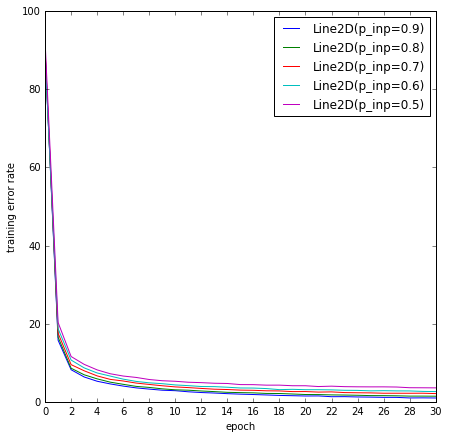

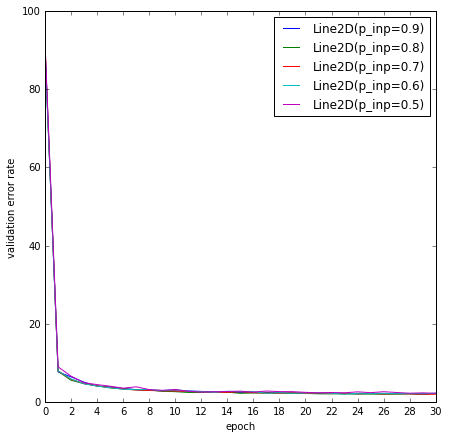

In [173]:
tsk2_4_tr_accrs = get_train_accuracies(tsk2_4_stats)
tsk2_4_vd_accrs = get_valid_accuracies(tsk2_4_stats)
tsk2_4_test_accrs = [test_stat[1] for test_stat in tsk2_4_test_stats] 

#plotting
tsk2_4_labels = [ job["label"] for job in tsk2_4_jobs]
plot_error_rate(tsk2_4_tr_accrs, tsk2_4_vd_accrs, tsk2_4_labels)

Here I plotted dynamic because the training error is higher then validation error. So dropout really helps to cope with overfitting the peculiarities in the data. Note also how close are all validation error rates.

In [165]:
tsk2_4_test_stats = [test_model(job["model"], job["label"]) for job in tsk2_4_jobs]
tsk2_4_test_accrs = [test_stat[1] for test_stat in tsk2_4_test_stats ]
tsk2_4_labels = [ job["label"] for job in tsk2_4_jobs]
print "{:>15}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk2_4_test_accrs, tsk2_4_labels, padding=15)

INFO:root:Testing the model p_inp=0.9 on test set:
INFO:root:MNIST test set accuracy is 97.98 % (cost is 0.068)
INFO:root:Testing the model p_inp=0.8 on test set:
INFO:root:MNIST test set accuracy is 97.80 % (cost is 0.065)
INFO:root:Testing the model p_inp=0.7 on test set:
INFO:root:MNIST test set accuracy is 97.88 % (cost is 0.065)
INFO:root:Testing the model p_inp=0.6 on test set:
INFO:root:MNIST test set accuracy is 97.63 % (cost is 0.070)
INFO:root:Testing the model p_inp=0.5 on test set:
INFO:root:MNIST test set accuracy is 97.78 % (cost is 0.069)


final learning rates on the test data, with initial learning rate 0.7
model          error rate     
p_inp=0.9      2.02           
p_inp=0.8      2.2            
p_inp=0.7      2.12           
p_inp=0.6      2.37           
p_inp=0.5      2.22           


#### Final results on the test data Dropout Regularizer:
| p_inp_keep  | p_hid_keep | Error rate | Accuracy % |
|:-----------:|:----------:|:-------------:|:-------------:| 
| 0.9  | 1.0 |  2.02 | 97.98 |
| 0.8  | 1.0 |  2.20 | 97.80 |
| 0.7  | 1.0 |  2.12 | 97.88 |
| 0.6  | 1.0 |  2.37 | 97.63 |
| 0.5  | 1.0 |  2.22 | 97.78 |

This is an important result as it demonstrates that even slightly eliminating values in the input layer may lead to significantly better performance. In essence it is similar to adding some artificial noise in the training data. The result with p_inp_keep = 0.9 is the best results among methods considered so far (error_rate 2.02 or 97.98% accuracy)!

Also validation error rate drops quicker than training error rate. 

In [166]:

from mlp.schedulers import DropoutFixed, LearningRateFixed
from mlp.optimisers import SGDOptimiser

LearningRate = 0.7
Num_epoches = 30
p_hid_values = [0.9, 0.8, 0.7, 0.6, 0.5]
p_inp_keep = 1.0
tsk2_5_jobs  = []
for p_hid in p_hid_values:
    lr_scheduler = LearningRateFixed(LearningRate, Num_epoches)
    dp_scheduler = DropoutFixed(p_inp_keep, p_hid)
    tsk2_5_jobs.append(
        {
            "model": create_one_hid_model(),
            "label": "p_hid={}".format(p_hid),
            "optimiser": SGDOptimiser(lr_scheduler, dp_scheduler=dp_scheduler)
        }
    )

tsk2_5_stats = get_models_statistics(tsk2_5_jobs)

INFO:root:Reinitialising data providers..
INFO:root:Training started p_hid=0.9 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.314. Accuracy is 12.20%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.311. Accuracy is 12.14%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.548. Accuracy is 83.68%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.275. Accuracy is 92.32%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 13966 pps. Validation speed 36619 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.288. Accuracy is 91.55%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.223. Accuracy is 93.58%
INFO:mlp.optimisers:Epoch 2: Took 4 seconds. Training speed 12460 pps. Validation speed 37237 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.234. Accuracy is 93.12%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.179. Accuracy is 95.05%
INFO:mlp.optimisers:Epoch 3: Took 4 seconds. Training speed 

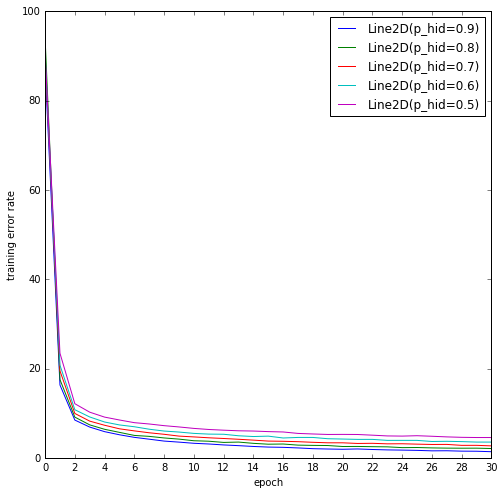

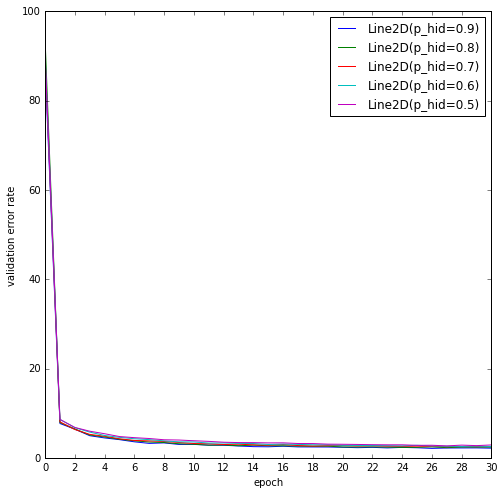

In [181]:
tsk2_5_tr_accrs = get_train_accuracies(tsk2_5_stats)
tsk2_5_vd_accrs = get_valid_accuracies(tsk2_5_stats)
tsk2_5_test_accrs = [test_stat[1] for test_stat in tsk2_5_test_stats] 

#plotting
tsk2_5_labels = [ job["label"] for job in tsk2_5_jobs]
plot_error_rate(tsk2_5_tr_accrs, tsk2_5_vd_accrs, tsk2_5_labels, figsize=(8,8))

Here the situation is identical to the previous case. The validation error is noticeably lower than training error

In [167]:
tsk2_5_test_stats = [test_model(job["model"], job["label"]) for job in tsk2_5_jobs]
tsk2_5_test_accrs = [test_stat[1] for test_stat in tsk2_5_test_stats ]
tsk2_5_labels = [ job["label"] for job in tsk2_5_jobs]
print "{:>15}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk2_5_test_accrs, tsk2_5_labels, padding=15)

INFO:root:Testing the model p_hid=0.9 on test set:
INFO:root:MNIST test set accuracy is 97.76 % (cost is 0.071)
INFO:root:Testing the model p_hid=0.8 on test set:
INFO:root:MNIST test set accuracy is 97.65 % (cost is 0.078)
INFO:root:Testing the model p_hid=0.7 on test set:
INFO:root:MNIST test set accuracy is 97.40 % (cost is 0.085)
INFO:root:Testing the model p_hid=0.6 on test set:
INFO:root:MNIST test set accuracy is 97.32 % (cost is 0.091)
INFO:root:Testing the model p_hid=0.5 on test set:
INFO:root:MNIST test set accuracy is 97.03 % (cost is 0.102)


final learning rates on the test data, with initial learning rate 0.7
model          error rate     
p_hid=0.9      2.24           
p_hid=0.8      2.35           
p_hid=0.7      2.6            
p_hid=0.6      2.68           
p_hid=0.5      2.97           


#### Final results on the test data on Dropout Regularizer :
| p_inp_keep | p_hid_keep | Error rate | Accuracy % |
|:----------:|:-----------:|:-------------:| 
| 1.0 | 0.9  |  2.24 | 97.76 |
| 1.0 | 0.8  |  2.35 | 97.65 |
| 1.0 | 0.7  |  2.60 | 97.40 |
| 1.0 | 0.6  |  2.68 | 97.32 |
| 1.0 | 0.5  |  2.97 | 97.03 |

Once again the value of 0.9 yield the best result. However, the drop in the error rate is not so significant. Probably due to the size of the layer

Finally, DropoutAnnealed. Let's try different increasing values. This scheduler varies both p_hid_keep and p_valid_keep so potentially it can be seen as conjuction of two previous runs. As initial values of p_inp_keep and p_hid_keep I choose 0.5 and take values of inc_values accordingly to it and num_epoches

In [6]:
from mlp.schedulers import LearningRateFixed
from mlp.optimisers import SGDOptimiser

LearningRate = 0.7
Num_epoches = 30
p_inp_keep0 = 0.5
p_hid_keep0 = 0.5
inc_values = [0.5/30.0, 0.5/25.0, 0.5/20.0, 0.5/15.0, 0.5/10.0]
tsk2_6_jobs  = []
for inc in inc_values:
    lr_scheduler = LearningRateFixed(LearningRate, Num_epoches)
    dp_scheduler = DropoutAnnealed(p_inp_keep0, p_hid_keep0, inc, lr_scheduler)
    tsk2_6_jobs.append(
        {
            "model": create_one_hid_model(),
            "label": "inc={}".format(inc),
            "optimiser": SGDOptimiser(lr_scheduler, dp_scheduler=dp_scheduler)
        }
    )

tsk2_6_stats = get_models_statistics(tsk2_6_jobs)

INFO:root:Reinitialising data providers..
INFO:root:Training started inc=0.0166666666667 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.344. Accuracy is 12.43%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.344. Accuracy is 12.92%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.893. Accuracy is 71.06%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.347. Accuracy is 90.65%
INFO:mlp.optimisers:Epoch 1: Took 6 seconds. Training speed 8581 pps. Validation speed 42588 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.543. Accuracy is 82.99%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.271. Accuracy is 92.90%
INFO:mlp.optimisers:Epoch 2: Took 6 seconds. Training speed 8377 pps. Validation speed 37407 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.457. Accuracy is 85.86%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.230. Accuracy is 93.63%
INFO:mlp.optimisers:Epoch 3: Took 6 seconds. Trainin

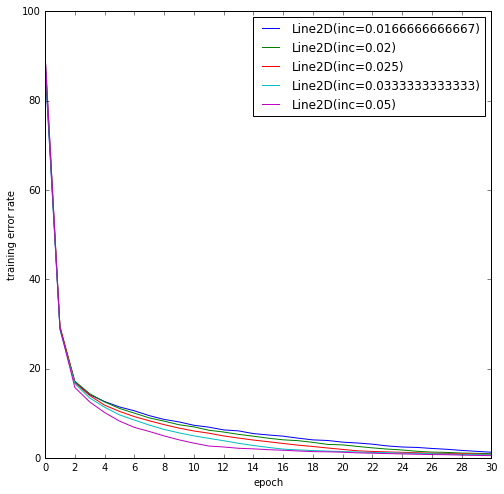

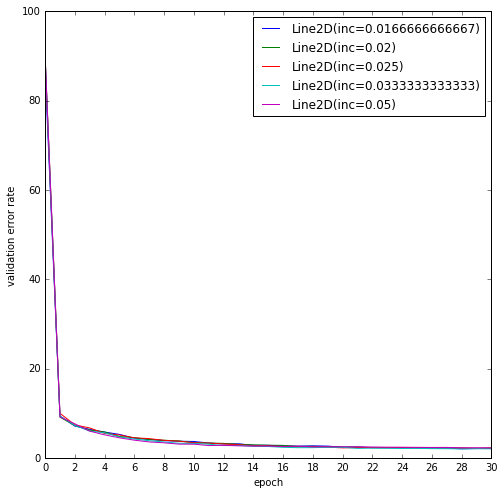

INFO:root:Testing the model inc=0.0166666666667 on test set:
INFO:root:MNIST test set accuracy is 97.92 % (cost is 0.068)
INFO:root:Testing the model inc=0.02 on test set:
INFO:root:MNIST test set accuracy is 97.90 % (cost is 0.065)
INFO:root:Testing the model inc=0.025 on test set:
INFO:root:MNIST test set accuracy is 97.64 % (cost is 0.071)
INFO:root:Testing the model inc=0.0333333333333 on test set:
INFO:root:MNIST test set accuracy is 97.77 % (cost is 0.066)
INFO:root:Testing the model inc=0.05 on test set:
INFO:root:MNIST test set accuracy is 97.85 % (cost is 0.069)


final learning rates on the test data, with initial learning rate 0.7
model                         error rate                    
inc=0.0166666666667           2.08                          
inc=0.02                      2.1                           
inc=0.025                     2.36                          
inc=0.0333333333333           2.23                          
inc=0.05                      2.15                          


In [10]:
%matplotlib inline
tsk2_6_tr_accrs = get_train_accuracies(tsk2_6_stats)
tsk2_6_vd_accrs = get_valid_accuracies(tsk2_6_stats)

#plotting
tsk2_6_labels = [ job["label"] for job in tsk2_6_jobs]
plot_error_rate(tsk2_6_tr_accrs, tsk2_6_vd_accrs, tsk2_6_labels, figsize=(8,8))

tsk2_6_test_stats = [test_model(job["model"], job["label"]) for job in tsk2_6_jobs]
tsk2_6_test_accrs = [test_stat[1] for test_stat in tsk2_6_test_stats ]
tsk2_6_labels = [ job["label"] for job in tsk2_6_jobs]
print "{:>16}".format("final learning rates on the test data")
print_test_error_rate(tsk2_6_test_accrs, tsk2_6_labels, padding=30)

#### Final results on the test data for Dropout Annealed Regularizer:
| increment | initial p_inp | initial p_hid_keep | Error rate | Accuracy % |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:| 
| 0.0167 | 0.5 | 0.5 |  2.08 | 97.92 |
| 0.0200 | 0.5 | 0.5 |  2.10 | 97.90 | 
| 0.0250 | 0.5 | 0.5 |  2.36 | 97.64 |
| 0.0333 | 0.5 | 0.5 |  2.23 | 97.77 |
| 0.0500 | 0.5 | 0.5 |  2.15 | 97.85 |

Although this methods doesn't give the best performance, it is still considerably high. It achieves error_rate 2.08 or accuracy of 97.92 percents this points out that increase of p_hid and p_inp should happen slowly. Also validation error rate reaches the bottom much faster than training error rate. 
Definitely it is worth to play with this scheduler in the task 5 using lower learning rates in the end, as its error rate dynamic is very promosing for this model.

### Task 3 - Experiments with pretraining (15 marks)

Implement pretraining of multi-layer networks with autoencoders, denoising autoencoders, and using  layer-by-layer cross-entropy training.  

Implementation tip: You could add the corresponding methods to `optimiser`, namely, `pretrain()` and `pretrain_epoch()`, for autoencoders. Simiilarly, `pretrain_discriminative()` and `pretrain_epoch_discriminative()` for cross-entropy layer-by-layer pretraining. Of course, you can modify any other necessary pieces, but include all the modified fragments below.

In this task I had to work closely with the existing codebase so I have some ways to improve it.

I have found a minor error in the current implementation of SGDOptimizer (from github), in train method it will generate error if validation_iterator is not provided

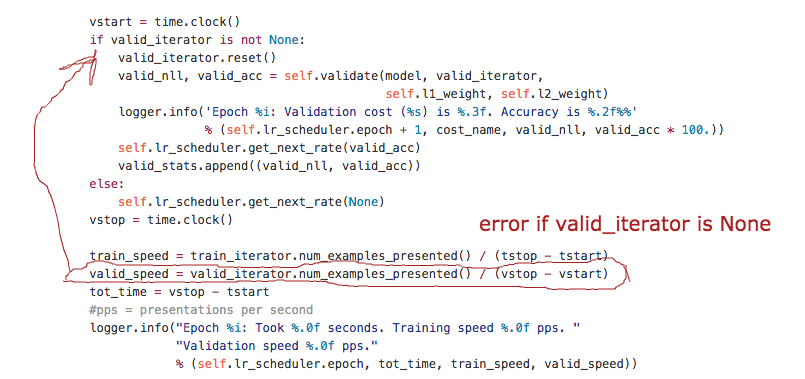

In [1]:
from IPython.display import Image
Image(filename='error_in_optimizers.png')

Also I have found some way to improve the speed of training. From here on I will be sometimes using this optimised code. I will discuss it further in part 2 because it gives the biggest gains when the first layer is huge as it allows to ignore backpropagation in most case for the first layer (Which is very important for CNN. I discussed this trick with professor Steve Renals and he approved it).

In [ ]:
# %load -s MLP_fast mlp/layers
class MLP_fast(MLP):
    """
    The same as original MLP except for the part with
    backpropagation where it accounts whether it is first_layer or not.
    This may be unimportant for traditional NN, but it is very important for
    convolution NN, as they first layer has to backpropagate the largest ograds.
    But with this trick we can skip it
    """
    def __init__(self, cost, rng=None):
        super(MLP_fast, self).__init__(cost, rng)

    def bprop(self, cost_grad, dp_scheduler=None):
        """
        :param cost_grad: matrix -- grad of the cost w.r.t y
        :return: None, the deltas are kept in the model
        """

        # allocate the list of deltas for each layer
        # note, we do not use all of those fields but
        # want to keep it aligned 1:1 with activations,
        # which will simplify indexing later on when
        # computing grads w.r.t parameters
        if len(self.deltas) != len(self.activations):
            self.deltas = [None]*len(self.activations)

        # treat the top layer in special way, as it deals with the
        # cost, which may lead to some simplifications
        top_layer_idx = len(self.layers)
        self.deltas[top_layer_idx], ograds = self.layers[top_layer_idx - 1].\
            bprop_cost(self.activations[top_layer_idx], cost_grad, self.cost)

        p_hid_scaler = 1.0
        if dp_scheduler is not None:
            p_inp, p_hid = dp_scheduler.get_rate()
            p_hid_scaler /= p_hid

        # then back-prop through remaining layers
        for i in xrange(top_layer_idx - 1, 0, -1):
            #there is no need to calculate ograds for the first layer
            #not crucial for simple layers, crucail for ConvLayers
            first_layer = i - 1 == 0
            self.deltas[i], ograds = self.layers[i - 1].\
                bprop(self.activations[i], ograds*p_hid_scaler, first_layer=first_layer)

    def get_name(self):
        return 'mlp_fast'


The change is in the end of the bprop method where I added boolean flag to distinguish first layer. In backpropagation for most layers the heaviest part is to compute ograds as inputs for the previous layers. And the layer is the fist one there is no need to do that as there is no layers under it. I modified existing layers as well to account this modification. I will show it one bprop of the Linear layer

In [ ]:
# %load -s Linear,bprop mlp/layers
def bprop(self, h, igrads, first_layer=False):
    """
    Implements a backward propagation through the layer, that is, given
    h^i denotes the output of the layer and x^i the input, we compute:
    dh^i/dx^i which by chain rule is dh^i/da^i da^i/dx^i
    x^i could be either features (x) or the output of the lower layer h^{i-1}
    :param h: it's an activation produced in forward pass
    :param igrads, error signal (or gradient) flowing to the layer, note,
           this in general case does not corresponds to 'deltas' used to update
           the layer's parameters, to get deltas ones need to multiply it with
           the dh^i/da^i derivative
    :return: a tuple (deltas, ograds) where:
           deltas = igrads * dh^i/da^i
           ograds = deltas \times da^i/dx^i
    """

    # since df^i/da^i = 1 (f is assumed identity function),
    # deltas are in fact the same as igrads

    #computing ograds may be very expensive, and we don't need them for the first_layer layer!
    if first_layer:
        return igrads, None
    ograds = numpy.dot(igrads, self.W.T)
    return igrads, ograds


Here note that due to the first layer boolean flag we don't need to compute expensive dot product between igrads and W.T. Imagine huge hidden layer with 800 hidden units. For that we don't need to compute one very expensive dot product anymore. 
However, the biggest difference is achieved with convolutional layers (I did part 2 before part 1), as one of the largest layer is the first one and you don't need to compute backward convolution for it anymore. The time comparison will be given in part 2.

pretrain_discriminative method is for cross-entropy layer-by-layer pretraining, pretrain method is for autoencoders pretraining and pretrain_masking for denoising autoencoders. Note that denoising autoencoder I use masking technique to produce noise in the input, the amount of noise controlled by the prob_keep where prob_keep=1.0 means no noise in the pretrain_masking method

In [ ]:
md5sum# %load -s Optimiser mlp/optimisers
class Optimiser(object):

    def pretrain_epoches(self, cur_model, train_iterator, scheduler, get_inputs, get_targets):
        converged = False
        cost_name = cur_model.cost.get_name()
        cur_tr_stats = []
        while not converged:
            train_iterator.reset()

            tstart = time.clock()
            tr_nll, tr_acc = self.pretrain_epoch_general(cur_model=cur_model,
                                                         train_iterator=train_iterator,
                                                         learning_rate=scheduler.get_rate(),
                                                         get_inputs=get_inputs,
                                                         get_targets=get_targets)

            tstop = time.clock()
            cur_tr_stats.append((tr_nll, tr_acc))

            logger.info('Epoch %i: Training cost (%s) is %.3f. Accuracy is %.2f%%'
                        % (scheduler.epoch + 1, cost_name, tr_nll, tr_acc * 100.))

            scheduler.get_next_rate(None)

            train_speed = train_iterator.num_examples_presented() / (tstop - tstart)
            tot_time = tstop - tstart
            logger.info("Epoch %i: Took %.0f seconds. Training speed %.0f pps. "
                        % (scheduler.epoch, tot_time, train_speed))
            converged = (scheduler.get_rate() == 0)
        return cur_tr_stats

    def pretrain_epoch_general(self, cur_model, train_iterator, learning_rate, get_inputs, get_targets):
        assert isinstance(cur_model, MLP), (
            "Expected current model to be a subclass of 'mlp.layers.MLP'"
            " class but got %s " % type(cur_model)
        )
        assert isinstance(train_iterator, DataProvider), (
            "Expected iterator to be a subclass of 'mlp.dataset.DataProvider'"
            " class but got %s " % type(train_iterator)
        )

        acc_list, nll_list = [], []

        for x, t in train_iterator:
            inputs, pure = get_inputs(x)
            y = cur_model.fprop(inputs)
            targets = get_targets(inputs, t, pure)
            cost = cur_model.cost.cost(y, targets)
            cost_grad = cur_model.cost.grad(y, targets)

            # do backward pass through the model
            cur_model.bprop(cost_grad)

            #update the model, here we iterate over layers
            #and then over each parameter in the layer
            effective_learning_rate = learning_rate / x.shape[0]

            for i in xrange(0, len(cur_model.layers)):
                params = cur_model.layers[i].get_params()
                #no regularisation
                grads = cur_model.layers[i].pgrads(inputs=cur_model.activations[i],
                                               deltas=cur_model.deltas[i + 1])
                uparams = []
                for param, grad in zip(params, grads):
                    param = param - effective_learning_rate * grad
                    uparams.append(param)
                cur_model.layers[i].set_params(uparams)

            nll_list.append(cost)
            acc_list.append(numpy.mean(self.classification_accuracy(y, targets)))

        #compute the prior penalties contribution (parameter dependent only)
        return numpy.mean(nll_list) , numpy.mean(acc_list)

    def pretrain_general(self, model, train_iterator, epoches_per_layer, learning_rate, get_cur_model, draw_handler=None):
        from mlp.schedulers import LearningRateFixed
        tr_stats = [ None ] * len(model.layers)
        for cur_layer_id in xrange(len(model.layers)):
            cur_model, get_inputs, get_targets = get_cur_model(model, cur_layer_id)
            scheduler = LearningRateFixed(learning_rate, epoches_per_layer)
            logger.info("Starting pretraining layer {}".format(cur_layer_id))
            cur_stat = self.pretrain_epoches(cur_model=cur_model,
                                             train_iterator=train_iterator,
                                             scheduler=scheduler,
                                             get_inputs=get_inputs,
                                             get_targets=get_targets)
            tr_stats[cur_layer_id] = cur_stat
            if draw_handler is not None:
                draw_handler(cur_layer_id, cur_model, get_inputs)

        return tr_stats

    def pretrain_discriminative(self, model, train_iterator, epoches_per_layer, learning_rate):
        from mlp.layers import MLP_fast, Linear, Softmax
        from mlp.costs import CECost, MSECost

        last_layer = len(model.layers) - 1
        #from discriminative model
        def get_cur_discr_model(model, cur_layer_id):
            cur_layer = model.layers[cur_layer_id]
            assert isinstance(cur_layer, Linear), (
                "Expected current layer to be Linear or its subclass"
            )
            get_targets = lambda inputs, t, pure: t
            if cur_layer_id == 0:
                get_inputs = lambda x: (x, None)
            else:
                prev_layers = model.layers[:cur_layer_id]
                prev_mds = MLP_fast(MSECost())
                prev_mds.set_layers(prev_layers)
                get_inputs = lambda x: (prev_mds.fprop(x), None)

            last_layer = cur_layer_id == len(model.layers) - 1
            cur_model = MLP_fast(CECost())
            cur_model.add_layer(cur_layer)
            if last_layer:
                assert isinstance(cur_layer, Softmax), (
                    "final layer must be softmax for MNIST digits classification"
                )
                #here it automatically matches output of previous layer
            else:
                #get final layer for the MNIST dataset
                cur_model.add_layer(Softmax(cur_layer.odim, 10))

            return cur_model, get_inputs, get_targets

        return self.pretrain_general(model=model,
                                     train_iterator=train_iterator,
                                     epoches_per_layer=epoches_per_layer,
                                     learning_rate=learning_rate,
                                     get_cur_model=get_cur_discr_model)


    def pretrain(self, model, train_iterator, epoches_per_layer, learning_rate, draw_handler=None):
        from mlp.layers import MLP_fast, Linear, Softmax
        from mlp.costs import CECost, MSECost

        last_layer = len(model.layers) - 1

        def get_cur_encoder_model(model, cur_layer_id):
            cur_layer = model.layers[cur_layer_id]
            assert isinstance(cur_layer, Linear), (
                "Expected current layer to be Linear or its subclass"
            )

            if cur_layer_id == 0:
                get_inputs = lambda x: (x, None)
            else:
                prev_layers = model.layers[:cur_layer_id]
                prev_mds = MLP_fast(MSECost())
                prev_mds.set_layers(prev_layers)
                get_inputs = lambda x: (prev_mds.fprop(x), None)

            if cur_layer_id == last_layer:
                assert isinstance(cur_layer, Softmax), (
                    "final layer must be softmax for MNIST digits classification"
                )
                #here it automatically matches output of previous layer
                get_targets = lambda inputs, t, pure: t
                cur_model = MLP_fast(CECost())
                cur_model.add_layer(cur_layer)
            else:
                get_targets = lambda inputs, t, pure: inputs
                cur_model = MLP_fast(MSECost())
                cur_model.add_layer(cur_layer)
                #echo the output of the current layer
                cur_model.add_layer(Linear(cur_layer.odim, cur_layer.idim))

            return cur_model, get_inputs, get_targets

        return self.pretrain_general(model=model,
                                     train_iterator=train_iterator,
                                     epoches_per_layer=epoches_per_layer,
                                     learning_rate=learning_rate,
                                     get_cur_model=get_cur_encoder_model,
                                     draw_handler=draw_handler)

    def pretrain_masking(self, model, train_iterator, epoches_per_layer, learning_rate, prob_keep=1.0, draw_handler=None):
        from mlp.layers import MLP_fast, Linear, Softmax
        from mlp.costs import CECost, MSECost

        last_layer = len(model.layers) - 1

        def masking_noise(x):
            return numpy.random.binomial(1, prob_keep, x.shape) * x

        def get_cur_encoder_model(model, cur_layer_id):
            cur_layer = model.layers[cur_layer_id]
            assert isinstance(cur_layer, Linear), (
                "Expected current layer to be Linear or its subclass"
            )

            if cur_layer_id == 0:
                get_inputs = lambda x: (masking_noise(x), x)
            else:
                prev_layers = model.layers[:cur_layer_id]
                prev_mds = MLP_fast(MSECost())
                prev_mds.set_layers(prev_layers)
                def get_inputs_noisy(x):
                    pure = prev_mds.fprop(x)
                    return masking_noise(pure), pure
                get_inputs = get_inputs_noisy

            if cur_layer_id == last_layer:
                assert isinstance(cur_layer, Softmax), (
                    "final layer must be softmax for MNIST digits classification"
                )
                #here it automatically matches output of previous layer
                get_targets = lambda inputs, t, pure: t
                cur_model = MLP_fast(CECost())
                cur_model.add_layer(cur_layer)
            else:
                get_targets = lambda inputs, t, pure: pure
                cur_model = MLP_fast(MSECost())
                cur_model.add_layer(cur_layer)
                #echo the output of the current layer
                cur_model.add_layer(Linear(cur_layer.odim, cur_layer.idim))

            return cur_model, get_inputs, get_targets

        return self.pretrain_general(model=model,
                                     train_iterator=train_iterator,
                                     epoches_per_layer=epoches_per_layer,
                                     learning_rate=learning_rate,
                                     get_cur_model=get_cur_encoder_model,
                                     draw_handler=draw_handler)

    def train_epoch(self, model, train_iter):
        raise NotImplementedError()

    def train(self, model, train_iter, valid_iter=None):
        raise NotImplementedError()

    def validate(self, model, valid_iterator, l1_weight=0, l2_weight=0):
        assert isinstance(model, MLP), (
            "Expected model to be a subclass of 'mlp.layers.MLP'"
            " class but got %s " % type(model)
        )

        assert isinstance(valid_iterator, DataProvider), (
            "Expected iterator to be a subclass of 'mlp.dataset.DataProvider'"
            " class but got %s " % type(valid_iterator)
        )

        acc_list, nll_list = [], []
        for x, t in valid_iterator:
            y = model.fprop(x)
            nll_list.append(model.cost.cost(y, t))
            acc_list.append(numpy.mean(self.classification_accuracy(y, t)))

        acc = numpy.mean(acc_list)
        nll = numpy.mean(nll_list)

        prior_costs = Optimiser.compute_prior_costs(model, l1_weight, l2_weight)

        return nll + sum(prior_costs), acc

    @staticmethod
    def classification_accuracy(y, t):
        """
        Returns classification accuracy given the estimate y and targets t
        :param y: matrix -- estimate produced by the model in fprop
        :param t: matrix -- target  1-of-K coded
        :return: vector of y.shape[0] size with binary values set to 0
                 if example was miscalssified or 1 otherwise
        """
        y_idx = numpy.argmax(y, axis=1)
        t_idx = numpy.argmax(t, axis=1)
        rval = numpy.equal(y_idx, t_idx)
        return rval

    @staticmethod
    def compute_prior_costs(model, l1_weight, l2_weight):
        """
        Computes the cost contributions coming from parameter-dependent only
        regularisation penalties
        """
        assert isinstance(model, MLP), (
            "Expected model to be a subclass of 'mlp.layers.MLP'"
            " class but got %s " % type(model)
        )

        l1_cost, l2_cost = 0, 0
        for i in xrange(0, len(model.layers)):
            params = model.layers[i].get_params()
            for param in params:
                if l2_weight > 0:
                    l2_cost += 0.5 * l2_weight * numpy.sum(param**2)
                if l1_weight > 0:
                    l1_cost += l1_weight * numpy.sum(numpy.abs(param))

        return l1_cost, l2_cost


Let's test pretraining with autoencoders. I use learning rate 0.05, and 20 epoches per layer. Note that accuracy for the hidden layer (0) in the log is pointless as the output is not binary (MSECost)

INFO:mlp.optimisers:Starting pretraining layer 0
INFO:mlp.optimisers:Epoch 1: Training cost (mse) is 13.214. Accuracy is 1.26%
INFO:mlp.optimisers:Epoch 1: Took 6 seconds. Training speed 8538 pps. 
INFO:mlp.optimisers:Epoch 2: Training cost (mse) is 7.122. Accuracy is 1.27%
INFO:mlp.optimisers:Epoch 2: Took 6 seconds. Training speed 8615 pps. 
INFO:mlp.optimisers:Epoch 3: Training cost (mse) is 5.678. Accuracy is 1.40%
INFO:mlp.optimisers:Epoch 3: Took 6 seconds. Training speed 8855 pps. 
INFO:mlp.optimisers:Epoch 4: Training cost (mse) is 4.958. Accuracy is 1.31%
INFO:mlp.optimisers:Epoch 4: Took 6 seconds. Training speed 8900 pps. 
INFO:mlp.optimisers:Epoch 5: Training cost (mse) is 4.462. Accuracy is 1.47%
INFO:mlp.optimisers:Epoch 5: Took 5 seconds. Training speed 9347 pps. 
INFO:mlp.optimisers:Epoch 6: Training cost (mse) is 4.164. Accuracy is 1.32%
INFO:mlp.optimisers:Epoch 6: Took 6 seconds. Training speed 8627 pps. 
INFO:mlp.optimisers:Epoch 7: Training cost (mse) is 3.915. Acc

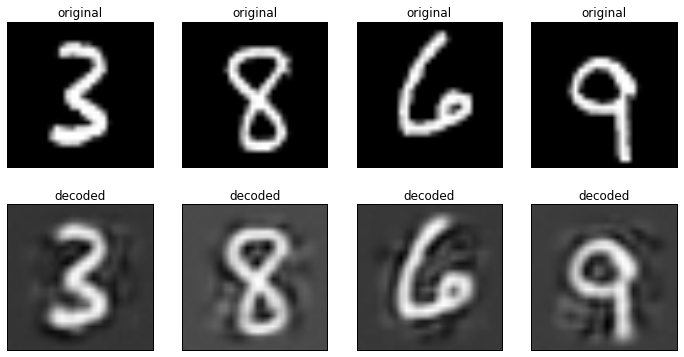

INFO:mlp.optimisers:Starting pretraining layer 1
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 1.633. Accuracy is 68.20%
INFO:mlp.optimisers:Epoch 1: Took 2 seconds. Training speed 25689 pps. 
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 1.009. Accuracy is 82.22%
INFO:mlp.optimisers:Epoch 2: Took 2 seconds. Training speed 24798 pps. 
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.794. Accuracy is 84.37%
INFO:mlp.optimisers:Epoch 3: Took 2 seconds. Training speed 26388 pps. 
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.686. Accuracy is 85.48%
INFO:mlp.optimisers:Epoch 4: Took 2 seconds. Training speed 25051 pps. 
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 0.621. Accuracy is 86.17%
INFO:mlp.optimisers:Epoch 5: Took 2 seconds. Training speed 24982 pps. 
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 0.576. Accuracy is 86.73%
INFO:mlp.optimisers:Epoch 6: Took 2 seconds. Training speed 25370 pps. 
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 0.544.

In [6]:
# %load auto_encoder_test
from mlp.dataset import MNISTDataProvider
from mlp.optimisers import Optimiser

tsk3_1_optimiser = Optimiser()
tsk3_1_model = create_one_hid_model()

def tsk_3_1_draw_handler(cur_layer_id, cur_model, get_inputs):
    if cur_layer_id != 0:
        return
    mnist_dp = MNISTDataProvider(dset='valid', batch_size=4, max_num_examples=4, randomize=False)
    for batch in mnist_dp:
        features, targets = batch

        inputs, pure = get_inputs(features)
        output_dc = cur_model.fprop(inputs)
        num_imgs = features.shape[0]
        imgs = features.reshape(num_imgs, 28, 28)
        #images decoded
        imgs_dc = output_dc.reshape(num_imgs, 28, 28)
        tot_imgs = np.concatenate((imgs, imgs_dc), axis=0)
        show_mnist_images(tot_imgs, 4, 3, ["original"] * 4 + ["decoded"] * 4)

tsk3_1_stats = tsk3_1_optimiser.pretrain(tsk3_1_model, train_dp_flat, 20, 0.05, draw_handler=tsk_3_1_draw_handler)



If you expand the log above you will find examples of images which autoencoder tried to decode (my drawer handler is located not in the best place inside the loops). Just to be sure that it is noticed I load this image here as well

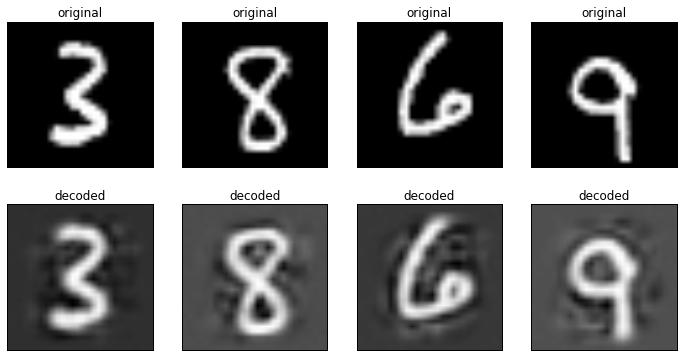

In [8]:
from IPython.display import Image
Image(filename='autoencoder_image.png')

In [ ]:
Hinton diagram of the hidden layer after pretraining

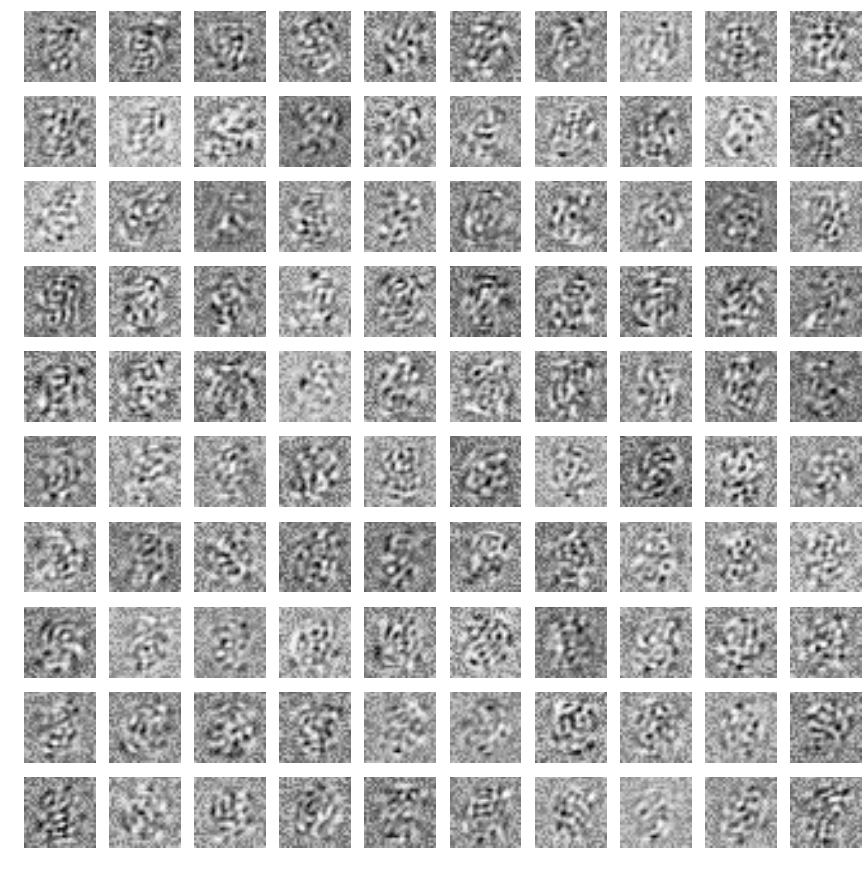

In [7]:
show_weight(tsk3_1_model.layers[0].W.T, (10, 10), (28, 28))

Let's compare these weights with the same model where weights are initialised randomly

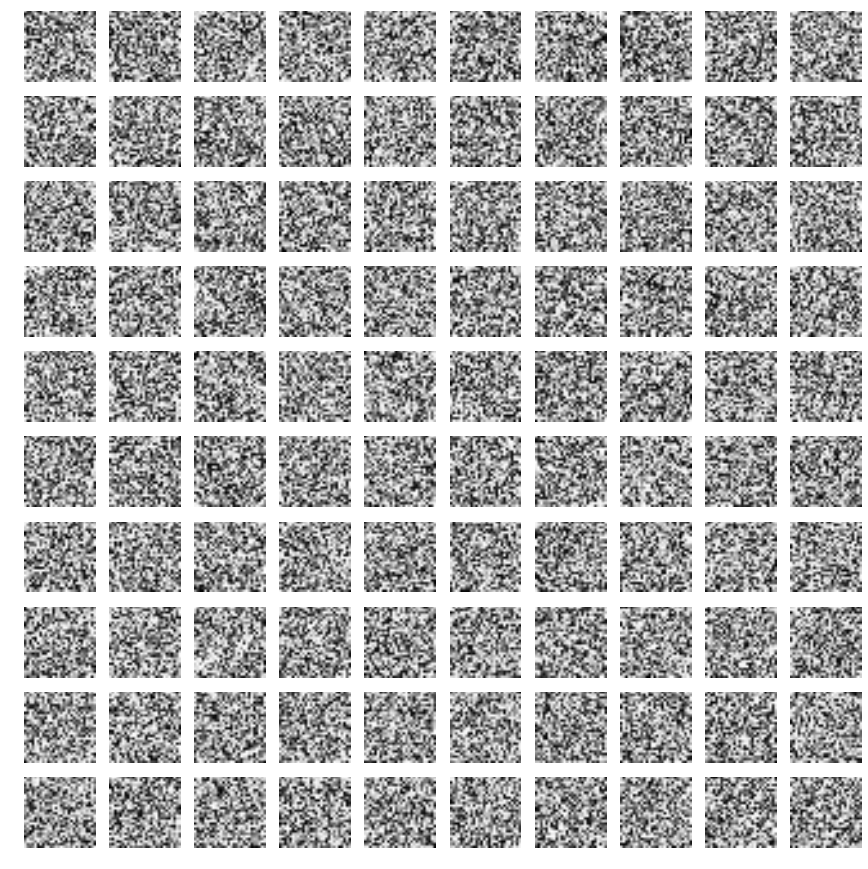

In [8]:
show_weight(create_one_hid_model().layers[0].W.T, (10, 10), (28, 28))

Through comparison it can be seen that definitely pretraining allows to learn some patterns about input

Let's see whether cost function converges for the hidden layer during pretraining or not

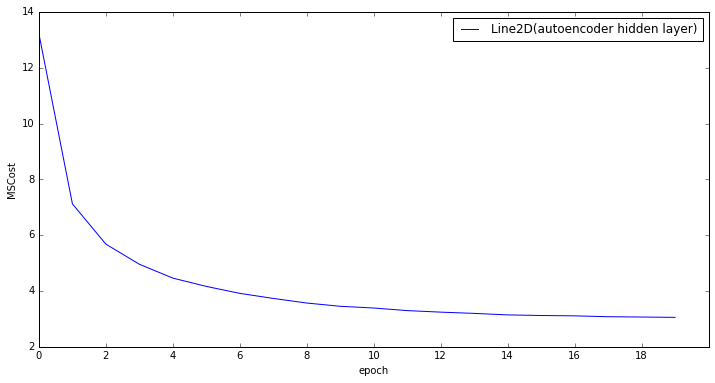

In [9]:
tsk3_1_cost = [epoch[0] for epoch in tsk3_1_stats[0]]
plot_error_cost([tsk3_1_cost], ["autoencoder hidden layer"], "MSCost", figsize=(12,6))

I smoothly declining during the pretraining which indicates that it converges.

Now let's try denoising autoencoder with the same parameters as in previous example but where only 90% of the input is preserved (noise level 10%)

INFO:mlp.optimisers:Starting pretraining layer 0
INFO:mlp.optimisers:Epoch 1: Training cost (mse) is 13.816. Accuracy is 1.25%
INFO:mlp.optimisers:Epoch 1: Took 8 seconds. Training speed 6395 pps. 
INFO:mlp.optimisers:Epoch 2: Training cost (mse) is 7.853. Accuracy is 1.32%
INFO:mlp.optimisers:Epoch 2: Took 7 seconds. Training speed 7013 pps. 
INFO:mlp.optimisers:Epoch 3: Training cost (mse) is 6.375. Accuracy is 1.29%
INFO:mlp.optimisers:Epoch 3: Took 7 seconds. Training speed 6805 pps. 
INFO:mlp.optimisers:Epoch 4: Training cost (mse) is 5.670. Accuracy is 1.31%
INFO:mlp.optimisers:Epoch 4: Took 7 seconds. Training speed 7365 pps. 
INFO:mlp.optimisers:Epoch 5: Training cost (mse) is 5.224. Accuracy is 1.50%
INFO:mlp.optimisers:Epoch 5: Took 7 seconds. Training speed 7466 pps. 
INFO:mlp.optimisers:Epoch 6: Training cost (mse) is 4.923. Accuracy is 1.28%
INFO:mlp.optimisers:Epoch 6: Took 7 seconds. Training speed 7360 pps. 
INFO:mlp.optimisers:Epoch 7: Training cost (mse) is 4.713. Acc

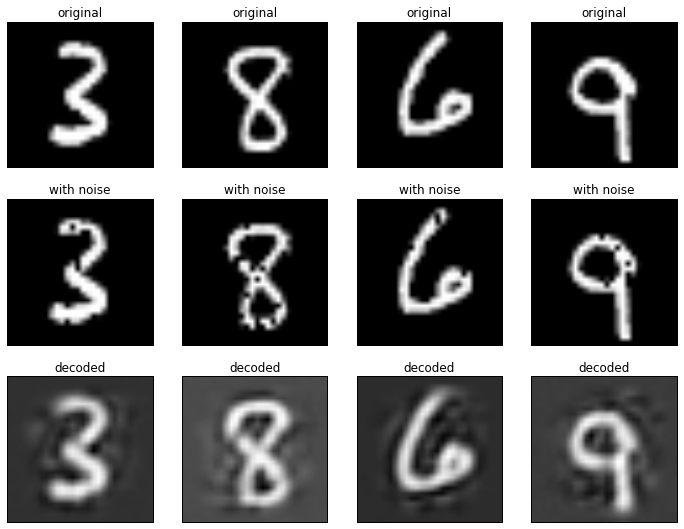

INFO:mlp.optimisers:Starting pretraining layer 1
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 1.698. Accuracy is 62.77%
INFO:mlp.optimisers:Epoch 1: Took 2 seconds. Training speed 32289 pps. 
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 1.118. Accuracy is 77.55%
INFO:mlp.optimisers:Epoch 2: Took 1 seconds. Training speed 35309 pps. 
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.910. Accuracy is 79.46%
INFO:mlp.optimisers:Epoch 3: Took 1 seconds. Training speed 35905 pps. 
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.809. Accuracy is 80.30%
INFO:mlp.optimisers:Epoch 4: Took 1 seconds. Training speed 35802 pps. 
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 0.749. Accuracy is 80.78%
INFO:mlp.optimisers:Epoch 5: Took 1 seconds. Training speed 35656 pps. 
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 0.709. Accuracy is 81.38%
INFO:mlp.optimisers:Epoch 6: Took 1 seconds. Training speed 35547 pps. 
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 0.677.

In [10]:
from mlp.optimisers import Optimiser
tsk3_2_optimiser = Optimiser()
tsk3_2_model = create_one_hid_model()

def tsk_3_2_draw_handler(cur_layer_id, cur_model, get_inputs):
    if cur_layer_id != 0:
        return
    mnist_dp = MNISTDataProvider(dset='valid', batch_size=4, max_num_examples=4, randomize=False)
    for batch in mnist_dp:
        features, targets = batch

        inputs, pure = get_inputs(features)
        output_dc = cur_model.fprop(inputs)
        num_imgs = features.shape[0]
        imgs = features.reshape(num_imgs, 28, 28)
        #images noisy
        imgs_ns = inputs.reshape(num_imgs, 28, 28)
        #images decoded
        imgs_dc = output_dc.reshape(num_imgs, 28, 28)
        tot_imgs = np.concatenate((imgs, imgs_ns, imgs_dc), axis=0)
        show_mnist_images(tot_imgs, 4, 3, ["original"] * 4 + ["with noise"] * 4 + ["decoded"] * 4)

tsk3_2_stats = tsk3_2_optimiser.pretrain_masking(tsk3_2_model, train_dp_flat, 20, 0.05, 0.9, draw_handler=tsk_3_2_draw_handler)

As in the previous example the picture is in the middle of the above log, so I duplicate it here just in case.

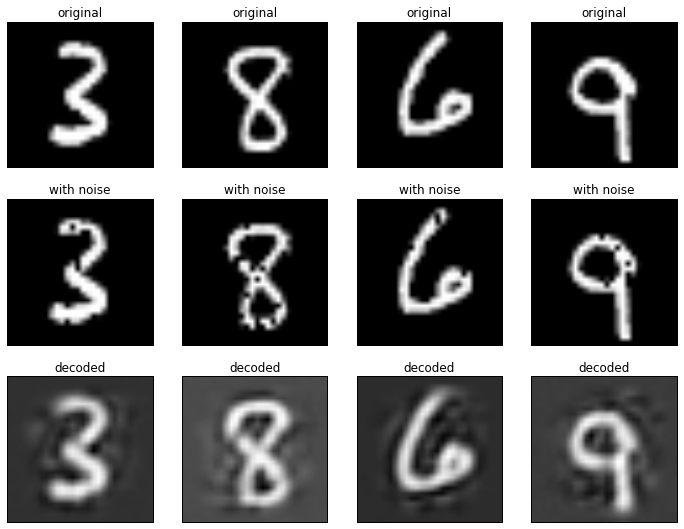

In [11]:
from IPython.display import Image
Image(filename='dn_autoencoder.png')

It can be seen that the noise doesn't affect the decoded image too much. 
Let's see its hinton diagrams.

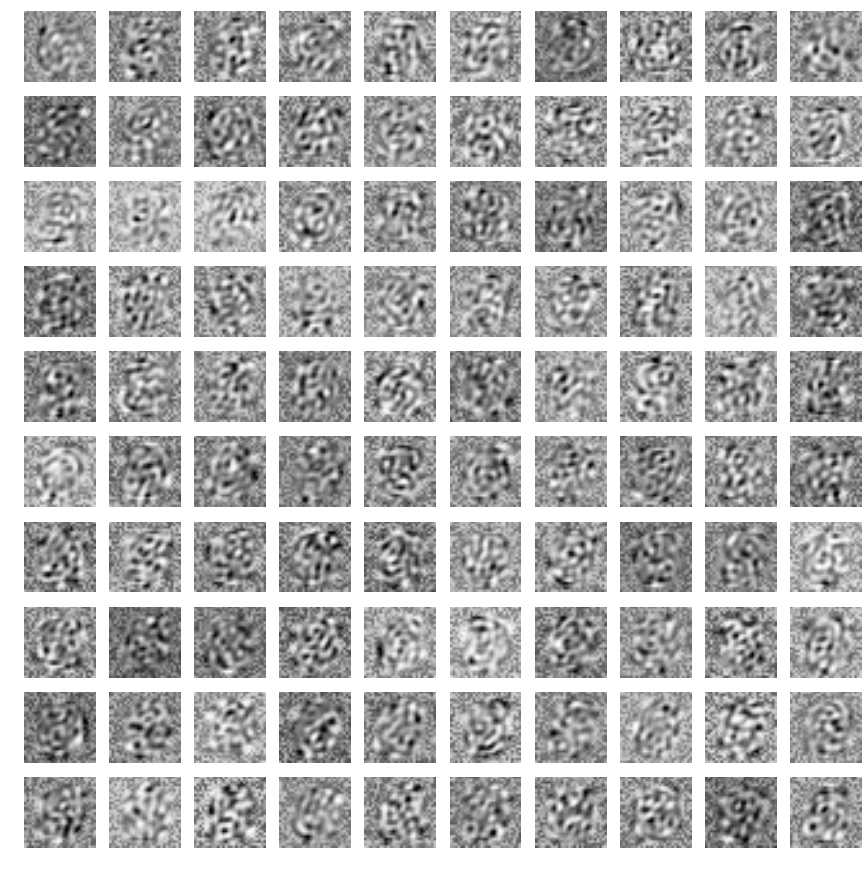

In [12]:
show_weight(tsk3_2_model.layers[0].W.T, (10, 10), (28, 28))

It is slightly more contrast in comparison to hinton diagram of the just autoencoder.

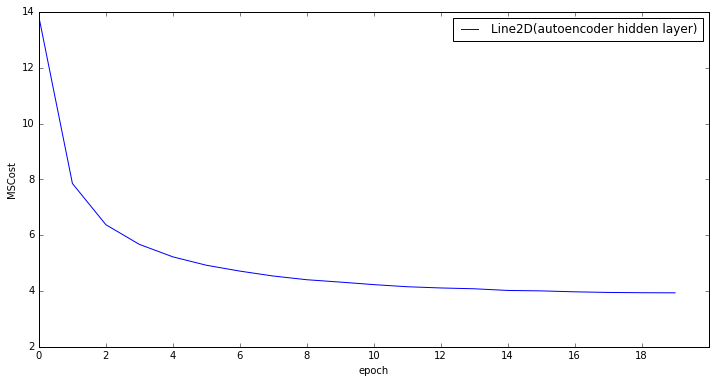

In [13]:
tsk3_2_cost = [epoch[0] for epoch in tsk3_2_stats[0]]
plot_error_cost([tsk3_2_cost], ["autoencoder hidden layer"], "MSCost", figsize=(12,6))

Finally let's train layer-by-layer cross-entropy, and then run all three models through the learning optimizer, to see how pretraining affects the final results

In [15]:
tsk3_3_optimiser = Optimiser()
tsk3_3_model = create_one_hid_model()
tsk3_3_stats = tsk3_3_optimiser.pretrain_discriminative(tsk3_3_model, train_dp_flat, 20, 0.05)

INFO:mlp.optimisers:Starting pretraining layer 0
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 1.651. Accuracy is 60.43%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 14006 pps. 
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.764. Accuracy is 82.80%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 17500 pps. 
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.536. Accuracy is 86.73%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training speed 16492 pps. 
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.447. Accuracy is 88.29%
INFO:mlp.optimisers:Epoch 4: Took 3 seconds. Training speed 17445 pps. 
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 0.400. Accuracy is 89.19%
INFO:mlp.optimisers:Epoch 5: Took 3 seconds. Training speed 16566 pps. 
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 0.371. Accuracy is 89.77%
INFO:mlp.optimisers:Epoch 6: Took 3 seconds. Training speed 17495 pps. 
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 0.351.

layer-by-layer cross-entropy hinton diagram

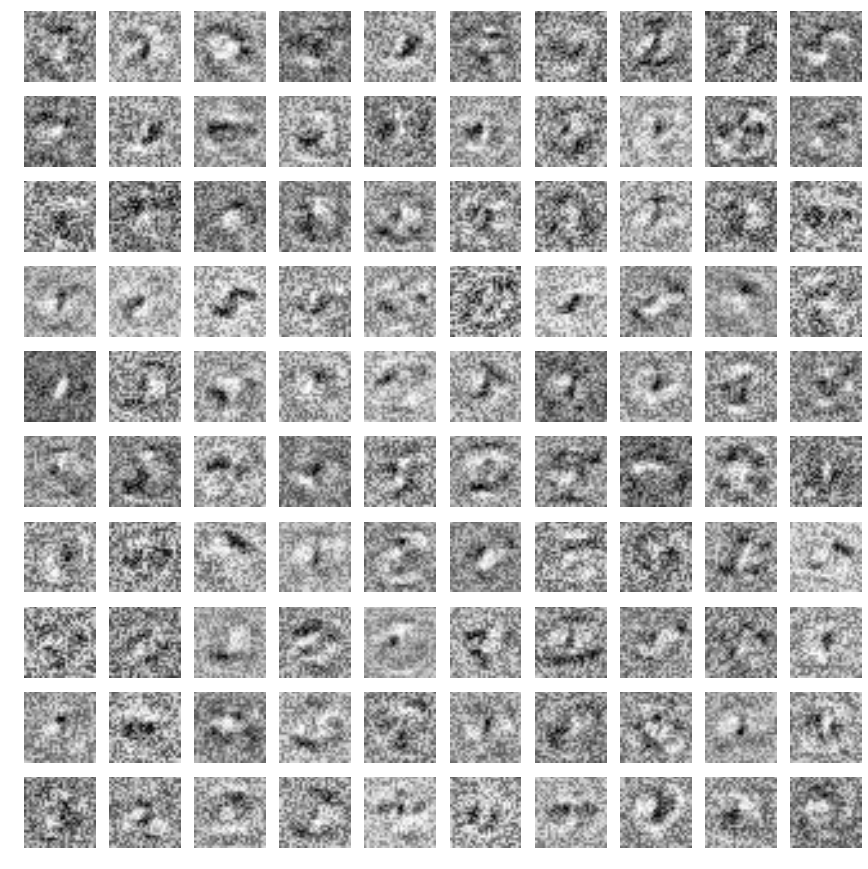

In [16]:
show_weight(tsk3_3_model.layers[0].W.T, (10, 10), (28, 28))

Definitely due to supervised learning the hinton diagram of layer-by-layer cross-entropy is very different from those of autoencoders. It is much more closer to hinton diagrams we achieved in the Course Work 1

In [17]:
LearningRate = 0.7
Num_epoches = 30

tsk3_4_jobs  = [
        {
            "model": tsk3_1_model,
            "label": "autoencoder",
            "lr_scheduler": LearningRateFixed(LearningRate, 30)
        },
        {
            "model": tsk3_2_model,
            "label": "denoising autoencoder",
            "lr_scheduler": LearningRateFixed(LearningRate, 30)
        },
        {
            "model": tsk3_3_model,
            "label": "layer-by-layer cross-entropy",
            "lr_scheduler": LearningRateFixed(LearningRate, 30)
        }
]

tsk3_4_stats = get_models_statistics(tsk3_4_jobs)

INFO:root:Reinitialising data providers..
INFO:root:Training started autoencoder ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 0.399. Accuracy is 89.18%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 0.365. Accuracy is 90.59%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.324. Accuracy is 90.63%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.204. Accuracy is 94.44%
INFO:mlp.optimisers:Epoch 1: Took 3 seconds. Training speed 15970 pps. Validation speed 38319 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.200. Accuracy is 94.26%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.164. Accuracy is 95.54%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 16236 pps. Validation speed 38184 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.156. Accuracy is 95.48%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.141. Accuracy is 96.15%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training spee

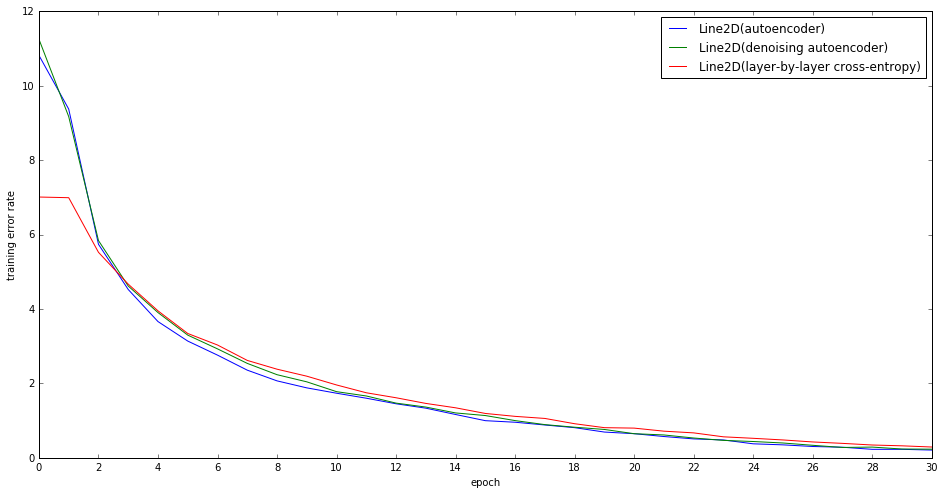

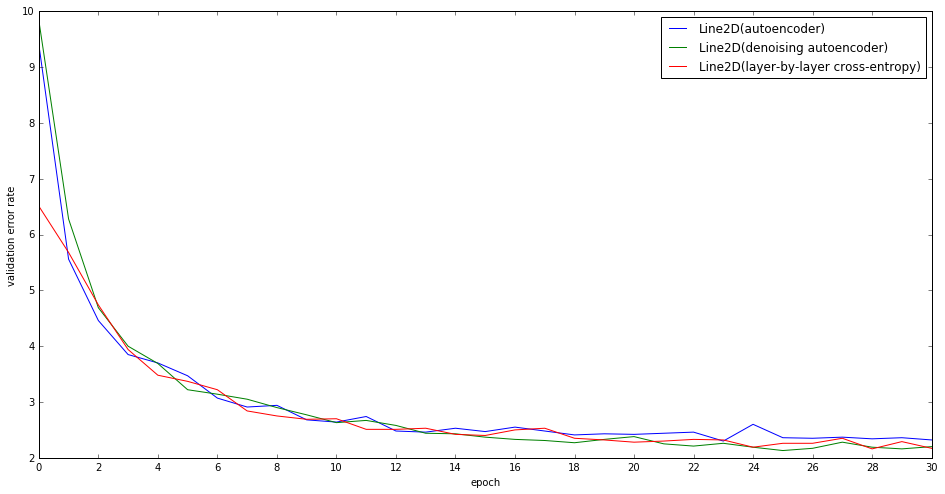

INFO:root:Testing the model autoencoder on test set:
INFO:root:MNIST test set accuracy is 97.71 % (cost is 0.076)
INFO:root:Testing the model denoising autoencoder on test set:
INFO:root:MNIST test set accuracy is 97.80 % (cost is 0.074)
INFO:root:Testing the model layer-by-layer cross-entropy on test set:
INFO:root:MNIST test set accuracy is 97.72 % (cost is 0.073)


final learning rates on the test data
model                         error rate                    
autoencoder                   2.29                          
denoising autoencoder         2.2                           
layer-by-layer cross-entropy  2.28                          


In [20]:
tsk3_4_tr_accrs = get_train_accuracies(tsk3_4_stats)
tsk3_4_vd_accrs = get_valid_accuracies(tsk3_4_stats)

#plotting
tsk3_4_labels = [ job["label"] for job in tsk3_4_jobs]
plot_error_rate(tsk3_4_tr_accrs, tsk3_4_vd_accrs, tsk3_4_labels, figsize=(16,8))

tsk3_4_test_stats = [test_model(job["model"], job["label"]) for job in tsk3_4_jobs]
tsk3_4_test_accrs = [test_stat[1] for test_stat in tsk3_4_test_stats ]
tsk3_4_labels = [ job["label"] for job in tsk3_4_jobs]
print "{:>16}".format("final learning rates on the test data")
print_test_error_rate(tsk3_4_test_accrs, tsk3_4_labels, padding=30)

#### Final results on the test data:
| Pretraining         | Error rate | Accuracy % |
| ------------- |:-------------:|:-------------:|  
| autoencoder                   |  2.29 |  97.71 |
| denoising autoencoder         |  2.20 |  97.80 |
| layer-by-layer cross-entropy  |  2.28 |  97.72

As we can see the starting error rate is much lower when we are using pretraining (below 12.0 in each case). The lowest value of error rate is achieved by layer-by-layer cross-entropy which is not suprising as it is example of supervisied learning. The best result was gained by the model which used denoising autoencoder for pretraining. On the test data it has error rate 2.2 or 97.8% accuracy which is slightly better then the model without pretraining with the error rate is 2.22 or 97.78% accuracy (the result of this model can be seen in part 1). Maybe it can be explained by robustness of denoising autoencoder.

In the course work 1 we used the neural network with 5 hidden layers and it learnt really slow. I want to check how pretraining can speed up this process. It has the same number of weights as model with one hidden layer with 800 hidden units. **It will also show how stacking works!**

In [27]:
tsk3_5_total_weights = count_total_num_weights(784, 10, 800, 1)
print "total number of weights {}".format(tsk3_5_total_weights)
print "total number of hidden units per layer for 5 hidden layers {}".format(int(count_num_hidden_units(784, 10, tsk3_5_total_weights, 5)))

total number of weights 636010.0
total number of hidden units per layer for 5 hidden layers 311


I use the same 20 epoches and learning rate 0.05 for pretraining.

In [31]:
tsk3_5_optimiser = Optimiser()
        
tsk3_5_model_pretr = create_many_hid_models(5, tsk3_5_total_weights)
tsk3_5_stat = tsk3_5_optimiser.pretrain(tsk3_5_model_pretr, train_dp_flat, 20, 0.05)

INFO:mlp.optimisers:Starting pretraining layer 0
INFO:mlp.optimisers:Epoch 1: Training cost (mse) is 23.624. Accuracy is 1.33%
INFO:mlp.optimisers:Epoch 1: Took 18 seconds. Training speed 2710 pps. 
INFO:mlp.optimisers:Epoch 2: Training cost (mse) is 11.158. Accuracy is 1.34%
INFO:mlp.optimisers:Epoch 2: Took 19 seconds. Training speed 2675 pps. 
INFO:mlp.optimisers:Epoch 3: Training cost (mse) is 7.617. Accuracy is 1.35%
INFO:mlp.optimisers:Epoch 3: Took 18 seconds. Training speed 2757 pps. 
INFO:mlp.optimisers:Epoch 4: Training cost (mse) is 6.212. Accuracy is 1.33%
INFO:mlp.optimisers:Epoch 4: Took 18 seconds. Training speed 2769 pps. 
INFO:mlp.optimisers:Epoch 5: Training cost (mse) is 5.437. Accuracy is 1.30%
INFO:mlp.optimisers:Epoch 5: Took 18 seconds. Training speed 2812 pps. 
INFO:mlp.optimisers:Epoch 6: Training cost (mse) is 4.897. Accuracy is 1.38%
INFO:mlp.optimisers:Epoch 6: Took 18 seconds. Training speed 2776 pps. 
INFO:mlp.optimisers:Epoch 7: Training cost (mse) is 4.5

In [32]:
LearningRate = 0.7
Num_epoches = 30

tsk3_6_jobs  = [
        {
            "model": create_many_hid_models(5, tsk3_5_total_weights),
            "label": "5 hid. layers",
            "lr_scheduler": LearningRateFixed(LearningRate, 30)
        },
        {
            "model": tsk3_5_model_pretr,
            "label": "pretrained with 5 hid. layers",
            "lr_scheduler": LearningRateFixed(LearningRate, 30)
        }
]

tsk3_6_stats = get_models_statistics(tsk3_6_jobs)

INFO:root:Reinitialising data providers..
INFO:root:Training started 5 hid. layers ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.441. Accuracy is 9.68%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.438. Accuracy is 10.09%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.338. Accuracy is 10.81%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.304. Accuracy is 10.64%
INFO:mlp.optimisers:Epoch 1: Took 24 seconds. Training speed 2169 pps. Validation speed 7588 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.303. Accuracy is 10.77%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 2.305. Accuracy is 10.64%
INFO:mlp.optimisers:Epoch 2: Took 23 seconds. Training speed 2255 pps. Validation speed 7601 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 2.303. Accuracy is 11.24%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 2.302. Accuracy is 10.64%
INFO:mlp.optimisers:Epoch 3: Took 24 seconds. Training spee

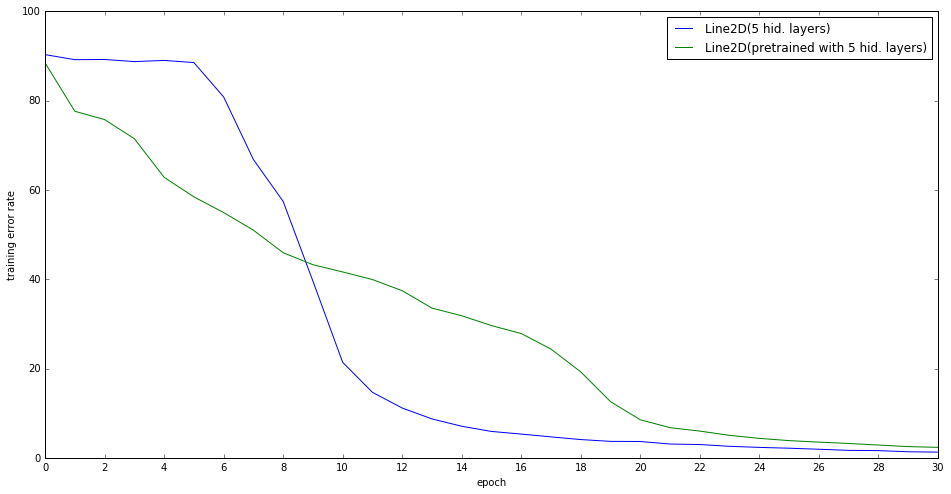

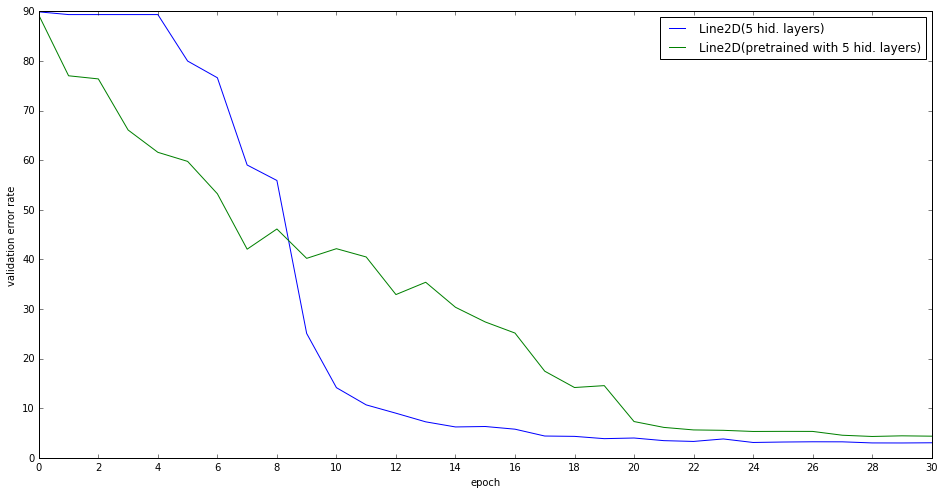

INFO:root:Testing the model 5 hid. layers on test set:
INFO:root:MNIST test set accuracy is 96.79 % (cost is 0.123)
INFO:root:Testing the model pretrained with 5 hid. layers on test set:
INFO:root:MNIST test set accuracy is 95.46 % (cost is 0.266)


final learning rates on the test data
model                         error rate                    
5 hid. layers                 3.21                          
pretrained with 5 hid. layers 4.54                          


In [33]:
tsk3_6_tr_accrs = get_train_accuracies(tsk3_6_stats)
tsk3_6_vd_accrs = get_valid_accuracies(tsk3_6_stats)

#plotting
tsk3_6_labels = [ job["label"] for job in tsk3_6_jobs]
plot_error_rate(tsk3_6_tr_accrs, tsk3_6_vd_accrs, tsk3_6_labels, figsize=(16,8))

tsk3_6_test_stats = [test_model(job["model"], job["label"]) for job in tsk3_6_jobs]
tsk3_6_test_accrs = [test_stat[1] for test_stat in tsk3_6_test_stats ]
tsk3_6_labels = [ job["label"] for job in tsk3_6_jobs]
print "{:>16}".format("final learning rates on the test data")
print_test_error_rate(tsk3_6_test_accrs, tsk3_6_labels, padding=30)

#### Final results on the test data:
| Model        | Error rate | Accuracy % |
| ------------- |:-------------:|:-------------:| 
| 5 hidden layers without pretraining                   |  3.21 | 96.79 |
| 5 hidden layers with autoencoder pretraining          |  4.54 | 95.46 |

The plots are quite interesting. At the beginning pretrained model showed better results. However on 9th epoch usual model dropped suddenly and till the end of the training it showed better results. Also note, that especially on the training data pretrained model error rated declined with almost constant rate. But this was unsupervised pretraining. Let's try supervised one with the learning rate 0.5

In [34]:
tsk3_7_optimiser = Optimiser()
        
tsk3_7_model_pretr = create_many_hid_models(5, tsk3_5_total_weights)
tsk3_7_stat = tsk3_7_optimiser.pretrain_discriminative(tsk3_7_model_pretr, train_dp_flat, 20, 0.5)

LearningRate = 0.7
Num_epoches = 30

tsk3_8_jobs  = [
        {
            "model": create_many_hid_models(5, tsk3_5_total_weights),
            "label": "5 hid. layers",
            "lr_scheduler": LearningRateFixed(LearningRate, 30)
        },
        {
            "model": tsk3_7_model_pretr,
            "label": "pretrained supervised with 5 hid. layers",
            "lr_scheduler": LearningRateFixed(LearningRate, 30)
        }
]

tsk3_8_stats = get_models_statistics(tsk3_8_jobs)

INFO:mlp.optimisers:Starting pretraining layer 0
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.582. Accuracy is 84.06%
INFO:mlp.optimisers:Epoch 1: Took 8 seconds. Training speed 6300 pps. 
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.298. Accuracy is 91.18%
INFO:mlp.optimisers:Epoch 2: Took 7 seconds. Training speed 6803 pps. 
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.251. Accuracy is 92.66%
INFO:mlp.optimisers:Epoch 3: Took 8 seconds. Training speed 6441 pps. 
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.214. Accuracy is 93.67%
INFO:mlp.optimisers:Epoch 4: Took 8 seconds. Training speed 6557 pps. 
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 0.185. Accuracy is 94.55%
INFO:mlp.optimisers:Epoch 5: Took 8 seconds. Training speed 6464 pps. 
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 0.163. Accuracy is 95.19%
INFO:mlp.optimisers:Epoch 6: Took 7 seconds. Training speed 6797 pps. 
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 0.144. Accur

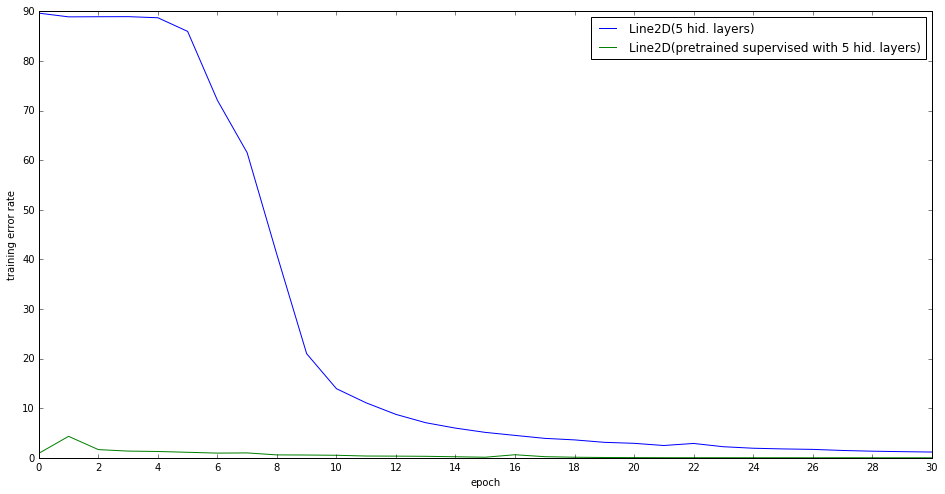

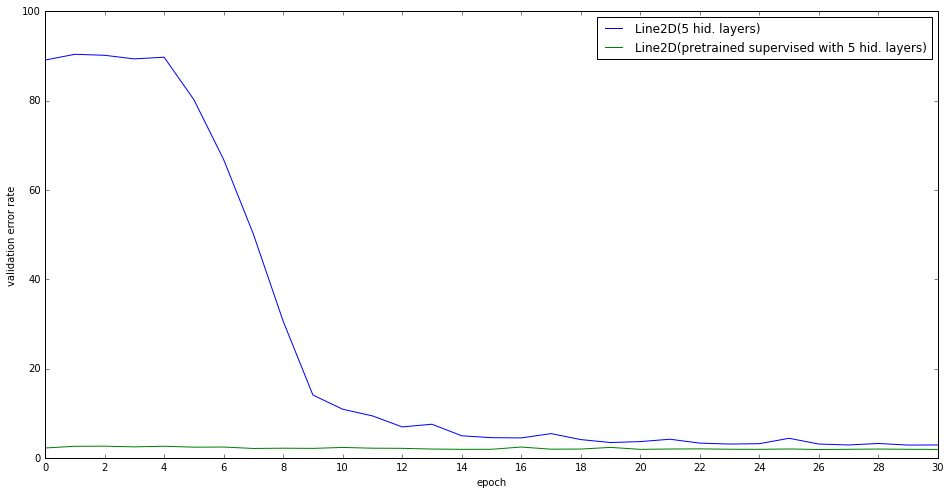

INFO:root:Testing the model 5 hid. layers on test set:
INFO:root:MNIST test set accuracy is 96.90 % (cost is 0.121)
INFO:root:Testing the model pretrained supervised with 5 hid. layers on test set:
INFO:root:MNIST test set accuracy is 98.17 % (cost is 0.093)


final learning rates on the test data
model                                        error rate                                   
5 hid. layers                                3.1                                          
pretrained supervised with 5 hid. layers     1.83                                         


In [37]:
tsk3_8_tr_accrs = get_train_accuracies(tsk3_8_stats)
tsk3_8_vd_accrs = get_valid_accuracies(tsk3_8_stats)

#plotting
tsk3_8_labels = [ job["label"] for job in tsk3_8_jobs]
plot_error_rate(tsk3_8_tr_accrs, tsk3_8_vd_accrs, tsk3_8_labels, figsize=(16,8))

tsk3_8_test_stats = [test_model(job["model"], job["label"]) for job in tsk3_8_jobs]
tsk3_8_test_accrs = [test_stat[1] for test_stat in tsk3_8_test_stats ]
tsk3_8_labels = [ job["label"] for job in tsk3_8_jobs]
print "{:>16}".format("final learning rates on the test data")
print_test_error_rate(tsk3_8_test_accrs, tsk3_8_labels, padding=45)

#### Final results on the test data:
| Model        | Error rate | Accuracy % |
| ------------- |:-------------:|:-------------:|
| 5 hidden layers without pretraining                   |  3.10 | 96.90 |
| 5 hidden layers with supervised pretraining           |  1.83 | 98.17 |

Here we see actual improvement (98.17% accuracy or 1.83 error rate). It is one of the best model I have seen so far! Pretraining allowed to converge it almost instantly. Probably the primal reason for that supervised pretraining lasted 20 epoches for each layer and that is why this deep network has more opportunities to learn, and more importantly all hidden layers have the same number of hidden units, and probably stacking can happen more easily. 
The interesting thing to try is to use less number of training epoches and see how it will affect the final performance. But it takes too much CPU time to experiment with.

### Task 4 - Experiments with data augmentation (5 marks)

Using the standard MNIST training data, generate some augmented training examples (for example, using noise or rotation). Perform experiments on using this expanded training data.

### Note the comment on the NB:
can we use scipy for rotation?? I implemented my own rotation function using einstens sumation convention to map through the tensors efficiently yet I cant effciently carry out an interpolation algorithm thus the images get extremely distorted for rotations of degrees in between -30 and 30 .
francisco vargas – 2 Jan, 01:16PM
 
···
Yes you can.
Pawel Swietojanski  – 4 Jan, 12:51PM

I augment data only when data provider is initialised in order to calculate heavy data transformations only once. Here I have 3 different types of augmentation: noise, rotations (via scipy), shifts (scipy). All of them is done via static methods and controlled via noise_param.

In [8]:
# %load -s MNISTDataProviderNoisy mlp/dataset
class MNISTDataProviderNoisy(MNISTDataProvider):
    """
    The class iterates over MNIST digits dataset, in possibly
    random order.
    """

    @staticmethod
    def apply_noise(img, noise_ratio=0):
        """
        add uniform noise to the image
        :img: 1D array of size 784 (MNIST Image)
        :noise_raito: the number of randomly selected cells where noise added between 0 and 784

        Usage/Doctest:
        >>> img = numpy.arange(784)
        >>> img_ns = MNISTDataProviderNoisy.apply_noise(img, int(784 * 0.1))
        >>> (img == img_ns).all() #although there is extremely low chance that they will match
        False
        >>> img.shape == img_ns.shape
        True
        """
        noise_amnt = int(784 * noise_ratio)
        img_ns = numpy.copy(img)
        noise = numpy.random.rand(noise_amnt)
        #random pixels
        rnd_px = numpy.random.permutation(784)
        rnd_px = rnd_px[0:noise_amnt]
        img_ns[rnd_px] = noise
        return img_ns

    @staticmethod
    def apply_rotation(img, max_rot=0.0):
        from scipy import ndimage
        img_ns = img.reshape(28, 28)
        #between -max_rot, +max_rot
        rnd_ang = 2*max_rot * numpy.random.random_sample() - max_rot
        img_rt = ndimage.interpolation.rotate(img_ns, angle=rnd_ang, reshape=False)
        return img_rt.reshape(28*28)

    @staticmethod
    def apply_shift(img, max_shift=0.0):
        from scipy import ndimage
        img_ns = img.reshape(28, 28)
        #between -max_shift, +max_shift
        rnd_x = 2*max_shift * numpy.random.random_sample() - max_shift
        rnd_y = 2*max_shift * numpy.random.random_sample() - max_shift
        img_sht = ndimage.interpolation.shift(img_ns, shift=(rnd_x, rnd_y))
        return img_sht.reshape(28*28)


    def __init__(self, dset,
                 num_of_gen_data = 0,
                 noise_param = 0,
                 noise_fun = apply_noise,
                 batch_size=10,
                 max_num_batches=-1,
                 max_num_examples=-1,
                 rng=None,
                 conv_reshape=False):

        self.name = "Noisy data provider"

        assert dset == "train", (
            "Noise is applied only to the training data"
        )

        super(MNISTDataProviderNoisy, self).\
            __init__(dset,
                     batch_size=batch_size,
                     max_num_batches=max_num_batches,
                     max_num_examples=max_num_examples,
                     randomize=True,
                     rng=rng,
                     conv_reshape=conv_reshape)

        assert num_of_gen_data >= 0, (
            "The number of generated data must be equal or above 0"
        )

        #selecting random images from original data
        rnd_ids = numpy.random.randint(low=0, high=self.x.shape[0], size=num_of_gen_data)

        noisy_x = numpy.zeros((num_of_gen_data, self.x.shape[1]))#numpy.copy(self.x[rnd_ids])
        noisy_t = numpy.copy(self.t[rnd_ids])


        for ns_id, rnd_id in enumerate(rnd_ids):
            noisy_x[ns_id] = noise_fun(self.x[rnd_id], noise_param)

        #mixing original and noisy data
        self.x = numpy.concatenate((self.x, noisy_x), axis=0)
        self.t = numpy.concatenate((self.t, noisy_t), axis=0)

        #mix the data, reset rand_idx
        self._rand_idx = None
        self.reset()


These are examples of pictures which are corrupted to a different stage due to the noise. They have different amount of noise controlled by noise ratio parameter which is between 0 and 1 where 0 is no noise and 1 is complete mess

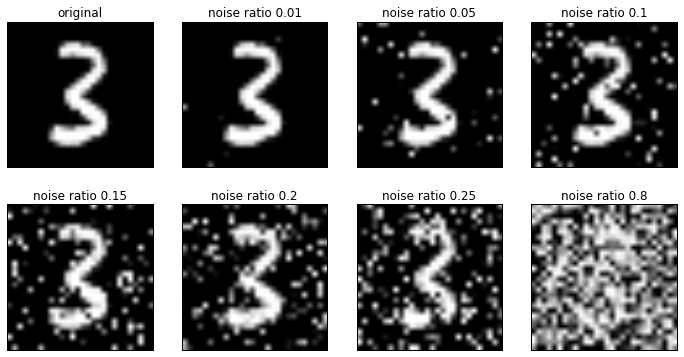

In [25]:
dataset%matplotlib inline
from mlp.dataset import MNISTDataProviderNoisy
def show_noise():
    mnist_dp = MNISTDataProvider(dset='valid', batch_size=1, max_num_examples=1, randomize=False)
    for batch in mnist_dp:
        features, targets = batch
        noise_ratios = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.8]
        apply_ns = MNISTDataProviderNoisy.apply_noise
        imgs_ns = np.array([apply_ns(features[0], nr) for nr in noise_ratios])
        tot_imgs = np.concatenate((features, imgs_ns), axis=0)
        tot_imgs = tot_imgs.reshape(tot_imgs.shape[0], 28, 28)
        show_mnist_images(tot_imgs, 4, 3, ["original"] + ["noise ratio " + str(nr) for nr in noise_ratios])
    
show_noise()

The last images are corrupted too much, let's investigate noise affect on the learning process for the  0.05, 0.10, 0.15, 0.2, 0.25 noise ratios. The amount of noisy data generated will be the same as original one (50000) so totally there will be 100000 training examples

In [29]:
LearningRate = 0.7
Num_epoches = 30
num_of_gen_data = 50000
noise_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
tsk4_1_jobs  = []
for nr in noise_ratios:
    logger.info("augmenting data")
    train_dp = MNISTDataProviderNoisy(dset='train', 
                                      num_of_gen_data=num_of_gen_data,
                                      noise_param=nr,
                                      noise_fun=MNISTDataProviderNoisy.apply_noise,
                                      batch_size=100,
                                      max_num_batches=-10)
    logger.info("augmenting is over")
    tsk4_1_jobs.append(
        {
            "model": create_one_hid_model(),
            "label": "noise ratio={}".format(nr),
            "lr_rate": LearningRate,
            "max_epochs": Num_epoches,
            "train_dp": train_dp
        }
    )

tsk4_1_stats = get_models_statistics(tsk4_1_jobs)

INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:Reinitialising data providers..
INFO:root:Training started noise ratio=0.05 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.348. Accuracy is 9.66%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.345. Accuracy is 9.83%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.394. Accuracy is 88.28%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.207. Accuracy is 94.15%
INFO:mlp.optimisers:Epoch 1: Took 8 seconds. Training speed 12863 pps. Validation speed 37703 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.191. Accuracy is 94.44%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.152. Accuracy is 95.86%
INFO:mlp.optimisers:Epoch 2: Took 8

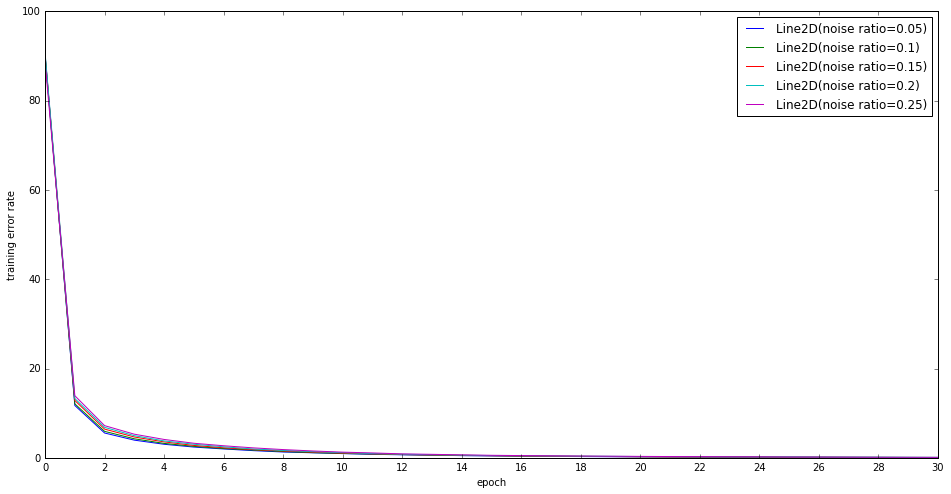

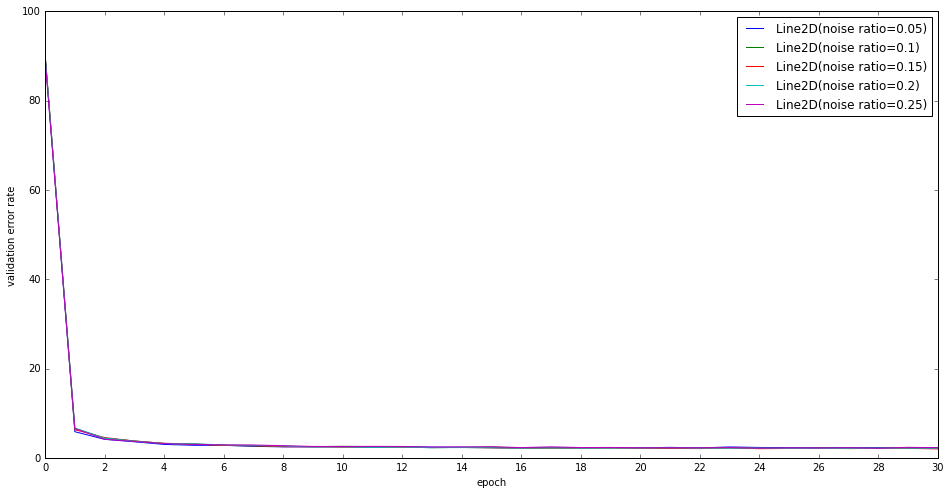

INFO:root:Testing the model noise ratio=0.05 on test set:
INFO:root:MNIST test set accuracy is 97.76 % (cost is 0.077)
INFO:root:Testing the model noise ratio=0.1 on test set:
INFO:root:MNIST test set accuracy is 97.78 % (cost is 0.074)
INFO:root:Testing the model noise ratio=0.15 on test set:
INFO:root:MNIST test set accuracy is 97.97 % (cost is 0.072)
INFO:root:Testing the model noise ratio=0.2 on test set:
INFO:root:MNIST test set accuracy is 97.89 % (cost is 0.078)
INFO:root:Testing the model noise ratio=0.25 on test set:
INFO:root:MNIST test set accuracy is 97.88 % (cost is 0.074)


final learning rates on the test data, with initial learning rate 0.7
model                         error rate                    
noise ratio=0.05              2.24                          
noise ratio=0.1               2.22                          
noise ratio=0.15              2.03                          
noise ratio=0.2               2.11                          
noise ratio=0.25              2.12                          


In [30]:
%matplotlib inline
tsk4_1_tr_accrs = get_train_accuracies(tsk4_1_stats)
tsk4_1_vd_accrs = get_valid_accuracies(tsk4_1_stats)

#plotting
tsk4_1_labels = [ job["label"] for job in tsk4_1_jobs]
plot_error_rate(tsk4_1_tr_accrs, tsk4_1_vd_accrs, tsk4_1_labels,figsize=(16,8))

tsk4_1_test_stats = [test_model(job["model"], job["label"]) for job in tsk4_1_jobs]
tsk4_1_test_accrs = [test_stat[1] for test_stat in tsk4_1_test_stats ]
tsk4_1_labels = [ job["label"] for job in tsk4_1_jobs]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk4_1_test_accrs, tsk4_1_labels, padding=30)

#### Final results on the test data with the augmented dataset (100000 instances):
| Noise ratio       | Error rate | Accuracy % |
|:-------------:|:-------------:|:-------------:| 
| 0.05          |  2.24 |  97.76 |
| 0.10          |  2.22 |  97.78 |
| 0.15          |  2.03 |  97.97 |
| 0.20          |  2.11 |  97.89 |
| 0.25          |  2.12 |  97.88 |

The result with small amount of noise (0.01) has absolutely the same result as model without noise at all (error rate 2.22). Here the best result of 2.03 error rate (97.97% accuracy) is achieved with 0.15 amount of noise. Also note that after first epoch the validation error rate converges really quickly (error rates become below 10%), that probably due to the bigger datasize

Now let's try rotations (rotations are in degress and I set only maximum possible angle of rotation, the rotation is possible in both directions)

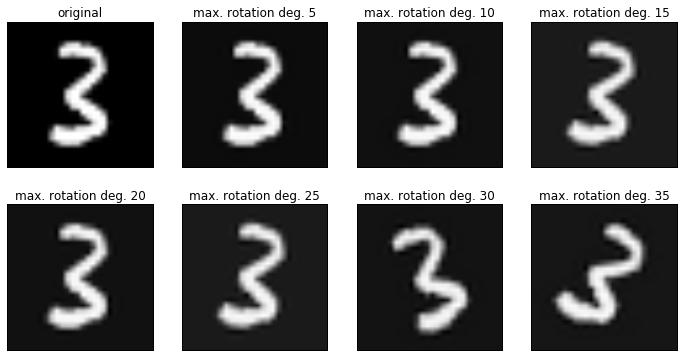

In [33]:
def show_rotations():
    mnist_dp = MNISTDataProvider(dset='valid', batch_size=1, max_num_examples=1, randomize=False)
    for batch in mnist_dp:
        features, targets = batch
        max_rots = [5, 10, 15, 20, 25, 30, 35]
        apply_mr = MNISTDataProviderNoisy.apply_rotation
        imgs_ns = np.array([apply_mr(features[0], mr) for mr in max_rots])
        tot_imgs = np.concatenate((features, imgs_ns), axis=0)
        tot_imgs = tot_imgs.reshape(tot_imgs.shape[0], 28, 28)
        show_mnist_images(tot_imgs, 4, 3, ["original"] + ["max. rotation deg. " + str(nr) for nr in max_rots])
    
show_rotations()

5 degrees are very small angle, so I will try values from 10 to 30 degrees with step 5

In [34]:
LearningRate = 0.7
Num_epoches = 30
num_of_gen_data = 50000
max_rots = [10, 15, 20, 25, 30]
tsk4_2_jobs  = []
for mt in max_rots:
    logger.info("augmenting data")
    train_dp = MNISTDataProviderNoisy(dset='train', 
                                      num_of_gen_data=num_of_gen_data,
                                      noise_param=mt,
                                      noise_fun=MNISTDataProviderNoisy.apply_rotation,
                                      batch_size=100,
                                      max_num_batches=-10)
    logger.info("augmenting is over")
    tsk4_2_jobs.append(
        {
            "model": create_one_hid_model(),
            "label": "max. rotation={}".format(mt),
            "lr_rate": LearningRate,
            "max_epochs": Num_epoches,
            "train_dp": train_dp
        }
    )

tsk4_2_stats = get_models_statistics(tsk4_2_jobs)

INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:Reinitialising data providers..
INFO:root:Training started max. rotation=10 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.332. Accuracy is 12.31%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.335. Accuracy is 12.20%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.396. Accuracy is 88.25%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.207. Accuracy is 94.08%
INFO:mlp.optimisers:Epoch 1: Took 7 seconds. Training speed 15554 pps. Validation speed 41513 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.192. Accuracy is 94.34%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.146. Accuracy is 95.87%
INFO:mlp.optimisers:Epoch 2: Took

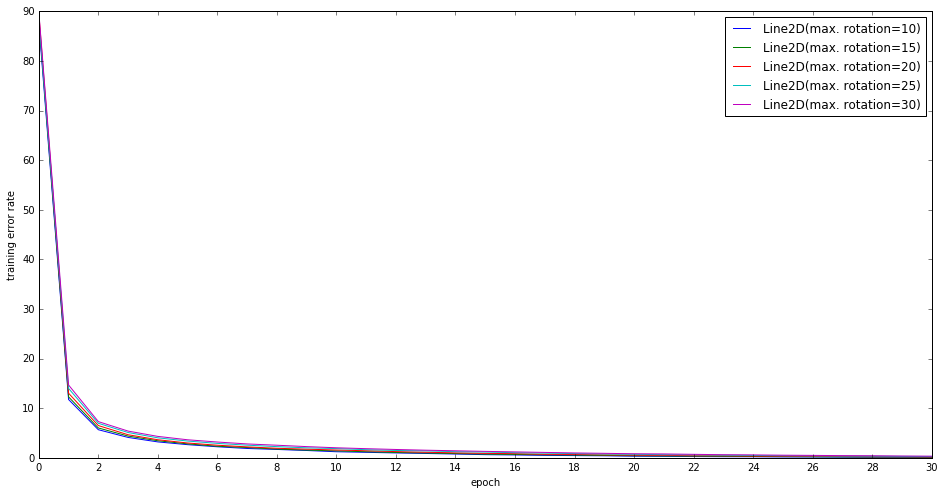

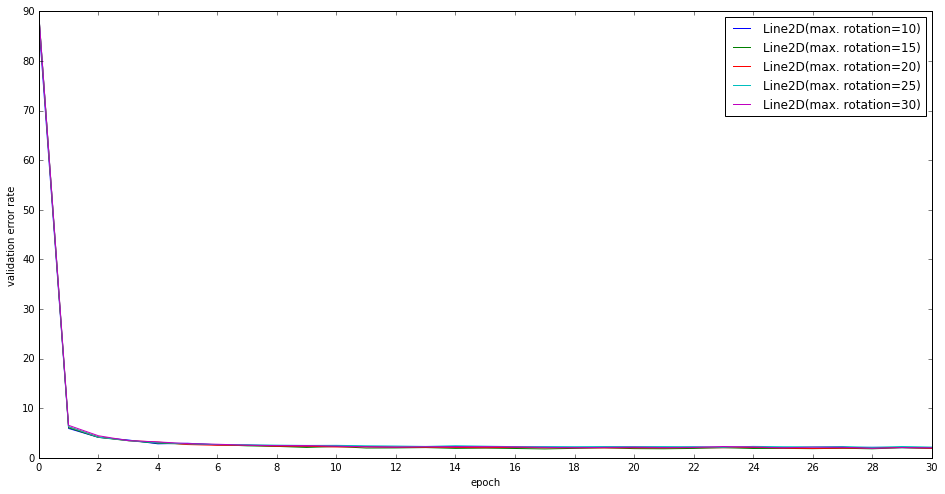

INFO:root:Testing the model max. rotation=10 on test set:
INFO:root:MNIST test set accuracy is 97.96 % (cost is 0.066)
INFO:root:Testing the model max. rotation=15 on test set:
INFO:root:MNIST test set accuracy is 98.02 % (cost is 0.067)
INFO:root:Testing the model max. rotation=20 on test set:
INFO:root:MNIST test set accuracy is 98.02 % (cost is 0.066)
INFO:root:Testing the model max. rotation=25 on test set:
INFO:root:MNIST test set accuracy is 98.11 % (cost is 0.059)
INFO:root:Testing the model max. rotation=30 on test set:
INFO:root:MNIST test set accuracy is 97.84 % (cost is 0.072)


final learning rates on the test data, with initial learning rate 0.7
model                         error rate                    
max. rotation=10              2.04                          
max. rotation=15              1.98                          
max. rotation=20              1.98                          
max. rotation=25              1.89                          
max. rotation=30              2.16                          


In [35]:
tsk4_2_tr_accrs = get_train_accuracies(tsk4_2_stats)
tsk4_2_vd_accrs = get_valid_accuracies(tsk4_2_stats)

#plotting
tsk4_2_labels = [ job["label"] for job in tsk4_2_jobs]
plot_error_rate(tsk4_2_tr_accrs, tsk4_2_vd_accrs, tsk4_2_labels,figsize=(16,8))

tsk4_2_test_stats = [test_model(job["model"], job["label"]) for job in tsk4_2_jobs]
tsk4_2_test_accrs = [test_stat[1] for test_stat in tsk4_2_test_stats ]
tsk4_2_labels = [ job["label"] for job in tsk4_2_jobs]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk4_2_test_accrs, tsk4_2_labels, padding=30)

#### Final results on the test data with the augmented dataset (100000 instances):
| Maximum rotation in degrees (in both directions) | Error rate | Accuracy %|
|:-------------:|:-------------:|:-------------:| 
| 10          |  2.04 | 97.96 |
| 15          |  1.98 | 98.02 |
| 20          |  1.98 | 98.02 |
| 25          |  1.89 | 98.11 |
| 30          |  2.16 | 97.84 |

Rotations seems to be very effective! In the best case we maximum rotations of 25 degrees, we have very good error rate 1.89 (98.11% accuracy). Also note in the 1st epoch validation error rate is around 5 which is very good convergence.

Finally, let's see extra augmentation - shifts. They are set in the maximum px.

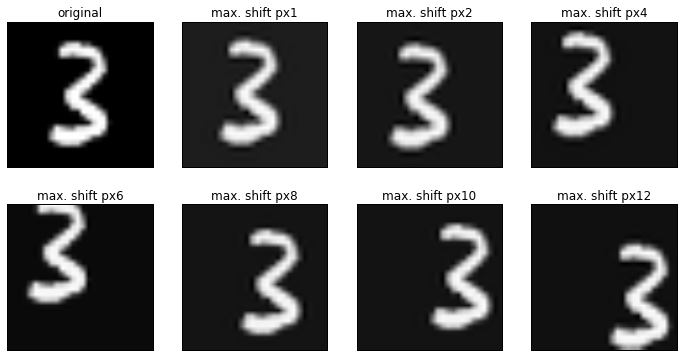

In [39]:
def show_shifts():
    mnist_dp = MNISTDataProvider(dset='valid', batch_size=1, max_num_examples=1, randomize=False)
    for batch in mnist_dp:
        features, targets = batch
        shifts = [1, 2, 4, 6, 8, 10, 12]
        apply_st = MNISTDataProviderNoisy.apply_shift
        imgs_ns = np.array([apply_st(features[0], st) for st in shifts])
        tot_imgs = np.concatenate((features, imgs_ns), axis=0)
        tot_imgs = tot_imgs.reshape(tot_imgs.shape[0], 28, 28)
        show_mnist_images(tot_imgs, 4, 3, ["original"] + ["max. shift px" + str(st) for st in shifts])
    
show_shifts()

I have chosen maximum shift of [1, 2, 4, 6, 8] px

In [40]:
LearningRate = 0.7
Num_epoches = 30
num_of_gen_data = 50000
max_shifts = [1, 2, 4, 6, 8]
tsk4_3_jobs  = []
for ms in max_shifts:
    logger.info("augmenting data")
    train_dp = MNISTDataProviderNoisy(dset='train', 
                                      num_of_gen_data=num_of_gen_data,
                                      noise_param=ms,
                                      noise_fun=MNISTDataProviderNoisy.apply_shift,
                                      batch_size=100,
                                      max_num_batches=-10)
    logger.info("augmenting is over")
    tsk4_3_jobs.append(
        {
            "model": create_one_hid_model(),
            "label": "max. shift px={}".format(ms),
            "lr_rate": LearningRate,
            "max_epochs": Num_epoches,
            "train_dp": train_dp
        }
    )

tsk4_3_stats = get_models_statistics(tsk4_3_jobs)

INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:augmenting data
INFO:root:augmenting is over
INFO:root:Reinitialising data providers..
INFO:root:Training started max. shift px=1 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.374. Accuracy is 9.11%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.372. Accuracy is 8.93%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.438. Accuracy is 86.92%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.215. Accuracy is 93.94%
INFO:mlp.optimisers:Epoch 1: Took 7 seconds. Training speed 14941 pps. Validation speed 38591 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.218. Accuracy is 93.64%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.147. Accuracy is 95.91%
INFO:mlp.optimisers:Epoch 2: Took 7 

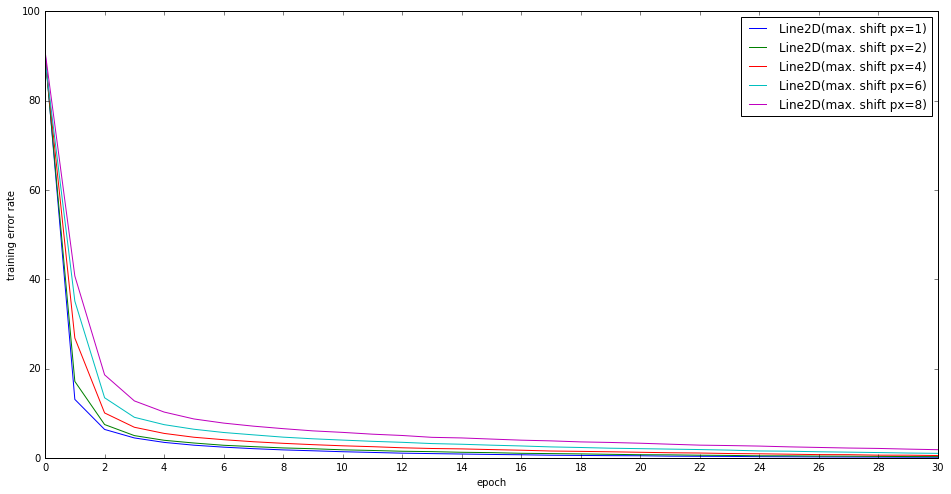

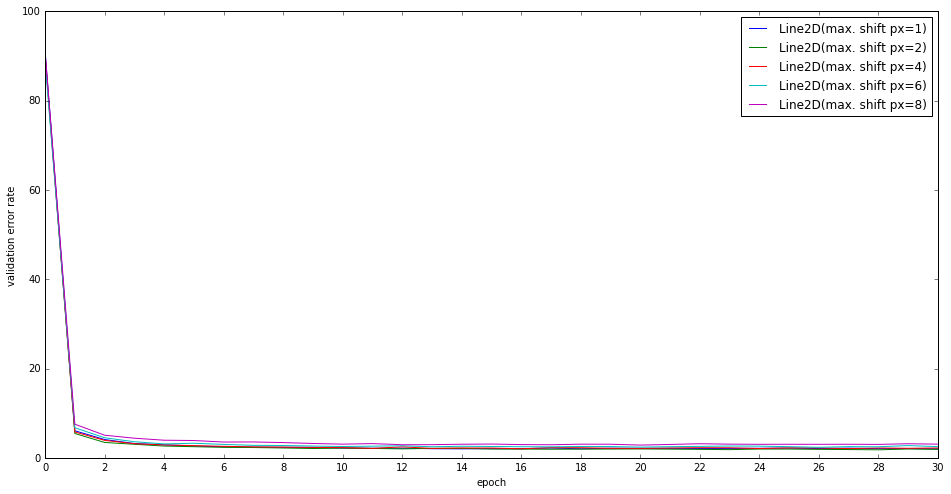

INFO:root:Testing the model max. shift px=1 on test set:
INFO:root:MNIST test set accuracy is 98.23 % (cost is 0.057)
INFO:root:Testing the model max. shift px=2 on test set:
INFO:root:MNIST test set accuracy is 98.08 % (cost is 0.059)
INFO:root:Testing the model max. shift px=4 on test set:
INFO:root:MNIST test set accuracy is 97.80 % (cost is 0.071)
INFO:root:Testing the model max. shift px=6 on test set:
INFO:root:MNIST test set accuracy is 97.49 % (cost is 0.084)
INFO:root:Testing the model max. shift px=8 on test set:
INFO:root:MNIST test set accuracy is 97.01 % (cost is 0.101)


final learning rates on the test data, with initial learning rate 0.7
model                         error rate                    
max. shift px=1               1.77                          
max. shift px=2               1.92                          
max. shift px=4               2.2                           
max. shift px=6               2.51                          
max. shift px=8               2.99                          


In [41]:
tsk4_3_tr_accrs = get_train_accuracies(tsk4_3_stats)
tsk4_3_vd_accrs = get_valid_accuracies(tsk4_3_stats)

#plotting
tsk4_3_labels = [ job["label"] for job in tsk4_3_jobs]
plot_error_rate(tsk4_3_tr_accrs, tsk4_3_vd_accrs, tsk4_3_labels,figsize=(16,8))

tsk4_3_test_stats = [test_model(job["model"], job["label"]) for job in tsk4_3_jobs]
tsk4_3_test_accrs = [test_stat[1] for test_stat in tsk4_3_test_stats ]
tsk4_3_labels = [ job["label"] for job in tsk4_3_jobs]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk4_3_test_accrs, tsk4_3_labels, padding=30)

#### Final results on the test data with the augmented dataset (100000 instances):
| Maximum shifts in pixels     | Error rate | Accuracy % |
|:-------------:|:-------------:|:-------------:|
| 1          |  1.77 | 98.23 |
| 2          |  1.92 | 98.08 |
| 4          |  2.20 | 97.80 |
| 6          |  2.51 | 97.49 |
| 8          |  2.99 | 97.01 |

Wow, the data set with max. shifts of only one pixel was able to achieve the best error rate so far 1.77 (or 98.23% accuracy)! Such result for model with only one hidden layer with 100 units. Shifts bigger than 4px don't help the learning process (their results are below of those achieved by model on standard data set). Note how vast validation error rate converges.
The great thing about this dataset that it can be applied to any other model. 

### Task 5 - State of the art (5 marks)

Using any techniques you have learnt so far (combining any number of them), build and train the best model you can (no other constraints).

I will try greedy approach here by just combining the best result achieved so far. The best for now is our standard model with 1 hidden layer with 100 hid. units but trained on the dataset which was augmented by shifts of 1px. So I want to use the best model from the course work 1 which was neural network with 1 hid. layer with 800 hid. units but train it on the augmented data set with custom scheduler (from task the best scheduler was Reciprocal with r=25 lr0=0.7 c=0.5 and learning lasted for 50 epoches)

In [42]:
from mlp.layers import MLP_fast
from mlp.schedulers import LearningRateReciprocal

def create_800_units_model():
    cost = CECost()
    model = MLP_fast(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=800, rng=rng))
    model.add_layer(Softmax(idim=800, odim=10, rng=rng))
    return model

LearningRate0 = 0.7
Num_epoches = 50
num_of_gen_data = 50000
logger.info("augmenting data")
tsk5_1_train_dp = MNISTDataProviderNoisy(dset='train', 
                                          num_of_gen_data=num_of_gen_data,
                                          noise_param=1,
                                          noise_fun=MNISTDataProviderNoisy.apply_shift,
                                          batch_size=100,
                                          max_num_batches=-10)

tsk5_1_jobs_2  = [
    {
    "model": create_800_units_model(),
    "label": "Reciprocal r=25 lr0=0.7 c=0.5",
    "lr_scheduler": LearningRateReciprocal(LearningRate0, Num_epoches, 25, 0.5),
    "train_dp": tsk5_1_train_dp
    }
]

tsk5_1_stats = get_models_statistics(tsk5_1_jobs_2)



INFO:root:augmenting data
INFO:root:Reinitialising data providers..
INFO:root:Training started Reciprocal r=25 lr0=0.7 c=0.5 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.370. Accuracy is 14.56%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.380. Accuracy is 14.15%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.596. Accuracy is 86.33%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.208. Accuracy is 93.95%
INFO:mlp.optimisers:Epoch 1: Took 44 seconds. Training speed 2339 pps. Validation speed 7897 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.216. Accuracy is 93.67%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.141. Accuracy is 95.99%
INFO:mlp.optimisers:Epoch 2: Took 44 seconds. Training speed 2366 pps. Validation speed 7951 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.150. Accuracy is 95.62%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.112. Accuracy is 96.93%
INFO:mlp.optimis

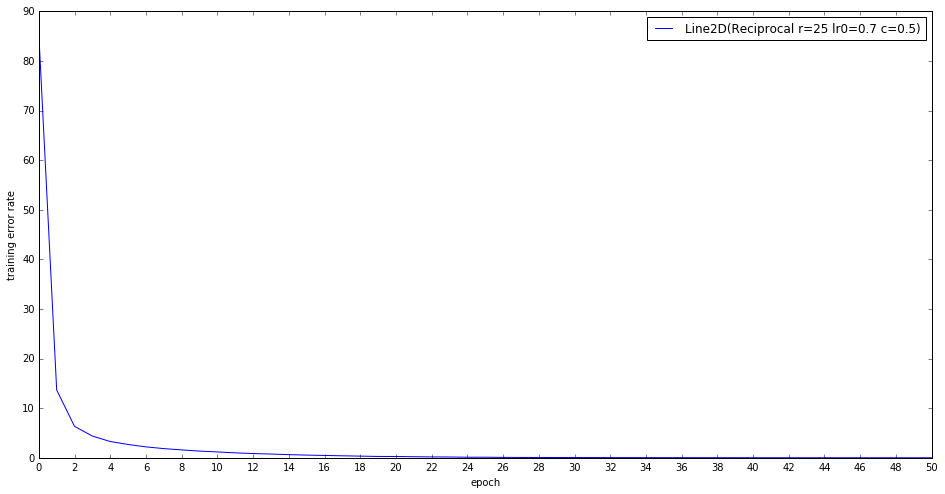

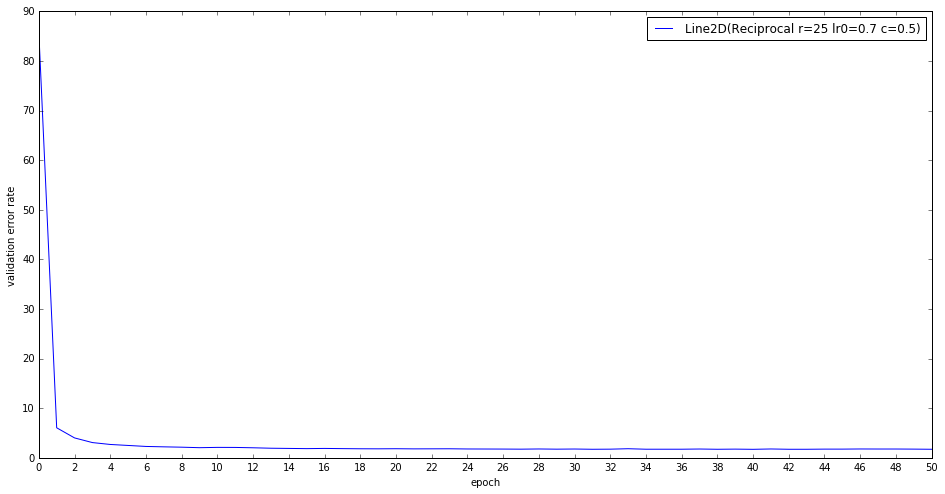

INFO:root:Testing the model Reciprocal r=25 lr0=0.7 c=0.5 on test set:
INFO:root:MNIST test set accuracy is 98.30 % (cost is 0.056)


final learning rates on the test data, with initial learning rate 0.7
model                                   error rate                              
Reciprocal r=25 lr0=0.7 c=0.5           1.7                                     


In [45]:
tsk5_1_tr_accrs = get_train_accuracies(tsk5_1_stats)
tsk5_1_vd_accrs = get_valid_accuracies(tsk5_1_stats)

#plotting
tsk5_1_labels = [ job["label"] for job in tsk5_1_jobs_2]
plot_error_rate(tsk5_1_tr_accrs, tsk5_1_vd_accrs, tsk5_1_labels,figsize=(16,8))

tsk5_1_test_stats = [test_model(job["model"], job["label"]) for job in tsk5_1_jobs_2]
tsk5_1_test_accrs = [test_stat[1] for test_stat in tsk5_1_test_stats ]
tsk5_1_labels = [ job["label"] for job in tsk5_1_jobs_2]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk5_1_test_accrs, tsk5_1_labels, padding=40)

#### Final results on the test data:
| Schedular                     | Model                  | Augmented dataset | Number of Epoches| Error rate | Accuracy %|
| ----------------------------- | ---------------------- | ----------------- |:----------:|:----------:|:--------:|  
| Reciprocal r=25 initial_learning_rate=0.7 c=0.5 | 800 hid. Sigmoid units | shifts=1px (overall training datasize = 100000) | 50 | 1.70 | 98.30 | 

It is the best result (error rate 1.7 or 98.30% accuracy) so far but it isn't huge improvement since our previous best result of 98.23% accuracy.
Let't try Relu functions but first let's see the suitable learning rates for them.

In [46]:
from mlp.layers import Relu

def create_one_relu_model():
    cost = CECost()
    model = MLP_fast(cost=cost)
    model.add_layer(Relu(idim=784, odim=100, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    return model

num_epoches = 30
learning_rates = [0.7, 0.5, 0.1, 0.05, 0.01]
tsk5_2_jobs = []
for lr in learning_rates:
    tsk5_2_jobs.append(
    {
        "model": create_one_relu_model(),
        "label": "lr={}".format(lr),
        "lr_rate": lr,
        "max_epochs": 30
    }
)

tsk5_2_stats = get_models_statistics(tsk5_2_jobs)
    

INFO:root:Reinitialising data providers..
INFO:root:Training started lr=0.7 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.323. Accuracy is 12.93%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.323. Accuracy is 13.11%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.307. Accuracy is 90.43%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.157. Accuracy is 95.57%
INFO:mlp.optimisers:Epoch 1: Took 3 seconds. Training speed 16479 pps. Validation speed 33253 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.125. Accuracy is 96.24%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.115. Accuracy is 96.69%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 16896 pps. Validation speed 39545 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.088. Accuracy is 97.31%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.092. Accuracy is 97.25%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training speed 169

In [48]:
tsk5_2_test_stats = [test_model(job["model"], job["label"]) for job in tsk5_2_jobs]
tsk5_2_test_accrs = [test_stat[1] for test_stat in tsk5_2_test_stats ]
tsk5_2_labels = [ job["label"] for job in tsk5_2_jobs]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk5_2_test_accrs, tsk5_2_labels, padding=40)

INFO:root:Testing the model lr=0.7 on test set:
INFO:root:MNIST test set accuracy is 97.96 % (cost is 0.087)
INFO:root:Testing the model lr=0.5 on test set:
INFO:root:MNIST test set accuracy is 97.99 % (cost is 0.090)
INFO:root:Testing the model lr=0.1 on test set:
INFO:root:MNIST test set accuracy is 97.54 % (cost is 0.080)
INFO:root:Testing the model lr=0.05 on test set:
INFO:root:MNIST test set accuracy is 97.05 % (cost is 0.097)
INFO:root:Testing the model lr=0.01 on test set:
INFO:root:MNIST test set accuracy is 94.09 % (cost is 0.208)


final learning rates on the test data, with initial learning rate 0.7
model                                   error rate                              
lr=0.7                                  2.04                                    
lr=0.5                                  2.01                                    
lr=0.1                                  2.46                                    
lr=0.05                                 2.95                                    
lr=0.01                                 5.91                                    


#### Final results on the test data with the fixed learning rate with Relu:
| Learning Rate      | Error rate | Accuracy % |
|:-------------:|:-------------:|:-------------:| 
| 0.70 |  2.04 | 97.96 |
| 0.50 |  2.01 | 97.99 |
| 0.10 |  2.46 | 97.54 |
| 0.05 |  2.95 | 97.05 |
| 0.01 |  5.91 | 94.09 |

From these we can see that the best learning rate is 0.5 for Relu functions. Not let's try the big one

In [49]:
def create_800_relu_model():
    cost = CECost()
    model = MLP_fast(cost=cost)
    model.add_layer(Relu(idim=784, odim=800, rng=rng))
    model.add_layer(Softmax(idim=800, odim=10, rng=rng))
    return model

#logger.info("augmenting data")
#we will the same augmented data from tsk5_1
tsk5_3_jobs  = [
    {
    "model": create_800_relu_model(),
    "label": "800 Relu units",
    "lr_rate": 0.5,
    "train_dp": tsk5_1_train_dp,
    "max_epochs": 50
    }
]

tsk5_3_stats = get_models_statistics(tsk5_3_jobs)

INFO:root:Reinitialising data providers..
INFO:root:Training started 800 Relu units ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.604. Accuracy is 9.67%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.607. Accuracy is 9.76%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.210. Accuracy is 93.85%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.090. Accuracy is 97.47%
INFO:mlp.optimisers:Epoch 1: Took 41 seconds. Training speed 2517 pps. Validation speed 9510 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.072. Accuracy is 97.90%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.086. Accuracy is 97.49%
INFO:mlp.optimisers:Epoch 2: Took 43 seconds. Training speed 2411 pps. Validation speed 7599 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.044. Accuracy is 98.73%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.071. Accuracy is 98.00%
INFO:mlp.optimisers:Epoch 3: Took 43 seconds. Training spee

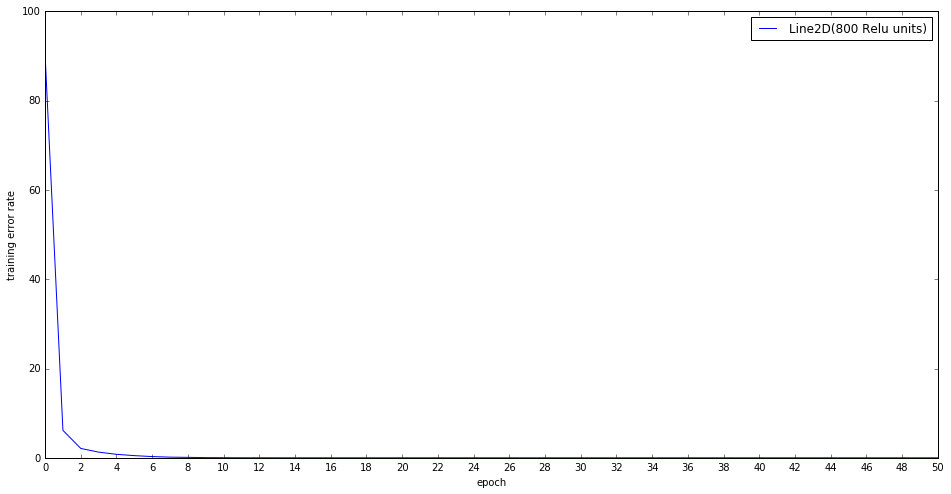

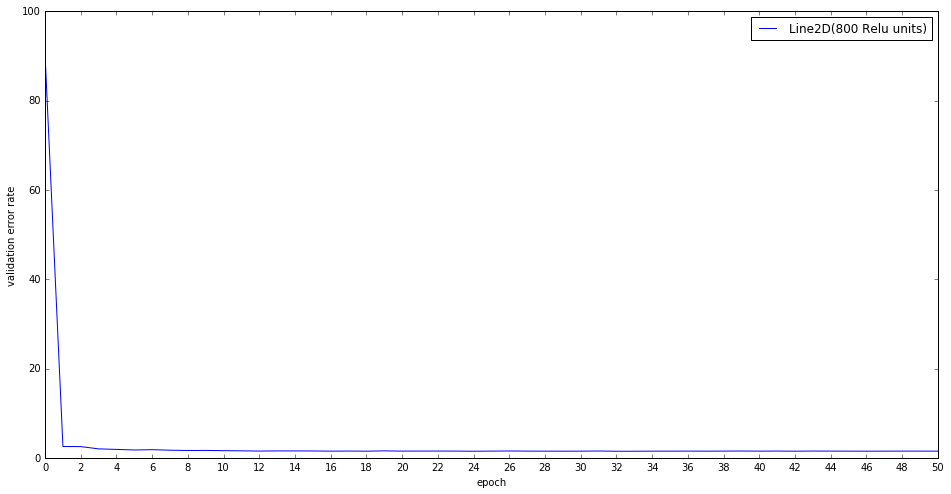

INFO:root:Testing the model 800 Relu units on test set:
INFO:root:MNIST test set accuracy is 98.66 % (cost is 0.058)


final learning rates on the test data, with initial learning rate 0.7
model                                   error rate                              
800 Relu units                          1.34                                    


In [50]:
tsk5_3_tr_accrs = get_train_accuracies(tsk5_3_stats)
tsk5_3_vd_accrs = get_valid_accuracies(tsk5_3_stats)

#plotting
tsk5_3_labels = [ job["label"] for job in tsk5_3_jobs]
plot_error_rate(tsk5_3_tr_accrs, tsk5_3_vd_accrs, tsk5_3_labels,figsize=(16,8))

tsk5_3_test_stats = [test_model(job["model"], job["label"]) for job in tsk5_3_jobs]
tsk5_3_test_accrs = [test_stat[1] for test_stat in tsk5_3_test_stats ]
tsk5_3_labels = [ job["label"] for job in tsk5_3_jobs]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk5_3_test_accrs, tsk5_3_labels, padding=40)

#### Final results on the test data:
| Schedular                    | Model               | Augmented dataset | Number of Epoches|  Error rate | Accuracy %| 
| ---------------------------- | ------------------- | ----------------- -|:-----:|:----------:|:--------:|  
| Fixed with learning_rate=0.5 | 800 hid. Relu units | shifts=1px (overall training datasize = 100000) | 50 | 1.34 | 98.66 | 

This is the best model so far with 98.66% accuracy and error rate of 1.34. But note that at some point training accuracy reached 100% which means that there probably should be some regularization. 

# Part 2. Convolutional Neural Networks (55 marks)

In this part of the coursework, you are required to implement deep convolutional networks.  This includes code for forward prop, back prop, and weight updates for convolutional and max-pooling layers, and should support the stacking of convolutional + pooling layers.  You should implement all the parts relating to the convolutional layer in the mlp/conv.py module; if you decide to implement some routines in cython, keep them in mlp/conv.pyx). Attach both files in this notebook.

Implementation tips: Look at [lecture 7](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp07-cnn.pdf) and [lecture 8](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp08-cnn2.pdf), and the introductory tutorial, [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb)

### Task 6 -  Implement convolutional layer (20 marks)

Implement linear convolutional layer, and then extend to sigmoid and ReLU transfer functions (do it in a similar way to fully-connected layers). Include all relevant code.  It is recommended that you first implement in the naive way with nested loops (python and/or cython);  optionally you may then implement in a vectorised way in numpy.  Include logs for each way you implement the convolutional layer, as timings for different implementations are of interest.  Include all relevant code.

I have implemented two matrix version of Convolutions. One is one giant 2x2 by 2x2 dot product, other one is tensor product. Note that I have implemented general version which supports custom strides.

There are a lot of doc tests (which was mentioned in the beginning) for convolution functions the most important one which was taken from paper:

Chellapilla, Kumar, Sidd Puri, and Patrice Simard.
"High performance convolutional neural networks for document processing."
Tenth International Workshop on Frontiers in Handwriting Recognition. Suvisoft, 2006.

Used in separate test as well

In [ ]:
It was especially tricky with backpropagation as you have to unroll igrads like so:
The case with kernel shape = (3,3) and strides = (2,2)
input to the layer during forward propagation has shape = (1, 1, 5, 5)
output has shape (1, 1, 2, 2) accordingly and igrad has the same shape
so igrad:
1 2
3 4

should be turned into:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 1 0 2 0 0
0 0 0 0 0 0 0
0 0 3 0 4 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0

In [9]:
# %load mlp/conv

# Machine Learning Practical (INFR11119),
# Pawel Swietojanski, University of Edinburgh

import doctest
import numpy as np
from numpy.lib.stride_tricks import as_strided as ast
import logging
from mlp.layers import Layer

logger = logging.getLogger(__name__)

"""
conv.py:
Most of the code in this section is doc tests. This is tests which are implemented in
comments/function_description and they are started with >>>.
More about this: https://docs.python.org/2/library/doctest.html
I need so many tests because I have implemented convolution via numpy matrix dot products
and numpy strides manipulations. That is why this implementation is quite fast,
but I had a lot of troubles with indices.

The test in the description for my_conv_fwd function is taken from this paper:
Chellapilla, Kumar, Sidd Puri, and Patrice Simard.
"High performance convolutional neural networks for document processing."
Tenth International Workshop on Frontiers in Handwriting Recognition. Suvisoft, 2006

IMPORTANT!!! This is implementation works with non-standard strides as well.
In order to achieve this during back propagation the igrad has to be padded not only outside
by (kernel_size - 1) but inside by (stride - 1) as well.
In case of stride (2, 2) and kernel (3,3) igrad will be padded before convolution like so:
             0 0 0 0 0 0 0
             0 0 0 0 0 0 0
  1 2  ->    0 0 1 0 2 0 0
  3 4  ->    0 0 0 0 0 0 0
             0 0 3 0 4 0 0
             0 0 0 0 0 0 0
             0 0 0 0 0 0 0

I put everything in one file because it has been said to do so in the task descripton
"""


def slide_tensor4(tensor4, window_shape, strides):
    """
    :param tensor4:  minibatch size x number of channels x image height x image width
    :param window_shape: (window_height, window_width)
    :param strides: (height_step, width_step)
    :return: tensor4 -> minibatch size x number of channels x number of windows in image x window_width * window_height

    Description:
    Slide tensor4 by window with strides step. For that it just
    changes tensor4 internal numpy stride representation so it must be very fast.
    Between window and image shape the following must be true:
    ((img_shp - window_shape) / strides) + 1 == integer
    Otherwise it is impossible to tile images equally.

    Usage/Doctests:
    Simple example 2x2 window with step 1 along each dimension.
    In 3x3 image 4 windows in total
    >>> tensor4 = np.arange(9).reshape(1, 1, 3, 3)
    >>> tensor4
    array([[[[0, 1, 2],
             [3, 4, 5],
             [6, 7, 8]]]])
    >>> slide_tensor4(tensor4, (2,2), (1,1))
    array([[[[0, 1, 3, 4],
             [1, 2, 4, 5],
             [3, 4, 6, 7],
             [4, 5, 7, 8]]]])

    >>> tensor4 = np.arange(9).reshape(1, 1, 3, 3)
    >>> tensor4
    array([[[[0, 1, 2],
             [3, 4, 5],
             [6, 7, 8]]]])
    >>> slide_tensor4(tensor4, (2,3), (1,1))
    array([[[[0, 1, 2, 3, 4, 5],
             [3, 4, 5, 6, 7, 8]]]])

    >>> tensor4 = np.arange(12).reshape(1, 1, 4, 3)
    >>> tensor4
    array([[[[ 0,  1,  2],
             [ 3,  4,  5],
             [ 6,  7,  8],
             [ 9, 10, 11]]]])
    >>> slide_tensor4(tensor4, (2,2), (2,1))
    array([[[[ 0,  1,  3,  4],
             [ 1,  2,  4,  5],
             [ 6,  7,  9, 10],
             [ 7,  8, 10, 11]]]])

    Example with windows without overlapping. 4 windows in total
    >>> tensor4 = np.arange(36).reshape(1, 1, 6, 6)
    >>> tensor4
    array([[[[ 0,  1,  2,  3,  4,  5],
             [ 6,  7,  8,  9, 10, 11],
             [12, 13, 14, 15, 16, 17],
             [18, 19, 20, 21, 22, 23],
             [24, 25, 26, 27, 28, 29],
             [30, 31, 32, 33, 34, 35]]]])
    >>> slide_tensor4(tensor4, (3,3), (3,3))
    array([[[[ 0,  1,  2,  6,  7,  8, 12, 13, 14],
             [ 3,  4,  5,  9, 10, 11, 15, 16, 17],
             [18, 19, 20, 24, 25, 26, 30, 31, 32],
             [21, 22, 23, 27, 28, 29, 33, 34, 35]]]])

    #Example with 2 images in minibatch and 2 channels
    >>> tensor4 = np.arange(36).reshape(2, 2, 3, 3)
    >>> tensor4
    array([[[[ 0,  1,  2],
             [ 3,  4,  5],
             [ 6,  7,  8]],
    <BLANKLINE>
            [[ 9, 10, 11],
             [12, 13, 14],
             [15, 16, 17]]],
    <BLANKLINE>
    <BLANKLINE>
           [[[18, 19, 20],
             [21, 22, 23],
             [24, 25, 26]],
    <BLANKLINE>
            [[27, 28, 29],
             [30, 31, 32],
             [33, 34, 35]]]])
    >>> slide_tensor4(tensor4, (2,2), (1,1))
    array([[[[ 0,  1,  3,  4],
             [ 1,  2,  4,  5],
             [ 3,  4,  6,  7],
             [ 4,  5,  7,  8]],
    <BLANKLINE>
            [[ 9, 10, 12, 13],
             [10, 11, 13, 14],
             [12, 13, 15, 16],
             [13, 14, 16, 17]]],
    <BLANKLINE>
    <BLANKLINE>
           [[[18, 19, 21, 22],
             [19, 20, 22, 23],
             [21, 22, 24, 25],
             [22, 23, 25, 26]],
    <BLANKLINE>
            [[27, 28, 30, 31],
             [28, 29, 31, 32],
             [30, 31, 33, 34],
             [31, 32, 34, 35]]]])
    """
    t4 = tensor4
    #convert to array for easy algebraic manipulations
    wd = np.array(window_shape)
    ss = np.array(strides)
    img_shp = np.array(t4.shape[2:4])

    dim_check = ((img_shp - wd) % ss)
    if dim_check[0] != 0 or dim_check[1] != 0:
        raise ValueError("impossible to tile with given strides {0}, window shape {1}, tensor4 shape {2}"\
                        .format(strides, window_shape, tensor4.shape))

    slide_shp = ((img_shp - wd) / ss) + 1
    #using tuple addition (1, 2) + (3, 4) = (1, 2, 3, 4)
    new_shp = t4.shape[0:2] + tuple(slide_shp) + tuple(wd)
    new_str = t4.strides[0:2] + tuple(np.array(t4.strides[2:4]) * ss) + t4.strides[2:4]
    #change internal memory numpy array t4 representation
    #more here: http://www.johnvinyard.com/blog/?p=268
    strided = ast(t4, shape = new_shp, strides = new_str)
    final_shape = t4.shape[0:2] +(slide_shp.prod(),) +(wd.prod(),)
    return strided.reshape(final_shape)

def slide_tensor4_2(tensor4, window_shape, strides):
    t4 = tensor4
    #convert to array for easy algebraic manipulations
    wd = np.array(window_shape)
    ss = np.array(strides)
    img_shp = np.array(t4.shape[2:4])

    dim_check = ((img_shp - wd) % ss)
    if dim_check[0] != 0 or dim_check[1] != 0:
        raise ValueError("impossible to tile with given strides {0}, window shape {1}, tensor4 shape {2}"\
                        .format(strides, window_shape, tensor4.shape))

    slide_shp = ((img_shp - wd) / ss) + 1
    #using tuple addition (1, 2) + (3, 4) = (1, 2, 3, 4)
    new_shp = t4.shape[0:2] + tuple(slide_shp) + tuple(wd)
    new_str = t4.strides[0:2] + tuple(np.array(t4.strides[2:4]) * ss) + t4.strides[2:4]
    #change internal memory numpy array t4 representation
    #more here: http://www.johnvinyard.com/blog/?p=268
    return ast(t4, shape = new_shp, strides = new_str)

def my_conv_fwd(image, kernels, strides=(1, 1)):
    """
    Description:
    Implements a 2d valid convolution of kernels with the image
    Note: filer means the same as kernel and convolution (correlation) of those with the input space
    produces feature maps (sometimes refereed to also as receptive fields). Also note, that
    feature maps are synonyms here to channels, and as such num_inp_channels == num_inp_feat_maps
    N - batch size
    C - num_in_chls
    W - image width
    H - image height
    K - num_out_chls
    S - kernel width
    R - kernel height
    Q - output width - ((W - S) / strides[0]) + 1 == integer
    P - output height - ((H - R) / strides[1]) + 1 == integer

    :param image: 4D tensor of sizes (batch_size, num_input_channels, img_shape_x, img_shape_y)
    :param kernels: 4D tensor of kernels of size (num_inp_feat_maps, num_out_feat_maps, kernel_shape_x, kernel_shape_y)
    :param strides: a tuple (stride_x, stride_y), specifying the shift of the kernels in x and y dimensions
    :return: 4D tensor of size (batch_size, num_out_feature_maps, feature_map_shape_x, feature_map_shape_y)

    Usage/Doctest:
    The test is taken from the paper:
    Chellapilla, Kumar, Sidd Puri, and Patrice Simard.
    "High performance convolutional neural networks for document processing."
    Tenth International Workshop on Frontiers in Handwriting Recognition. Suvisoft, 2006.

    >>> image = np.empty((1, 3, 3, 3), dtype=np.int64)
    >>> image[0, 0, :, :] = np.array([[1, 2, 0], [1, 1, 3], [0, 2, 2]])
    >>> image[0, 1, :, :] = np.array([[0, 2, 1], [0, 3, 2], [1, 1, 0]])
    >>> image[0, 2, :, :] = np.array([[1, 2, 1], [0, 1, 3], [3, 3, 2]])

    >>> kernel = np.empty((3, 2, 2, 2), dtype=np.int64)
    >>> kernel[0, 0, :, :] = np.array([[1, 1], [2, 2]])
    >>> kernel[1, 0, :, :] = np.array([[1, 1], [1, 1]])
    >>> kernel[2, 0, :, :] = np.array([[0, 1], [1, 0]])

    >>> kernel[0, 1, :, :] = np.array([[1, 0], [0, 1]])
    >>> kernel[1, 1, :, :] = np.array([[2, 1], [2, 1]])
    >>> kernel[2, 1, :, :] = np.array([[1, 2], [2, 0]])

    >>> img = image.swapaxes(2, 3)
    >>> krl = kernel.swapaxes(2, 3)
    >>> my_conv_fwd(img, krl)
    array([[[[14, 15],
             [20, 24]],
    <BLANKLINE>
            [[12, 17],
             [24, 26]]]])
    """
    #swaps X, Y axis due to the differences in conventions with slide_tensor4
    img = image.swapaxes(2, 3)  #N x C x H x W
    krl = kernels.swapaxes(2, 3)#C x K x R x S
    strd = strides[::-1]

    N, C, H, W = img.shape
    C, K, R, S = krl.shape

    Q = ((W - S) / strd[0]) + 1
    if (W - S) % strd[0] != 0:
        raise ValueError("impossible to tile with given stride {0}, kernel width {1}, image width {2}".\
                         format(strd[0], S, W))
    P = ((H - R) / strd[1]) + 1
    if (H - R) % strd[1] != 0:
        raise ValueError("impossible to tile with given stride {0}, kernel height {1}, image height {2}".\
                         format(strd[1], R, H))

    krl = krl.swapaxes(0, 1) #K x C x R x S
    krl = krl.reshape(K, C*R*S) #K x C*R*S
    krl = krl.swapaxes(0, 1) #C*R*S x K

    sld_img = slide_tensor4(img, (R,S), strd) # N x C x P*Q x R*S
    sld_img = sld_img.swapaxes(1, 2) # N x P*Q x C x R*S
    sld_img = sld_img.reshape(N*P*Q, C*R*S) # N*P*Q x C*R*S

    rslt = np.dot(sld_img, krl) # dot(N*P*Q x C*R*S, C*R*S x K) = N*P*Q x K
    rslt = rslt.swapaxes(0, 1) # K x N*P*Q
    rslt = rslt.reshape((K, N, P, Q)) # K x N x P x Q
    rslt = rslt.swapaxes(0, 1) # N x K x P x Q
    rslt = rslt.swapaxes(2, 3) # N x K x Q x P
    return rslt


def my_conv_fwd2(image, kernels, strides=(1, 1)):
    """
    Description:
    Implements a 2d valid convolution of kernels with the image
    Note: filer means the same as kernel and convolution (correlation) of those with the input space
    produces feature maps (sometimes refereed to also as receptive fields). Also note, that
    feature maps are synonyms here to channels, and as such num_inp_channels == num_inp_feat_maps
    N - batch size
    C - num_in_chls
    W - image width
    H - image height
    K - num_out_chls
    S - kernel width
    R - kernel height
    Q - output width - ((W - S) / strides[0]) + 1 == integer
    P - output height - ((H - R) / strides[1]) + 1 == integer

    :param image: 4D tensor of sizes (batch_size, num_input_channels, img_shape_x, img_shape_y)
    :param kernels: 4D tensor of kernels of size (num_inp_feat_maps, num_out_feat_maps, kernel_shape_x, kernel_shape_y)
    :param strides: a tuple (stride_x, stride_y), specifying the shift of the kernels in x and y dimensions
    :return: 4D tensor of size (batch_size, num_out_feature_maps, feature_map_shape_x, feature_map_shape_y)

    Usage/Doctest:
    The test is taken from the paper:
    Chellapilla, Kumar, Sidd Puri, and Patrice Simard.
    "High performance convolutional neural networks for document processing."
    Tenth International Workshop on Frontiers in Handwriting Recognition. Suvisoft, 2006.

    >>> image = np.empty((1, 3, 3, 3), dtype=np.int64)
    >>> image[0, 0, :, :] = np.array([[1, 2, 0], [1, 1, 3], [0, 2, 2]])
    >>> image[0, 1, :, :] = np.array([[0, 2, 1], [0, 3, 2], [1, 1, 0]])
    >>> image[0, 2, :, :] = np.array([[1, 2, 1], [0, 1, 3], [3, 3, 2]])

    >>> kernel = np.empty((3, 2, 2, 2), dtype=np.int64)
    >>> kernel[0, 0, :, :] = np.array([[1, 1], [2, 2]])
    >>> kernel[1, 0, :, :] = np.array([[1, 1], [1, 1]])
    >>> kernel[2, 0, :, :] = np.array([[0, 1], [1, 0]])

    >>> kernel[0, 1, :, :] = np.array([[1, 0], [0, 1]])
    >>> kernel[1, 1, :, :] = np.array([[2, 1], [2, 1]])
    >>> kernel[2, 1, :, :] = np.array([[1, 2], [2, 0]])

    >>> img = image.swapaxes(2, 3)
    >>> krl = kernel.swapaxes(2, 3)
    >>> my_conv_fwd2(img, krl)
    array([[[[14, 15],
             [20, 24]],
    <BLANKLINE>
            [[12, 17],
             [24, 26]]]])
    """
    #swaps X, Y axis due to the differences in conventions with slide_tensor4
    img = image#N x C x W x H #image.swapaxes(2, 3)  #N x C x H x W
    krl = kernels#C x K x S x R #kernels.swapaxes(2, 3)#C x K x R x S
    strd = strides# strides[::-1]

    N, C, W, H = img.shape
    C, K, S, R = krl.shape

    Q = ((W - S) / strd[0]) + 1
    if (W - S) % strd[0] != 0:
        raise ValueError("impossible to tile with given stride {0}, kernel width {1}, image width {2}".\
                         format(strd[0], S, W))
    P = ((H - R) / strd[1]) + 1
    if (H - R) % strd[1] != 0:
        raise ValueError("impossible to tile with given stride {0}, kernel height {1}, image height {2}".\
                         format(strd[1], R, H))

    #krl#C x K x S x R
    sld_img = slide_tensor4_2(img, (S,R), strd) # N x C x Q x P x S x R
    rslt = np.tensordot(sld_img, krl, axes=([1,4,5],[0,2,3])) #N x Q x P x K
    rslt = np.rollaxis(rslt, 3, 1) #N x K x Q x P
    return rslt

def my_conv_bck(igrad, kernels, strides=(1, 1)):
    """
    current layer:
    N - batch size
    C - num_in_chls #number of input channels
    W - image width
    H - image height
    K - num_out_chls
    S - kernel width
    R - kernel height
    Q - output width - ((W - S) / strides[0]) + 1 == integer
    P - output height - ((H - R) / strides[1]) + 1 == integer
    u - stride x
    v - stride y
    :param igrad: 4D tensor of sizes (N, K, Q, P)
    :param kernels: 4D tensor of  kernels of size (C, K, S, R)
    :param strides: a tuple (stride_x, stride_y), specifying the shift of the kernels in x and y dimensions
    :return: delta 4D tensor of size (N, C, W, H)

    Usage/Doctest:
    The case with kernel shape = (3,3) and strides = (2,2)
    input to the layer during forward propagation has shape = (1, 1, 5, 5)
    output has shape (1, 1, 2, 2) accordingly and igrad has the same shape
    so igrad:
    1 2
    3 4

    should be turned into:
    0 0 0 0 0 0 0
    0 0 0 0 0 0 0
    0 0 1 0 2 0 0
    0 0 0 0 0 0 0
    0 0 3 0 4 0 0
    0 0 0 0 0 0 0
    0 0 0 0 0 0 0

    for proper convolution and after that it must convolved with rotated kernels.
    The padding on the edge is to account kernel size.
    Note! The padding in between to account strides
    >>> inputs = np.arange(25).reshape(1, 1, 5, 5)
    >>> kernel = np.arange(9).reshape(1, 1, 3, 3)
    >>> igrad = np.arange(4).reshape(1, 1, 2, 2)
    >>> ograd = my_conv_bck(igrad, kernel, strides=(2, 2))
    >>> ograd.shape == inputs.shape
    True

    The case with different number of input feature maps and output feature maps
    >>> inputs = np.arange(54).reshape(3, 2, 3, 3)
    >>> kernel = np.arange(24).reshape(2, 3, 2, 2)
    >>> igrad = np.arange(36).reshape(3, 3, 2, 2)
    >>> ograd = my_conv_bck(igrad, kernel, strides=(1, 1))
    >>> ograd.shape == inputs.shape
    True
    """
    N, K, Q, P = igrad.shape
    C, K, S, R = kernels.shape
    u, v = strides
    img, krl = igrad, kernels
    #IMPORTANT! To account strides
    #In case of kernel shape (3,3), strides(2,2)
    if u > 1 or v > 1:
        tmp = np.zeros( (N, K, Q + (u - 1)*(Q - 1), P + (v - 1)*(P - 1)) )
        tmp[:,:,::u,::v]=img
        img = tmp

    img = pad_tensor4(img, (S - 1, R - 1))# (N, K, Q + (u - 1)*(Q-1) + 2*(S - 1), P + (v - 1)*(P - 1) + 2*(R - 1))
    krl = tensor4_rot180(krl)# (C, K, rot180(S, R))
    #swap here because we are going backwards
    krl = krl.swapaxes(0, 1)# (K, C, rot180(S, R))
    #strides = (1,1) not a typo!
    #The strides(u,v) have been accounted above already by tiling img with zeros in between
    return my_conv_fwd(img, krl, strides=(1,1)) #(N, C, W, H)

def my_conv_bck2(igrad, kernels, strides=(1, 1)):
    """
    current layer:
    N - batch size
    C - num_in_chls #number of input channels
    W - image width
    H - image height
    K - num_out_chls
    S - kernel width
    R - kernel height
    Q - output width - ((W - S) / strides[0]) + 1 == integer
    P - output height - ((H - R) / strides[1]) + 1 == integer
    u - stride x
    v - stride y
    :param igrad: 4D tensor of sizes (N, K, Q, P)
    :param kernels: 4D tensor of  kernels of size (C, K, S, R)
    :param strides: a tuple (stride_x, stride_y), specifying the shift of the kernels in x and y dimensions
    :return: delta 4D tensor of size (N, C, W, H)

    Usage/Doctest:
    The case with kernel shape = (3,3) and strides = (2,2)
    input to the layer during forward propagation has shape = (1, 1, 5, 5)
    output has shape (1, 1, 2, 2) accordingly and igrad has the same shape
    so igrad:
    1 2
    3 4

    should be turned into:
    0 0 0 0 0 0 0
    0 0 0 0 0 0 0
    0 0 1 0 2 0 0
    0 0 0 0 0 0 0
    0 0 3 0 4 0 0
    0 0 0 0 0 0 0
    0 0 0 0 0 0 0

    for proper convolution and after that it must convolved with rotated kernels.
    The padding on the edge is to account kernel size.
    Note! The padding in between to account strides
    >>> inputs = np.arange(25).reshape(1, 1, 5, 5)
    >>> kernel = np.arange(9).reshape(1, 1, 3, 3)
    >>> igrad = np.arange(4).reshape(1, 1, 2, 2)
    >>> ograd = my_conv_bck2(igrad, kernel, strides=(2, 2))
    >>> ograd.shape == inputs.shape
    True

    The case with different number of input feature maps and output feature maps
    >>> inputs = np.arange(54).reshape(3, 2, 3, 3)
    >>> kernel = np.arange(24).reshape(2, 3, 2, 2)
    >>> igrad = np.arange(36).reshape(3, 3, 2, 2)
    >>> ograd = my_conv_bck2(igrad, kernel, strides=(1, 1))
    >>> ograd.shape == inputs.shape
    True
    """
    N, K, Q, P = igrad.shape
    C, K, S, R = kernels.shape
    u, v = strides
    img, krl = igrad, kernels
    #IMPORTANT! To account strides
    #In case of kernel shape (3,3), strides(2,2)
    if u > 1 or v > 1:
        tmp = np.zeros( (N, K, Q + (u - 1)*(Q - 1), P + (v - 1)*(P - 1)) )
        tmp[:,:,::u,::v]=img
        img = tmp

    img = pad_tensor4(img, (S - 1, R - 1))# (N, K, Q + (u - 1)*(Q-1) + 2*(S - 1), P + (v - 1)*(P - 1) + 2*(R - 1))
    krl = tensor4_rot180(krl)# (C, K, rot180(S, R))
    #swap here because we are going backwards
    krl = krl.swapaxes(0, 1)# (K, C, rot180(S, R))
    #strides = (1,1) not a typo!
    #The strides(u,v) have been accounted above already by tiling img with zeros in between
    return my_conv_fwd2(img, krl, strides=(1,1)) #(N, C, W, H)

def my_conv_grad(inputs, deltas, strides=(1, 1)):
    """
    implementation references:
    http://ufldl.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/
    http://andrew.gibiansky.com/blog/machine-learning/convolutional-neural-networks/

    current layer:
    N - batch size
    C - num_in_chls #number of input channels
    W - image width
    H - image height
    K - num_out_chls
    S - kernel width
    R - kernel height
    Q - output width - ((W - S) / strides[0]) + 1 == integer
    P - output height - ((H - R) / strides[1]) + 1 == integer

    :inputs: tensor4 with shape -> (N, C, W, H)  #It has the same shape as input, or ograd
    :deltas: tensor4 with shape -> (N, K, Q, P)  #It has the same shape as output or igrad
    :return: tensor4 with shape -> (C, K, S, R)  #It has the same shape as kernel

    Usage/Doctest:
    Test case with non-standard strides = (2, 2)
    As we can see the derivatives of kernel has the same shape as kernel which is good
    >>> inputs = np.arange(50).reshape(1, 2, 5, 5)
    >>> kernel = np.arange(54).reshape(2, 3, 3, 3)
    >>> deltas = np.arange(12).reshape(1, 3, 2, 2)
    >>> kernel_grads = my_conv_grad(inputs, deltas, strides=(2, 2))
    >>> kernel_grads.shape == kernel.shape
    True
    """
    dlt = deltas
    #swaps X, Y axis due to the differences in conventions with slide_tensor4
    ipt = inputs.swapaxes(2, 3) #N x C x H x W
    dlt = dlt.swapaxes(2, 3) #N x K x P x Q
    strd = strides[::-1]

    N, C, H, W = ipt.shape
    N, K, P, Q = dlt.shape
    #inverse expression to get kernel width and height
    S = W - (Q - 1) * strd[0]
    R = H - (P - 1) * strd[1]

    dlt = dlt.swapaxes(0, 1) #K x N x P x Q
    dlt = dlt.reshape(K, N*P*Q) #K x N*P*Q

    sld_img = slide_tensor4(ipt, (R,S), strd) # N x C x P*Q x R*S
    sld_img = sld_img.swapaxes(1, 2) # N x P*Q x C x R*S
    sld_img = sld_img.reshape(N*P*Q, C*R*S) # N*P*Q x C*R*S

    rslt = np.dot(dlt, sld_img) #dot(K x N*P*Q, N*P*Q x C*R*S) = K x C*R*S
    rslt = rslt.reshape((K, C, R, S)) # K x C x R x S
    rslt = rslt.swapaxes(0, 1) # C x K x R x S
    rslt = rslt.swapaxes(2, 3) # C x K x S x R
    return rslt

def my_conv_grad2(inputs, deltas, strides=(1, 1)):
    """
    implementation references:
    http://ufldl.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/
    http://andrew.gibiansky.com/blog/machine-learning/convolutional-neural-networks/

    current layer:
    N - batch size
    C - num_in_chls #number of input channels
    W - image width
    H - image height
    K - num_out_chls
    S - kernel width
    R - kernel height
    Q - output width - ((W - S) / strides[0]) + 1 == integer
    P - output height - ((H - R) / strides[1]) + 1 == integer

    :inputs: tensor4 with shape -> (N, C, W, H)  #It has the same shape as input, or ograd
    :deltas: tensor4 with shape -> (N, K, Q, P)  #It has the same shape as output or igrad
    :return: tensor4 with shape -> (C, K, S, R)  #It has the same shape as kernel

    Usage/Doctest:
    Test case with non-standard strides = (2, 2)
    As we can see the derivatives of kernel has the same shape as kernel which is good
    >>> inputs = np.arange(50).reshape(1, 2, 5, 5)
    >>> kernel = np.arange(54).reshape(2, 3, 3, 3)
    >>> deltas = np.arange(12).reshape(1, 3, 2, 2)
    >>> kernel_grads = my_conv_grad2(inputs, deltas, strides=(2, 2))
    >>> kernel_grads.shape == kernel.shape
    True
    """
    dlt = deltas #N x K x Q x P
    ipt = inputs #N x C x W x H #inputs.swapaxes(2, 3) #N x C x H x W
     #dlt.swapaxes(2, 3) #N x K x P x Q
    strd = strides #strides[::-1]

    N, C, W, H = ipt.shape
    N, K, Q, P = dlt.shape
    #inverse expression to get kernel width and height
    S = W - (Q - 1) * strd[0]
    R = H - (P - 1) * strd[1]
                                                 #N x K x Q x P
    sld_img = slide_tensor4_2(ipt, (S,R), strd) # N x C x Q x P x S x R
    rslt = np.tensordot(sld_img, dlt, axes=([0,2,3],[0,2,3])) #C x S x R x K
    rslt = np.rollaxis(rslt, 3, 1) #C x K x S x R
    return rslt # C x K x S x R

def tile_bias(output_shape, bias):
    """
    :output_shape: shape of (batch_size, num_out_feature_maps, feature_map_shape_x, feature_map_shape_y)
    :bias: tensor1D of shape (num_out_feature_maps)
    :return: bias of shape (batch_size, num_out_feature_maps, feature_map_shape_x, feature_map_shape_y)

    Usage/Doctest:
    >>> b = np.array([1, 3])
    >>> output_shape = (1, 2, 3, 3)
    >>> rslt = tile_bias(output_shape, b)
    >>> rslt[:, 0, :, :]
    array([[[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]]])
    >>> rslt[:, 1, :, :]
    array([[[3, 3, 3],
            [3, 3, 3],
            [3, 3, 3]]])
    """
    return ast(bias, shape=output_shape, strides=(0, bias.strides[0], 0, 0))

def tensor4_rot180(tensor4):
    """
    C - num_in_chls #number of input channels
    K - num_out_chls
    S - kernel width
    R - kernel height

    :param tensor4: shape (C, K, S, R)
    :return: (C, K, rot180(S, R))

    Usage/Doctest:
    >>> ar = np.arange(9).reshape(1, 1, 3, 3)
    >>> ar
    array([[[[0, 1, 2],
             [3, 4, 5],
             [6, 7, 8]]]])
    >>> tensor4_rot180(ar)
    array([[[[8, 7, 6],
             [5, 4, 3],
             [2, 1, 0]]]])

    >>> ar = np.arange(18).reshape(1, 2, 3, 3)
    >>> ar
    array([[[[ 0,  1,  2],
             [ 3,  4,  5],
             [ 6,  7,  8]],
    <BLANKLINE>
            [[ 9, 10, 11],
             [12, 13, 14],
             [15, 16, 17]]]])
    >>> tensor4_rot180(ar)
    array([[[[ 8,  7,  6],
             [ 5,  4,  3],
             [ 2,  1,  0]],
    <BLANKLINE>
            [[17, 16, 15],
             [14, 13, 12],
             [11, 10,  9]]]])
    """
    t = tensor4.swapaxes(0, 2)#(S, K, C, R)
    t = t.swapaxes(1, 3)#(S, R, C, K)
    t = np.rot90(t, 2) #(rot180(S, R), C, K)
    t = t.swapaxes(0, 2)#(C, K, S, R) still rotated by 180
    t = t.swapaxes(1, 3)#(C, R, rot180(S, K))
    return t

def pad_tensor4(tensor4, pad_shape):
    """
    :param tensor4: tensor4 of shape: (batch size, num channels, width, height)
    :param pad_shape: (pad_width, pad_height)
    :return: tensor4 of shape (batch size, num channels, width + pad_width*2, height + pad_height*2)

    Usage/Doctest:
    >>> ar = np.arange(9).reshape(1, 1, 3, 3)
    >>> pad_tensor4(ar, (1,2))
    array([[[[0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 1, 2, 0, 0],
             [0, 0, 3, 4, 5, 0, 0],
             [0, 0, 6, 7, 8, 0, 0],
             [0, 0, 0, 0, 0, 0, 0]]]])
    """
    w, h = pad_shape
    return np.lib.pad(tensor4, ((0,0), (0,0), (w,w), (h,h)), 'constant', constant_values=0)

class ConvLinear(Layer):
    def __init__(self,
                 num_inp_feat_maps,
                 num_out_feat_maps,
                 image_shape=(28, 28),
                 kernel_shape=(5, 5),
                 stride=(1, 1),
                 irange=0.2,
                 rng=None,
                 conv_fwd=my_conv_fwd,
                 conv_bck=my_conv_bck,
                 conv_grad=my_conv_grad):
        """

        :param num_inp_feat_maps: int, a number of input feature maps (channels)
        :param num_out_feat_maps: int, a number of output feature maps (channels)
        :param image_shape: tuple, a shape of the image
        :param kernel_shape: tuple, a shape of the kernel
        :param stride: tuple, shift of kernels in both dimensions
        :param irange: float, initial range of the parameters
        :param rng: RandomState object, random number generator
        :param conv_fwd: handle to a convolution function used in fwd-prop
        :param conv_bck: handle to a convolution function used in backward-prop
        :param conv_grad: handle to a convolution function used in pgrads
        :return:
        """
        super(ConvLinear, self).__init__(rng=rng)

        #chls - channels
        self.inp_chls = num_inp_feat_maps
        self.out_chls = num_out_feat_maps
        self.img_shp = image_shape
        self.krl_shp = kernel_shape #krl - kernel
        self.stride = stride

        self.conv_fwd = conv_fwd
        self.conv_bck = conv_bck
        self.conv_grad = conv_grad

        self.W = self.rng.uniform(
            -irange, irange,
            (self.inp_chls, self.out_chls) + self.krl_shp)
        self.b = np.zeros((self.out_chls,), dtype=np.float32)

    def fprop(self, inputs):
        """
        kernel -> (num_in_feature_maps, num_out_feature_maps, kernel_width, kernel_height)
        feature_map_width -> (image_width - kernel_width) / strides[0] + 1
        :param inputs: (batch_size, num_in_feature_maps, image_width, image_height)
        :return: output tensor4 of size: (batch_size, num_out_feature_maps, feature_map_width, feature_map_height)
        """
        #output shape: (batch_size, num_out_feature_maps, feature_map_width, feature_map_height)
        output = self.conv_fwd(inputs, self.W, self.stride)
        return output + tile_bias(output.shape, self.b)

    def bprop(self, h, igrads, first_layer=False):
        """
        kernel -> (num_in_feature_maps, num_out_feature_maps, kernel_width, kernel_height)
        feature_map_width -> (image_width - kernel_width) / strides[0] + 1
        :param h: tensor4 of size: (batch_size, num_out_feature_maps, feature_map_width, feature_map_height)
        :param igrads: tensor4 of size: (batch_size, num_out_feature_maps, feature_map_width, feature_map_height)
        :return:
                deltas: tensor4 with shape (batch_size, num_out_feature_maps, feature_map_width, feature_map_height)
                ograds: tensor4 with shape (batch_size, num_in_feature_maps, image_width, image_width)
        """
        #input from fully connected layer

        if igrads.ndim == 2:
            igrads = igrads.reshape(h.shape)
        if first_layer:
            return  igrads, None
        ograds = self.conv_bck(igrads, self.W, self.stride)
        return igrads, ograds

    def bprop_cost(self, h, igrads, cost):
        raise NotImplementedError('ConvLinear.bprop_cost method not implemented')

    def pgrads(self, inputs, deltas, l1_weight=0, l2_weight=0):
        """
        implementation references:
        http://ufldl.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/
        http://andrew.gibiansky.com/blog/machine-learning/convolutional-neural-networks/

        current layer:
        N - batch size
        C - num_in_chls #number of input channels
        W - image width
        H - image height
        K - num_out_chls
        S - kernel width
        R - kernel height
        Q - output width - ((W - S) / strides[0]) + 1 == integer
        P - output height - ((H - R) / strides[1]) + 1 == integer

        :inputs: tensor4 with shape (N, C, W, H)
        :deltas: tensor4 with shape (N, K, Q, P)
        """
        #same code as in layers.py to account regularization
        l2_W_penalty, l2_b_penalty = 0, 0
        if l2_weight > 0:
            l2_W_penalty = l2_weight*self.W
            l2_b_penalty = l2_weight*self.b

        l1_W_penalty, l1_b_penalty = 0, 0
        if l1_weight > 0:
            l1_W_penalty = l1_weight*np.sign(self.W)
            l1_b_penalty = l1_weight*np.sign(self.b)

        W_grads = self.conv_grad(inputs, deltas, self.stride) + l1_W_penalty + l2_W_penalty
        b_grads = np.sum(deltas, axis=(0, 2, 3)) + l1_b_penalty + l2_b_penalty
        return  [W_grads, b_grads]

    def get_params(self):
        return [self.W, self.b]

    def set_params(self, params):
        self.W = params[0]
        self.b = params[1]

    def get_name(self):
        return 'convlinear'


class ConvSigmoid(ConvLinear):
    def __init__(self,
                 num_inp_feat_maps,
                 num_out_feat_maps,
                 image_shape=(28, 28),
                 kernel_shape=(5, 5),
                 stride=(1, 1),
                 irange=0.2,
                 rng=None,
                 conv_fwd=my_conv_fwd,
                 conv_bck=my_conv_bck,
                 conv_grad=my_conv_grad):

        super(ConvSigmoid, self).__init__(num_inp_feat_maps = num_inp_feat_maps,
                                         num_out_feat_maps = num_out_feat_maps,
                                         image_shape = image_shape,
                                         kernel_shape = kernel_shape,
                                         stride = stride,
                                         irange = irange,
                                         rng = rng,
                                         conv_fwd = conv_fwd,
                                         conv_bck = conv_bck,
                                         conv_grad = conv_grad)

    def fprop(self, inputs):
        #identical to Sigmoid implementation in layers.py
        a = super(ConvSigmoid, self).fprop(inputs)
        np.clip(a, -30.0, 30.0, out=a)
        h = 1.0/(1.0 + np.exp(-a))
        return h

    def bprop(self, h, igrads, first_layer=False):
        #identical to Sigmoid implementation in layers.py
        #input from fully connected layer
        if igrads.ndim == 2:
            igrads = igrads.reshape(h.shape)
        dsigm = h * (1.0 - h)
        deltas = igrads * dsigm
        ___, ograds = super(ConvSigmoid, self).bprop(h=None, igrads=deltas, first_layer=first_layer)
        return deltas, ograds

    def bprop_cost(self, h, igrads, cost):
        raise NotImplementedError('ConvSigmoid.bprop_cost method not implemented')

    def get_name(self):
        return 'convsigmoid'


class ConvRelu(ConvLinear):
    def __init__(self,
                 num_inp_feat_maps,
                 num_out_feat_maps,
                 image_shape=(28, 28),
                 kernel_shape=(5, 5),
                 stride=(1, 1),
                 irange=0.2,
                 rng=None,
                 conv_fwd=my_conv_fwd,
                 conv_bck=my_conv_bck,
                 conv_grad=my_conv_grad):

        super(ConvRelu, self).__init__(num_inp_feat_maps = num_inp_feat_maps,
                                         num_out_feat_maps = num_out_feat_maps,
                                         image_shape = image_shape,
                                         kernel_shape = kernel_shape,
                                         stride = stride,
                                         irange = irange,
                                         rng = rng,
                                         conv_fwd = conv_fwd,
                                         conv_bck = conv_bck,
                                         conv_grad = conv_grad)

    def fprop(self, inputs):
        #identical to Relu implementation in layers.py
        a = super(ConvRelu, self).fprop(inputs)
        h = np.clip(a, 0, 20.0)
        return h

    def bprop(self, h, igrads, first_layer=False):
        #identical to Relu implementation in layers.py
        #input from fully connected layer
        if igrads.ndim == 2:
            igrads = igrads.reshape(h.shape)
        deltas = (h > 0)*igrads
        ___, ograds = super(ConvRelu, self).bprop(h=None, igrads=deltas, first_layer=first_layer)
        return deltas, ograds

    def bprop_cost(self, h, igrads, cost):
        raise NotImplementedError('ConvRelu.bprop_cost method not implemented')

    def get_name(self):
        return 'convrelu'


Here are my additional tests for convolutions. 
There is test near the end for non-standard strides = (2,2). 
The test from the paper for forward propagation is in the end. 
There is also time comparison between tensor product and dot product where simple forward propagation is launched for 100000 times. 

In [63]:
# %load my_conv_tests
# %load my_conv_tests.py
import numpy
import time
from mlp.utils import test_conv_linear_fprop
from mlp.utils import test_conv_linear_bprop
from mlp.utils import test_conv_linear_pgrads
from mlp.utils import verify_layer_gradient


#Linear layer basic tests:
#put 0, 0 because tests will put W, b internally

#Test forward propagation
layer = ConvLinear(0, 0)
test_conv_linear_fprop(layer)

#Test backward propagation
layer = ConvLinear(0, 0)
test_conv_linear_bprop(layer)

#Test gradients
layer = ConvLinear(0, 0)
test_conv_linear_pgrads(layer)

#Test forward propagation for 2 version of convolution
#conv_fwd=my_conv_fwd,
#conv_bck=my_conv_bck,
#conv_grad=my_conv_grad
layer = ConvLinear(0, 0, conv_fwd=my_conv_fwd2, conv_bck=my_conv_bck2, conv_grad=my_conv_grad2)
test_conv_linear_fprop(layer)

#Test backward propagation for 2 version of convolution
layer = ConvLinear(0, 0, conv_fwd=my_conv_fwd2, conv_bck=my_conv_bck2, conv_grad=my_conv_grad2)
test_conv_linear_bprop(layer)

#Test gradients for 2 version of convolution
layer = ConvLinear(0, 0, conv_fwd=my_conv_fwd2, conv_bck=my_conv_bck2, conv_grad=my_conv_grad2)
test_conv_linear_pgrads(layer)

#Gradient tests

#Test linear layer with non-standard strides (2, 2)
inputs = numpy.arange(128).reshape((4, 2, 4, 4)).astype(numpy.float)
convlinear = ConvLinear(num_inp_feat_maps = 2,
                   num_out_feat_maps = 2,
                   image_shape = (4,4),
                   kernel_shape = (2,2),
                   stride = (2,2))
verify_layer_gradient(convlinear, inputs)

#Test ConvSigmoid gradients
inputs = numpy.arange(128).reshape((4, 2, 4, 4)).astype(numpy.float)
#scalling because exponent of 128 it is just too large
inputs /= 32
convsigmoid = ConvSigmoid(num_inp_feat_maps = 2,
                   num_out_feat_maps = 2,
                   image_shape = (4,4),
                   kernel_shape = (2,2),
                   stride = (2,2))
verify_layer_gradient(convsigmoid, inputs)


#Test ConvRelu gradients
inputs = numpy.arange(128).reshape((4, 2, 4, 4)).astype(numpy.float)
convrelu = ConvRelu(num_inp_feat_maps = 2,
                   num_out_feat_maps = 2,
                   image_shape = (4,4),
                   kernel_shape = (2,2),
                   stride = (2,2))
verify_layer_gradient(convrelu, inputs)


#test for non-standard strides (2,2)
krl = numpy.ones((1,1,2,2))
img = numpy.ones((1,1,4,4))
correct_output_img = numpy.array([[[[4, 4],
                                    [4, 4]]]])
layer = ConvLinear(num_inp_feat_maps = 1,
                   num_out_feat_maps = 1,
                   image_shape=(4, 4),
                   kernel_shape=(2, 2),
                   stride=(2,2))
layer.set_params([krl, numpy.array([0, 0])])
assert (layer.fprop(img) == correct_output_img).all()

#The test is taken from the paper:
#Chellapilla, Kumar, Sidd Puri, and Patrice Simard.
#"High performance convolutional neural networks for document processing."
#Tenth International Workshop on Frontiers in Handwriting Recognition. Suvisoft, 2006.

image = numpy.empty((1, 3, 3, 3), dtype=numpy.int64)
image[0, 0, :, :] = numpy.array([[1, 2, 0], [1, 1, 3], [0, 2, 2]])
image[0, 1, :, :] = numpy.array([[0, 2, 1], [0, 3, 2], [1, 1, 0]])
image[0, 2, :, :] = numpy.array([[1, 2, 1], [0, 1, 3], [3, 3, 2]])

kernel = numpy.empty((3, 2, 2, 2), dtype=numpy.int64)
kernel[0, 0, :, :] = numpy.array([[1, 1], [2, 2]])
kernel[1, 0, :, :] = numpy.array([[1, 1], [1, 1]])
kernel[2, 0, :, :] = numpy.array([[0, 1], [1, 0]])

kernel[0, 1, :, :] = numpy.array([[1, 0], [0, 1]])
kernel[1, 1, :, :] = numpy.array([[2, 1], [2, 1]])
kernel[2, 1, :, :] = numpy.array([[1, 2], [2, 0]])

img = image.swapaxes(2, 3)
krl = kernel.swapaxes(2, 3)
layer = ConvLinear(num_inp_feat_maps = 3,
                   num_out_feat_maps = 2,
                   image_shape=(3, 3),
                   kernel_shape=(2, 2))
layer.set_params([krl, numpy.array([0, 0])])
correct_output_img = numpy.array([[[[14, 15],
                                    [20, 24]],
                                   [[12, 17],
                                    [24, 26]]]])

assert (layer.fprop(img) == correct_output_img).all()

N = 100000

tstart = time.clock()
for i in xrange(N):
    layer.fprop(img)
tstop = time.clock()
print "2x2 by 2x2 matrices convolutions (my_conv_fwd) {0}".format(tstop - tstart)

layer = ConvLinear(num_inp_feat_maps = 3,
                   num_out_feat_maps = 2,
                   image_shape=(3, 3),
                   kernel_shape=(2, 2),
                   conv_fwd=my_conv_fwd2,
                   conv_bck=my_conv_bck2,
                   conv_grad=my_conv_grad2)

layer.set_params([krl, numpy.array([0, 0])])

tstart = time.clock()
for i in xrange(N):
    layer.fprop(img)
tstop = time.clock()
print "tensor product convolutions (my_conv_fwd2) {0}".format(tstop - tstart)



2x2 by 2x2 matrices convolutions (my_conv_fwd) 7.18856
tensor product convolutions (my_conv_fwd2) 7.735887


Note however, that although on this tiny example 2x2 by 2x2 matrices convolutions (my_conv_fwd) showed better results in the experiments in task 8 I have slightly better results with tensor product. Probably because using my_conv_fwd includes a lot of arrays reshaping and it does not always lead to just view creation (sometimes if the data alignment is chaning numpy will copy entire array and this is slow).    
Additional time comparison is given in the beginning of task 8!

### Task 7 - Implement max-pooling layer (10 marks)

Implement a max-pooling layer. Non-overlapping pooling (which was assumed in the lecture presentation) is required. You may also implement a more generic solution with striding as well. Include all relevant code.

I have implemented the general version of max-pooling (support custom strides values). One is based on matrix manipulations and other one is using cython. The matrix version is way slower than cython version. It is hard to show this on some limited example, but due to my experiments in part 8 I know that Cython for max-pooling is much faster

In [11]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [13]:
%%cython
from __future__ import division
import numpy as np
import cython
cimport numpy as np


ctypedef Py_ssize_t uint
DTYPE = np.float32
ctypedef np.float32_t DTYPE_t


@cython.boundscheck(False)
@cython.wraparound(False)
def pool_max_cython(np.ndarray[DTYPE_t, ndim=4] imgs,
              np.ndarray[DTYPE_t, ndim=4] imgs_out,
              np.ndarray[np.int_t, ndim=5] memo,
              uint wnd_w, uint wnd_h, uint stride_x, uint stride_y):
    """
    Max Pooling
    Based on the https://github.com/andersbll/nnet/blob/master/nnet/convnet/conv.pyx
    Note that my implementation accounts custom striding. I count pool window completely
    differently
    imgs has shape (num_imgs, num_chls, img_w, img_h)
    imgs_out has shape (num_imgs, num_chls, (img_w - pool_w) // stride_x + 1 , (img_h - pool_h) // stride_y + 1)
    memo has shape (num_imgs, n_chls, (img_w - pool_w) // stride_x + 1, (img_h - pool_h) // stride_y + 1,  2)
    """

    cdef uint num_imgs = imgs.shape[0]
    cdef uint num_chls = imgs.shape[1]
    cdef uint img_w = imgs.shape[2]
    cdef uint img_h = imgs.shape[3]

    cdef uint out_w = (img_w - wnd_w) // stride_x + 1
    cdef uint out_h = (img_h - wnd_h) // stride_y + 1

    if (img_w - wnd_w) % stride_x != 0:
        raise ValueError('Impossible to tile along width.')
    if (img_h - wnd_h) % stride_y != 0:
        raise ValueError('Impossible to tile along height.')
    if not num_imgs == imgs_out.shape[0] == memo.shape[0]:
        raise ValueError('Number of images is not correct. {} {} {}'.format(num_imgs, imgs_out.shape[0], memo.shape[0]))
    if not num_chls == imgs_out.shape[1] == memo.shape[1]:
        raise ValueError('Number of channels is not correct. {} {} {}'.format(num_chls, imgs_out.shape[1], memo.shape[1]))
    if not (out_h == imgs_out.shape[2] == memo.shape[2] and out_w == imgs_out.shape[3] == memo.shape[3]):
        raise ValueError('Image shape is not correct. {}, {}, {}'.format(out_h, imgs_out.shape[2], memo.shape[2]))
    if not memo.shape[4] == 2:
        raise ValueError('Memo last axe is not correct. Must store max coordinates')

    #inp - input, wnd - window
    cdef uint i, c, y_inp, x_inp, y_out, x_out, wnd_x, wnd_y, pool_x, pool_y
    cdef uint img_y_max = 0
    cdef uint img_x_max = 0
    cdef DTYPE_t max_value = 0.0
    cdef DTYPE_t new_value =0.0

    for i in range(num_imgs):
        for c in range(num_chls):
            for x_out in range(out_w):
                wnd_x = x_out * stride_x
                for y_out in range(out_h):
                    wnd_y = y_out * stride_y
                    max_value = -1e30
                    for pool_x in range(wnd_w):
                        x_inp = wnd_x + pool_x
                        for pool_y in range(wnd_h):
                            y_inp = wnd_y + pool_y
                            new_value = imgs[i, c, x_inp, y_inp]
                            if new_value > max_value:
                                max_value = new_value
                                img_x_max = x_inp
                                img_y_max = y_inp
                    imgs_out[i, c, x_out, y_out] = max_value
                    memo[i, c, x_out, y_out, 0] = img_x_max
                    memo[i, c, x_out, y_out, 1] = img_y_max

#bp - back propagating

@cython.boundscheck(False)
@cython.wraparound(False)
def pool_max_cython_bp(np.ndarray[DTYPE_t, ndim=4] igrads,
                    np.ndarray[np.int_t, ndim=5] memo,
                    np.ndarray[DTYPE_t, ndim=4] ograds):

    cdef uint num_imgs = igrads.shape[0]
    cdef uint num_chls = igrads.shape[1]
    cdef uint igrads_w = igrads.shape[2]
    cdef uint igrads_h = igrads.shape[3]

    cdef uint i, c, y, x, img_y, img_x

    ograds[...] = 0
    for i in range(num_imgs):
        for c in range(num_chls):
            for x in range(igrads_w):
                for y in range(igrads_h):
                    img_x = memo[i, c, x, y, 0]
                    img_y = memo[i, c, x, y, 1]
                    #here was the bug in the orignal code
                    ograds[i, c, img_x, img_y] += igrads[i, c, x, y]

In [14]:
# %load mlp/maxpooling.py
import numpy as np
from mlp.conv import slide_tensor4
from mlp.layers import max_and_argmax, Layer
#from mlp.pool import pool_bc01, bprop_pool_bc01
import doctest

def pool_max(tensor4, window_shape, strides, prev_arg_max = None):
    """
    N - batch size
    C - num_in_chls
    W - image width
    H - image height
    S - window width
    R - window height
    Q - output width - ((W - S) / strides[0]) + 1 == integer
    P - output height - ((H - R) / strides[1]) + 1 == integer
    u - stride x
    v - stride y
    :param tensor4:
    :param window_shape:
    :param strides:
    :return: (max_h of shape -> N x C x Q x P, indices of max values)

    Usage/Doctests
    non-overlapping example:
    >>> inputs = np.arange(16).reshape(1, 1, 4, 4)
    >>> inputs
    array([[[[ 0,  1,  2,  3],
             [ 4,  5,  6,  7],
             [ 8,  9, 10, 11],
             [12, 13, 14, 15]]]])
    >>> window = (2, 2)
    >>> stride = (2, 2)
    >>> max_h, arg_max = pool_max(inputs, window, stride)
    >>> max_h
    array([[[[ 5,  7],
             [13, 15]]]])

    #testing arg_max by propagating our output max_h backwards
    >>> G_mat = np.zeros((inputs.shape[0],inputs.shape[1],max_h.shape[2]*max_h.shape[3], inputs.shape[2]*inputs.shape[3]))
    >>> G_mat[arg_max[0], arg_max[1], arg_max[2], arg_max[3]] = 1
    >>> G_mat = G_mat.swapaxes(3, 2)
    >>> rslt = np.einsum('ijkl,ijl->ijk', G_mat, max_h.reshape(inputs.shape[0], inputs.shape[1], -1))
    >>> rslt.reshape(inputs.shape)
    array([[[[  0.,   0.,   0.,   0.],
             [  0.,   5.,   0.,   7.],
             [  0.,   0.,   0.,   0.],
             [  0.,  13.,   0.,  15.]]]])

    Overlapping test case:
    >>> inputs = np.arange(9).reshape(1, 1, 3, 3)

    #this results in errors summation during backward propagation
    >>> inputs[0, 0, 1, 2] = 45
    >>> inputs
    array([[[[ 0,  1,  2],
             [ 3,  4, 45],
             [ 6,  7,  8]]]])
    >>> window = (2, 2)
    >>> stride = (1, 1) #results in overlapping windows
    >>> max_h, arg_max = pool_max(inputs, window, stride)
    >>> max_h
    array([[[[ 4, 45],
             [ 7, 45]]]])

    #testing arg_max by propagating our output max_h backwards
    >>> G_mat = np.zeros((inputs.shape[0],inputs.shape[1],max_h.shape[2]*max_h.shape[3], inputs.shape[2]*inputs.shape[3]))
    >>> G_mat[arg_max[0], arg_max[1], arg_max[2], arg_max[3]] = 1
    >>> G_mat = G_mat.swapaxes(3, 2)
    >>> t = np.einsum('ijkl,ijl->ijk', G_mat, max_h.reshape(inputs.shape[0], inputs.shape[1], -1))
    >>> t.reshape(inputs.shape)
    array([[[[  0.,   0.,   0.],
             [  0.,   4.,  90.],
             [  0.,   7.,   0.]]]])
    """

    t4 = tensor4 #N x C x W x H

    N, C, W, H = t4.shape
    S, R = window_shape
    u, v = strides

    Q = ((W - S) / u) + 1
    if (W - S) % u != 0:
        raise ValueError("impossible to tile with given stride {0}, kernel width {1}, image width {2}".\
                         format(u, S, W))
    P = ((H - R) / v) + 1
    if (H - R) % v != 0:
        raise ValueError("impossible to tile with given stride {0}, kernel height {1}, image height {2}".\
                         format(v, R, H))
    pam = prev_arg_max
    if pam is None:
        pam = np.zeros((4, N*C*Q*P), dtype=np.int64)
        pam[2] = np.tile(np.arange(Q*P), N*C)
        pam[1] = np.tile(np.repeat(np.arange(C), Q*P), N)
        pam[0] = np.repeat(np.arange(N), C*Q*P)

    t4_sld = slide_tensor4(t4, window_shape, strides)# N x C x Q*P x S*R
    max_h = np.amax(t4_sld, axis=3)# N x C x Q*P
    max_h = max_h.reshape(N, C, Q, P) # N x C x Q x P
    arg_max_new = np.argmax(t4_sld, axis=3) # N x C x Q*P
    arg_max_new = arg_max_new.reshape(-1)
    pam[3] = arg_max_new
    #y shift global: ((ma[2,:]%P)*v )
    #y shift inside:  ma[3,:]%R
    #x shift global: (ma[2,:]/P)*u
    #x shift inside: ma[3,:]/R
    pam[3:] =((pam[2,:]%P)*v + pam[3,:]%R) + ((pam[2,:]/P)*u+ pam[3,:]/R) * H
    return max_h, pam


class ConvMaxPool2D(Layer):
    def __init__(self,
                 num_feat_maps,
                 conv_shape,
                 pool_shape=(2, 2),
                 pool_stride=(2, 2)):
        """

        :param conv_shape: tuple, a shape of the lower convolutional feature maps output
        :param pool_shape: tuple, a shape of pooling operator
        :param pool_stride: tuple, a strides for pooling operator
        :return:
        """

        super(ConvMaxPool2D, self).__init__(rng=None)
        self.chls = num_feat_maps
        self.wd = pool_shape #windoe
        self.stride = pool_stride
        self.inp_shp = None
        self.arg_max = None
        self.out_shp = None

    def fprop(self, inputs):
        if  self.inp_shp != inputs.shape:
            self.arg_max = None
            self.inp_shp = inputs.shape

        max_h, arg_max = pool_max(inputs, self.wd, self.stride, prev_arg_max=self.arg_max)
        self.arg_max = arg_max
        self.out_shp = max_h.shape
        return max_h

    def bprop(self, h, igrads, first_layer=False):
        #input from fully connected layer
        if first_layer:
            return None, None

        if self.out_shp is None:
            self.out_shp = h.shape
        #if igrads.ndim == 2:
        #    igrads = igrads.reshape(self.out_shp)

        inp_shp = self.inp_shp
        out_shp = self.out_shp
        am = self.arg_max
        G_mat = np.zeros((inp_shp[0], inp_shp[1], inp_shp[2]*inp_shp[3], out_shp[2]*out_shp[3]))
        G_mat[am[0], am[1], am[3], am[2]] = 1

        igrads = igrads.reshape(inp_shp[0], inp_shp[1], -1)

        #slow version
        #ograds = np.zeros((inp_shp[0], inp_shp[1], inp_shp[2]*inp_shp[3]))
        #for n in xrange(inp_shp[0]):
        #    for c in xrange(inp_shp[1]):
        #        ograds[n,c,:] = np.dot(G_mat[n,c,:,:], igrads[n,c,:])

        #crazy Einstein summation convention again!
        ograds = np.einsum('ijkl,ijl->ijk', G_mat, igrads)
        return None, ograds.reshape(inp_shp)

    def bprop_cost(self, h, igrads, cost):
        raise NotImplementedError('ConvMaxPool2D.bprop_cost method not implemented')

    def get_params(self):
        return []

    def pgrads(self, inputs, deltas, **kwargs):
        return []

    def set_params(self, params):
        pass

    def get_name(self):
        return 'convmaxpool2d'

class ConvMaxPool2D_Cython(Layer):
    def __init__(self,
                 num_feat_maps,
                 conv_shape,
                 pool_shape=(2, 2),
                 pool_stride=(2, 2)):
        """

        :param conv_shape: tuple, a shape of the lower convolutional feature maps output
        :param pool_shape: tuple, a shape of pooling operator
        :param pool_stride: tuple, a strides for pooling operator
        :return:
        """

        super(ConvMaxPool2D_Cython, self).__init__(rng=None)
        self.chls = num_feat_maps
        self.wnd = pool_shape #windoe
        self.stride = pool_stride
        self.inp_shp = None
        self.out_shp = None
        self.conv_shape = conv_shape

    def fprop(self, inputs):
        if  self.inp_shp != inputs.shape:
            self.inp_shp = inputs.shape

        num_imgs, num_chls = self.inp_shp[0], self.inp_shp[1]
        img_w, img_h = self.inp_shp[2], self.inp_shp[3]
        wnd_w, wnd_h = self.wnd
        stride_x, stride_y = self.stride
        out_w = (img_w - wnd_w) / stride_x + 1
        out_h = (img_h - wnd_h) / stride_y + 1
        inputs = inputs.astype(np.float32)
        
        self.memo = np.empty((num_imgs, num_chls) + (out_w, out_h) + (2,), dtype=np.int)
        imgs_out = np.empty((num_imgs, num_chls) + (out_w, out_h)).astype(np.float32)
        #print self.wd
        #print img_w, img_h
        #print out_w, out_h
        #print self.memo.shape, poolout.shape
        pool_max_cython(inputs, imgs_out, self.memo, wnd_w, wnd_h, stride_x, stride_y)
        return imgs_out

    def bprop(self, h, igrads, first_layer=False):
        #input from fully connected layer
        if first_layer:
            return None, None
        if self.out_shp is None:
            self.out_shp = h.shape
        if igrads.ndim == 2:
            igrads = igrads.reshape(self.out_shp)
        igrads = igrads.astype(np.float32)
        ograds = np.empty((self.inp_shp), dtype=np.float32)
        pool_max_cython_bp(igrads, self.memo, ograds)
        return None, ograds

    def bprop_cost(self, h, igrads, cost):
        raise NotImplementedError('ConvMaxPool2D.bprop_cost method not implemented')

    def get_params(self):
        return []

    def pgrads(self, inputs, deltas, **kwargs):
        return []

    def set_params(self, params):
        pass

    def get_name(self):
        return 'convmaxpool2d_cython'


Here is my additional tests for max-pooling layer. Note the first test which shows that this version supports the genearal strides form. 
The gradient check for Cython version of max-pooling geneartes error in the last test case due to pricison issues, because my implementation uses floats 32. Note however that results are pretty close 0.99182129 ~= 1.0 and the solutions are in the right places.   
Additional time comparison is given in the beginning of task 8

In [64]:
# %load my_pool_tests.py
import numpy
from mlp.utils import verify_layer_gradient

#test non standard stride shapes
#here pool_shape is (2,2) but stride shape is (1,1)
inputs = numpy.array([[[[ 0,  1,  2],
                        [ 3,  4, 45],
                        [ 6,  7,  8]]]])
#results in overlapping windows
convmaxpool2d = ConvMaxPool2D(num_feat_maps=1,
                              conv_shape=(3,3),
                              pool_shape=(2,2),
                              pool_stride=(1,1))

correct_output = numpy.array([[[[ 4, 45],
                                [ 7, 45]]]])

assert (convmaxpool2d.fprop(inputs) == correct_output).all()

#Test for forward and backward pass
#note that output of the fprop is given as igrads for bprop
#for easy interpretation
inputs = numpy.array([[[[ 0,  1,  2,  3],
                        [ 4,  5,  6,  7],
                        [ 8,  9, 10, 11],
                        [12, 13, 14, 15]]]])

convmaxpool2d = ConvMaxPool2D(num_feat_maps=1,
                              conv_shape=(4,4),
                              pool_shape=(2,2),
                              pool_stride=(2,2))

correct_output = numpy.array([[[[ 5,  7],
                                [13, 15]]]])

assert (convmaxpool2d.fprop(inputs) == correct_output).all()

correct_ograds = numpy.array([[[[  0.,   0.,   0.,   0.],
                                  [  0.,   5.,   0.,   7.],
                                  [  0.,   0.,   0.,   0.],
                                  [  0.,  13.,   0.,  15.]]]])

assert (convmaxpool2d.bprop(inputs, correct_output)[1] == correct_ograds).all()

#Test maxpooling.py
inputs = numpy.arange(16).reshape((1, 1, 4, 4)).astype(numpy.float)
convmaxpool2d = ConvMaxPool2D(num_feat_maps=1,
                              conv_shape=(4,4),
                              pool_shape=(2,2),
                              pool_stride=(2,2))

verify_layer_gradient(convmaxpool2d, inputs)


inputs = numpy.arange(16).reshape((1, 1, 4, 4)).astype(numpy.float)
convmaxpool2d_cython = ConvMaxPool2D_Cython(num_feat_maps=1,
                                            conv_shape=(4,4),
                                            pool_shape=(2,2),
                                            pool_stride=(2,2))
#I am using floats so the difference is neglegitible
verify_layer_gradient(convmaxpool2d_cython, inputs)


Exception: Numerical and analytical gradients are different: [[[[ 0.          0.          0.          0.        ]
   [ 0.          0.99182129  0.          0.99182129]
   [ 0.          0.          0.          0.        ]
   [ 0.          0.99182129  0.          0.99182129]]]] != [[[[ 0.  0.  0.  0.]
   [ 0.  1.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  1.  0.  1.]]]]!

### Task 8 - Experiments with convolutional networks (25 marks)

Construct convolutional networks with a softmax output layer and a single fully connected hidden layer. Your first experiments should use one convolutional+pooling layer.  As a default use convolutional kernels of dimension 5x5 (stride 1) and pooling regions of 2x2 (stride 2, hence non-overlapping).

*  Implement and test a convolutional network with 1 feature map
*  Implement and test a convolutional network with 5 feature maps

Explore convolutional networks with two convolutional layers, by implementing, training, and evaluating a network with two convolutional+maxpooling layers with 5 feature maps in the first convolutional layer,  and 10 feature maps in the second convolutional layer.

Carry out further experiments to optimise the convolutional network architecture (you could explore kernel sizes and strides, number of feature maps, sizes and strides of pooling operator, etc. - it is up to you).

For this task I use Relu units because in the task 5 they gave the best results. But more imporatantly Relu is much easier to compute in comparison to Sigmoid (Sigmoid is based on exponents, and they have to epxanded in Taylor series which consist of many expensive multiplication in contrast to Relu with its max(0, value)).  
Let's see average time per epoch comparison for the different computational configurations of the same model during first 2 epoches.

In [15]:
#Preloading data:
logger.info('Initialising conv data providers...')
train_dp_conv = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True, conv_reshape=True)
valid_dp_conv = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-10, randomize=False, conv_reshape=True)
test_dp_conv = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False, conv_reshape=True)
logger.info('Initialising is over')

INFO:__main__:Initialising conv data providers...
INFO:__main__:Initialising is over


Lets just try different computational techniques (time comparison) for one convolution layer, one feature map. 
Note that the training data set is full (50000 training examples, batch size = 100)

In [80]:
"""
model = kwargs["model"]
label = kwargs["label"] if "label" in kwargs else "no_name"
max_epochs = kwargs["max_epochs"] if "max_epochs" in kwargs else 30
lr_rate = kwargs["lr_rate"] if "lr_rate" in kwargs  else 0.1
lr_scheduler = kwargs["lr_scheduler"] if "lr_scheduler" in kwargs else LearningRateFixed(lr_rate, max_epochs)
optimiser = kwargs["optimiser"] if "optimiser" in kwargs else None
valid_dp = kwargs["valid_dp"] if "valid_dp" in kwargs else valid_dp_flat
train_dp = kwargs["train_dp"] if "train_dp" in kwargs else train_dp_flat
save = kwargs["save"] if "save" in kwargs else False
"""
def create_tsk8_1_1_model():
    cost = CECost()
    model = MLP(cost=cost)

    model.add_layer(ConvRelu(num_inp_feat_maps=1,
                                num_out_feat_maps=1,
                                image_shape=(28,28),
                                kernel_shape=(5, 5),
                                stride=(1,1),
                                rng=rng))

    model.add_layer(ConvMaxPool2D(num_feat_maps=1,
                                  conv_shape=(24, 24),
                                  pool_shape=(2, 2),
                                  pool_stride=(2, 2) ))
    #idim, odim,
    model.add_layer(Relu(idim=12*12, odim=100, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    return model

tsk8_1_1_jobs  = [
    {
    "model": create_tsk8_1_1_model(),
    "label": "MLP container, ConvMaxPool2D (matrix version)",
    "lr_rate": 0.1,
    "train_dp": train_dp_conv,
    "valid_dp": valid_dp_conv,
    "max_epochs": 2
    }
]

tsk8_1_1_stats = get_models_statistics(tsk8_1_1_jobs)

INFO:__main__:Reinitialising data providers..
INFO:__main__:Training started MLP container, ConvMaxPool2D (matrix version) ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.303. Accuracy is 9.38%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.303. Accuracy is 9.55%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.631. Accuracy is 79.77%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.181. Accuracy is 95.04%
INFO:mlp.optimisers:Epoch 1: Took 127 seconds. Training speed 412 pps. Validation speed 1919 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.180. Accuracy is 94.55%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.133. Accuracy is 96.16%
INFO:mlp.optimisers:Epoch 2: Took 129 seconds. Training speed 406 pps. Validation speed 1614 pps.
INFO:__main__:returning result


In [81]:

def create_tsk8_1_2_model():
    cost = CECost()
    model = MLP(cost=cost)

    model.add_layer(ConvRelu(num_inp_feat_maps=1,
                                num_out_feat_maps=1,
                                image_shape=(28,28),
                                kernel_shape=(5, 5),
                                stride=(1,1),
                                rng=rng))

    model.add_layer(ConvMaxPool2D_Cython(num_feat_maps=1,
                                         conv_shape=(24, 24),
                                         pool_shape=(2, 2),
                                         pool_stride=(2, 2) ))
    #idim, odim,
    model.add_layer(Relu(idim=12*12, odim=100, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    return model

tsk8_1_2_jobs  = [
    {
    "model": create_tsk8_1_2_model(),
    "label": "MLP container, ConvMaxPool2D_Cython (Cython version)",
    "lr_rate": 0.1,
    "train_dp": train_dp_conv,
    "valid_dp": valid_dp_conv,
    "max_epochs": 2
    }
]

tsk8_1_2_stats = get_models_statistics(tsk8_1_2_jobs)

INFO:__main__:Reinitialising data providers..
INFO:__main__:Training started MLP container, ConvMaxPool2D_Cython (Cython version) ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.296. Accuracy is 11.34%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.294. Accuracy is 12.63%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.453. Accuracy is 85.90%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.174. Accuracy is 94.78%
INFO:mlp.optimisers:Epoch 1: Took 64 seconds. Training speed 835 pps. Validation speed 2194 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.177. Accuracy is 94.60%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.135. Accuracy is 95.94%
INFO:mlp.optimisers:Epoch 2: Took 63 seconds. Training speed 853 pps. Validation speed 2190 pps.
INFO:__main__:returning result


In [82]:

def create_tsk8_1_3_model():
    cost = CECost()
    model = MLP_fast(cost=cost)

    model.add_layer(ConvRelu(num_inp_feat_maps=1,
                                num_out_feat_maps=1,
                                image_shape=(28,28),
                                kernel_shape=(5, 5),
                                stride=(1,1),
                                rng=rng))

    model.add_layer(ConvMaxPool2D_Cython(num_feat_maps=1,
                                         conv_shape=(24, 24),
                                         pool_shape=(2, 2),
                                         pool_stride=(2, 2) ))
    #idim, odim,
    model.add_layer(Relu(idim=12*12, odim=100, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    return model

tsk8_1_3_jobs  = [
    {
    "model": create_tsk8_1_3_model(),
    "label": "MLP_fast container, ConvMaxPool2D_Cython (Cython version)",
    "lr_rate": 0.1,
    "train_dp": train_dp_conv,
    "valid_dp": valid_dp_conv,
    "max_epochs": 2
    }
]

tsk8_1_3_stats = get_models_statistics(tsk8_1_3_jobs)

INFO:__main__:Reinitialising data providers..
INFO:__main__:Training started MLP_fast container, ConvMaxPool2D_Cython (Cython version) ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.303. Accuracy is 8.93%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.303. Accuracy is 8.31%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.675. Accuracy is 78.33%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.199. Accuracy is 94.23%
INFO:mlp.optimisers:Epoch 1: Took 34 seconds. Training speed 1718 pps. Validation speed 2193 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.184. Accuracy is 94.41%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.140. Accuracy is 95.85%
INFO:mlp.optimisers:Epoch 2: Took 34 seconds. Training speed 1724 pps. Validation speed 2213 pps.
INFO:__main__:returning result


In [83]:
          
def create_tsk8_1_4_model():
    cost = CECost()
    model = MLP_fast(cost=cost)

    model.add_layer(ConvRelu(num_inp_feat_maps=1,
                                num_out_feat_maps=1,
                                image_shape=(28,28),
                                kernel_shape=(5, 5),
                                stride=(1,1),
                                rng=rng, 
                                conv_fwd=my_conv_fwd2, 
                                conv_bck=my_conv_bck2, 
                                conv_grad=my_conv_grad2))

    model.add_layer(ConvMaxPool2D_Cython(num_feat_maps=1,
                                         conv_shape=(24, 24),
                                         pool_shape=(2, 2),
                                         pool_stride=(2, 2) ))
    #idim, odim,
    model.add_layer(Relu(idim=12*12, odim=100, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    return model

tsk8_1_4_jobs  = [
    {
    "model": create_tsk8_1_4_model(),
    "label": "MLP_fast container, ConvMaxPool2D_Cython (Cython version), my_conv_2",
    "lr_rate": 0.1,
    "train_dp": train_dp_conv,
    "valid_dp": valid_dp_conv,
    "max_epochs": 2
    }
]

tsk8_1_4_stats = get_models_statistics(tsk8_1_4_jobs)

INFO:__main__:Reinitialising data providers..
INFO:__main__:Training started MLP_fast container, ConvMaxPool2D_Cython (Cython version), my_conv_2 ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.304. Accuracy is 7.95%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.304. Accuracy is 7.55%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.750. Accuracy is 75.26%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.189. Accuracy is 94.47%
INFO:mlp.optimisers:Epoch 1: Took 32 seconds. Training speed 1834 pps. Validation speed 2137 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.188. Accuracy is 94.09%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.149. Accuracy is 95.35%
INFO:mlp.optimisers:Epoch 2: Took 32 seconds. Training speed 1834 pps. Validation speed 2061 pps.
INFO:__main__:returning result


Let's compare different computation techniques for the model with 1 feature map, 1 convolution Relu layer, 1 max-pooling layer:       
#### Time comparison on the model with 1 feature map, 1 convolution Relu layer, 1 max-pooling layer
| Computation techniques:         | Time per epoch in seconds |
| ------------- |:-------------:| 
| MLP container, ConvMaxPool2D (matrix version), my_conv_1              | 129 |
| MLP container, ConvMaxPool2D_Cython (Cython version), my_conv_1       |  63 |
| MLP_fast container, ConvMaxPool2D_Cython (Cython version), my_conv_1  |  34 |
| MLP_fast container, ConvMaxPool2D_Cython (Cython version), my_conv_2  |  32 | 

As we can see MLP_fast (firstly mentioned in task 3 with its code, this container allows to avoid expensive ograd computations for the first layer during backpropagation (these ograds are not needed as there are no layers beneath them). I hav discussed MLP_fast implementation with professor Steve Renals) works two times faster than usual MLP container. Cython version of Max-Pooling works two-time faster in comparison to its matrix version. My_conv_2 (the tensor product) gives only minor boost in contrast to my_conv_1 (2x2 by 2x2 huge matrices multiplicaton). Due to this result for the rest of this tak I will be using MLP_fast container, my_conv_2 for Conv layers and Cython version of Max Pooling.  
Now let's run 1 feature map, 1 conv. layer, 1 max-pooling layer for the 30 epoches.  
Also note that my BLAS version utilises only 2 core, so potentially it can run even faster

In [85]:
tsk8_1_jobs  = [
    {
    "model": create_tsk8_1_4_model(),
    "label": "1 feat. map, 1 conv. layer, 1 max-pool.",
    "lr_rate": 0.1,
    "train_dp": train_dp_conv,
    "valid_dp": valid_dp_conv,
    "max_epochs": 30
    }
]

tsk8_1_stats = get_models_statistics(tsk8_1_jobs)

INFO:__main__:Reinitialising data providers..
INFO:__main__:Training started 1 feat. map, 1 conv. layer, 1 max-pool. ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.321. Accuracy is 6.72%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.320. Accuracy is 6.53%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.471. Accuracy is 85.28%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.180. Accuracy is 94.56%
INFO:mlp.optimisers:Epoch 1: Took 34 seconds. Training speed 1722 pps. Validation speed 1905 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.179. Accuracy is 94.50%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.131. Accuracy is 96.30%
INFO:mlp.optimisers:Epoch 2: Took 36 seconds. Training speed 1634 pps. Validation speed 1861 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.136. Accuracy is 95.77%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.113. Accuracy is 96.66%
INFO:mlp.optimisers:Epoch 

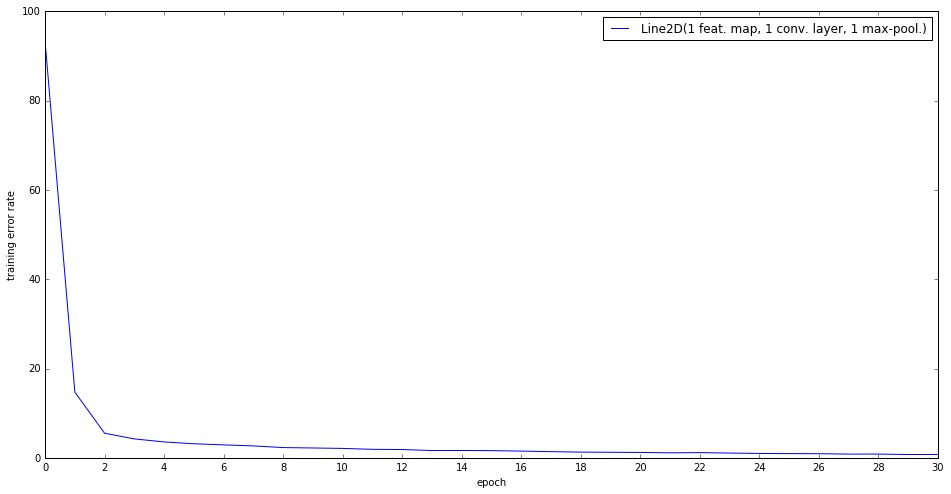

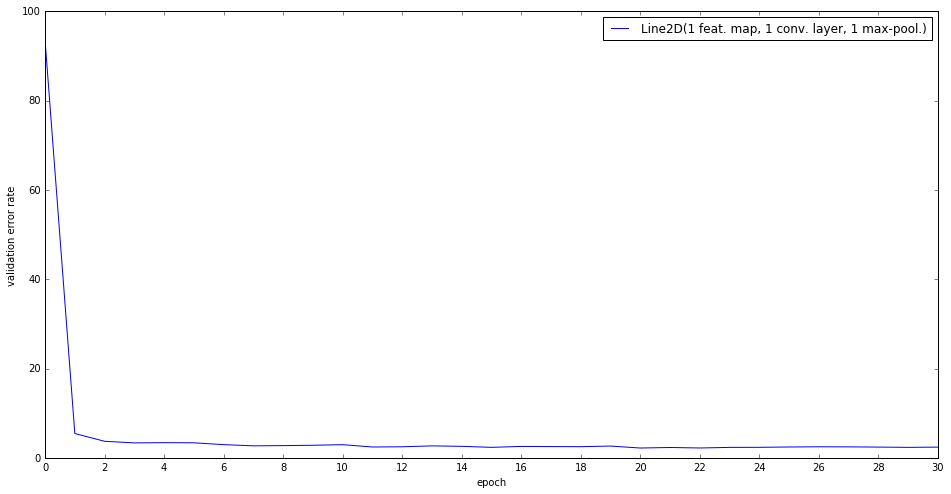

INFO:__main__:Testing the model 1 feat. map, 1 conv. layer, 1 max-pool. on test set:
INFO:__main__:MNIST test set accuracy is 97.57 % (cost is 0.099)


final learning rates on the test data, with initial learning rate 0.7
model                                         error rate                                    
1 feat. map, 1 conv. layer, 1 max-pool.       2.43                                          


In [90]:
tsk8_1_tr_accrs = get_train_accuracies(tsk8_1_stats)
tsk8_1_vd_accrs = get_valid_accuracies(tsk8_1_stats)

#plotting
tsk8_1_labels = [ job["label"] for job in tsk8_1_jobs]
plot_error_rate(tsk8_1_tr_accrs, tsk8_1_vd_accrs, tsk8_1_labels,figsize=(16,8))

test_dp_conv = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False, conv_reshape=True)
tsk8_1_test_stats = [test_model(job["model"], job["label"], test_dp=test_dp_conv) for job in tsk8_1_jobs]
tsk8_1_test_accrs = [test_stat[1] for test_stat in tsk8_1_test_stats ]
tsk8_1_labels = [ job["label"] for job in tsk8_1_jobs]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk8_1_test_accrs, tsk8_1_labels, padding=46)

#### Final results on the test data:
| Model               | Training dataset size | Number of Epoches|  Error rate | Accuracy %| 
| ------------------- |:---------------------:|:----------------:|:-----------:|:---------:| 
| 1 feat. map, 1 conv. layer, 1 max-pool. | 50000 | 30 | 2.43 | 97.57 | 

From the plots it can be seen that CNN convergence behaviour is very similar to behaviour of simple NN (on the 1st epoch error rate drops significantly). This good as it indicates that implemetation works properly. But the results of 2.43 error_rate or 97.57% accuracy is worse then those of simple model with 1 hidden layer with 100 hid. units (Sigmoid) which reached 97.78% accuracy. Maybe its because the CNN model here is too simple (convolution layer has only 5x5 + 1 = 26 parameters). Let's try 5 feature maps

In [93]:
def create_tsk8_2_model():
    cost = CECost()
    model = MLP_fast(cost=cost)

    model.add_layer(ConvRelu(num_inp_feat_maps=1,
                                num_out_feat_maps=5,
                                image_shape=(28,28),
                                kernel_shape=(5, 5),
                                stride=(1,1),
                                rng=rng, 
                                conv_fwd=my_conv_fwd2, 
                                conv_bck=my_conv_bck2, 
                                conv_grad=my_conv_grad2))

    model.add_layer(ConvMaxPool2D_Cython(num_feat_maps=5,
                                         conv_shape=(24, 24),
                                         pool_shape=(2, 2),
                                         pool_stride=(2, 2) ))
    #idim, odim,
    model.add_layer(Relu(idim=5*12*12, odim=100, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    logger.info("I created 5 feature maps! Just to be sure")
    return model

tsk8_2_jobs  = [
    {
    "model": create_tsk8_2_model(),
    "label": "5 feat. map, 1 conv. layer, 1 max-pool.",
    "lr_rate": 0.1,
    "train_dp": train_dp_conv,
    "valid_dp": valid_dp_conv,
    "max_epochs": 30
    }
]

tsk8_2_stats = get_models_statistics(tsk8_2_jobs)

INFO:__main__:I created 5 feature maps! Just to be sure
INFO:__main__:Reinitialising data providers..
INFO:__main__:Training started 5 feat. map, 1 conv. layer, 1 max-pool. ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.300. Accuracy is 11.49%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.300. Accuracy is 10.62%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.413. Accuracy is 87.44%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.194. Accuracy is 94.51%
INFO:mlp.optimisers:Epoch 1: Took 34 seconds. Training speed 1663 pps. Validation speed 2658 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.163. Accuracy is 94.98%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.120. Accuracy is 96.46%
INFO:mlp.optimisers:Epoch 2: Took 34 seconds. Training speed 1634 pps. Validation speed 2616 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.115. Accuracy is 96.40%
INFO:mlp.optimisers:Epoch 3: Validation cost (c

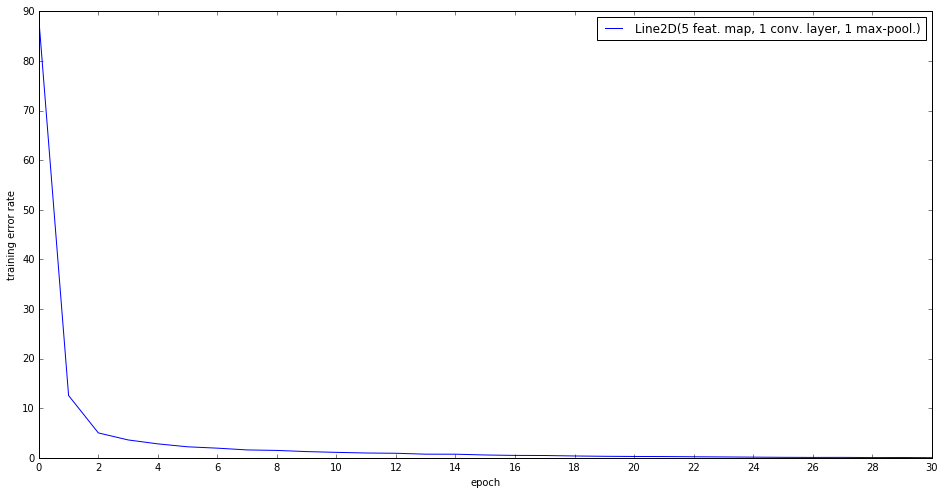

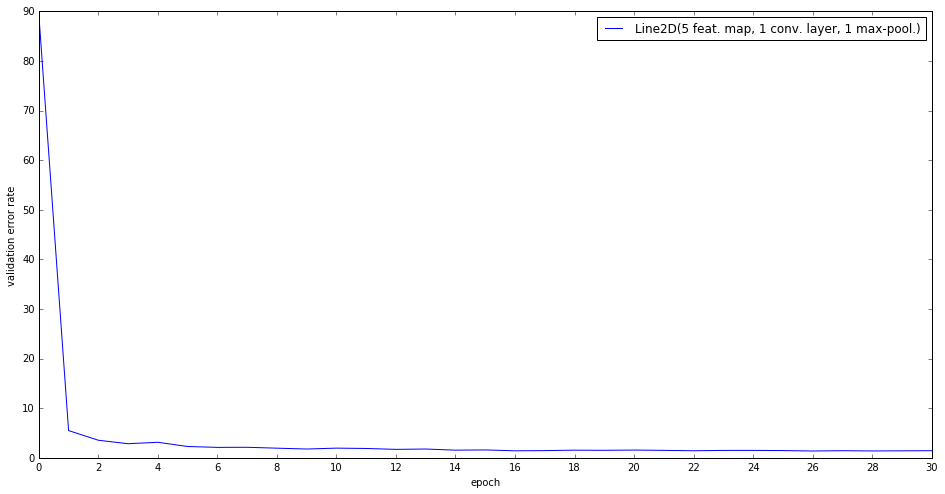

INFO:__main__:Testing the model 5 feat. map, 1 conv. layer, 1 max-pool. on test set:
INFO:__main__:MNIST test set accuracy is 98.65 % (cost is 0.054)


final learning rates on the test data, with initial learning rate 0.7
model                                         error rate                                    
5 feat. map, 1 conv. layer, 1 max-pool.       1.35                                          


In [94]:
tsk8_2_tr_accrs = get_train_accuracies(tsk8_2_stats)
tsk8_2_vd_accrs = get_valid_accuracies(tsk8_2_stats)

#plotting
tsk8_2_labels = [ job["label"] for job in tsk8_2_jobs]
plot_error_rate(tsk8_2_tr_accrs, tsk8_2_vd_accrs, tsk8_2_labels,figsize=(16,8))

test_dp_conv = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False, conv_reshape=True)
tsk8_2_test_stats = [test_model(job["model"], job["label"], test_dp=test_dp_conv) for job in tsk8_2_jobs]
tsk8_2_test_accrs = [test_stat[1] for test_stat in tsk8_2_test_stats ]
tsk8_2_labels = [ job["label"] for job in tsk8_2_jobs]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk8_2_test_accrs, tsk8_2_labels, padding=46)

#### Final results on the test data:
| Model               | Training dataset size | Number of Epoches|  Error rate | Accuracy %| 
| ------------------- |:---------------------:|:----------------:|:-----------:|:---------:| 
| 5 feat. map, 1 conv. layer, 1 max-pool. | 50000 | 30 | 1.35 | 98.65 | 

This result almost reaches our best perforamnce so far (98.66 % or error rate 1.34 in task 5). Let't try 2 conv layers

In [95]:
def create_tsk8_3_model():
    cost = CECost()
    model = MLP_fast(cost=cost)

    model.add_layer(ConvRelu(num_inp_feat_maps=1,
                                num_out_feat_maps=5,
                                image_shape=(28,28),
                                kernel_shape=(5, 5),
                                stride=(1,1),
                                rng=rng, 
                                conv_fwd=my_conv_fwd2, 
                                conv_bck=my_conv_bck2, 
                                conv_grad=my_conv_grad2))

    model.add_layer(ConvMaxPool2D_Cython(num_feat_maps=5,
                                         conv_shape=(24, 24),
                                         pool_shape=(2, 2),
                                         pool_stride=(2, 2) ))
    
    model.add_layer(ConvRelu(num_inp_feat_maps=5,
                                num_out_feat_maps=10,
                                image_shape=(12,12),
                                kernel_shape=(5, 5),
                                stride=(1,1),
                                rng=rng, 
                                conv_fwd=my_conv_fwd2, 
                                conv_bck=my_conv_bck2, 
                                conv_grad=my_conv_grad2))
    
    model.add_layer(ConvMaxPool2D_Cython(num_feat_maps=10,
                                         conv_shape=(8, 8),
                                         pool_shape=(2, 2),
                                         pool_stride=(2, 2) ))
    
    #idim, odim,
    model.add_layer(Relu(idim=10*4*4, odim=100, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    logger.info("I created 2 conv. layers network! Just to be sure")
    return model

tsk8_3_jobs  = [
    {
    "model": create_tsk8_3_model(),
    "label": "5 feat. map, 10 feat. map, 2 conv. layer, 2 max-pool.",
    "lr_rate": 0.1,
    "train_dp": train_dp_conv,
    "valid_dp": valid_dp_conv,
    "max_epochs": 30
    }
]

tsk8_3_stats = get_models_statistics(tsk8_3_jobs)

INFO:__main__:I created 2 conv. layers network! Just to be sure
INFO:__main__:Reinitialising data providers..
INFO:__main__:Training started 5 feat. map, 10 feat. map, 2 conv. layer, 2 max-pool. ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.319. Accuracy is 12.82%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.320. Accuracy is 13.17%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.484. Accuracy is 84.25%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.140. Accuracy is 95.83%
INFO:mlp.optimisers:Epoch 1: Took 78 seconds. Training speed 689 pps. Validation speed 1850 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.120. Accuracy is 96.29%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.105. Accuracy is 96.93%
INFO:mlp.optimisers:Epoch 2: Took 79 seconds. Training speed 683 pps. Validation speed 1788 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.088. Accuracy is 97.19%
INFO:mlp.optimisers:Epoch 3

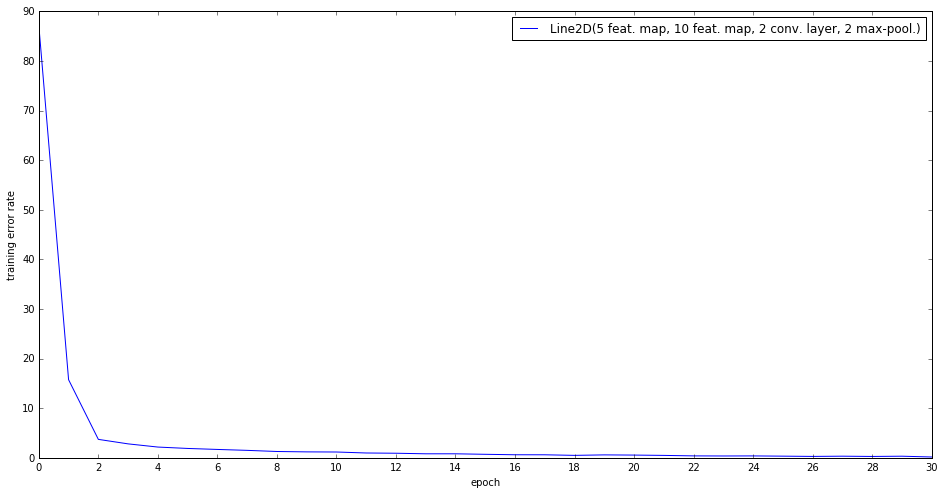

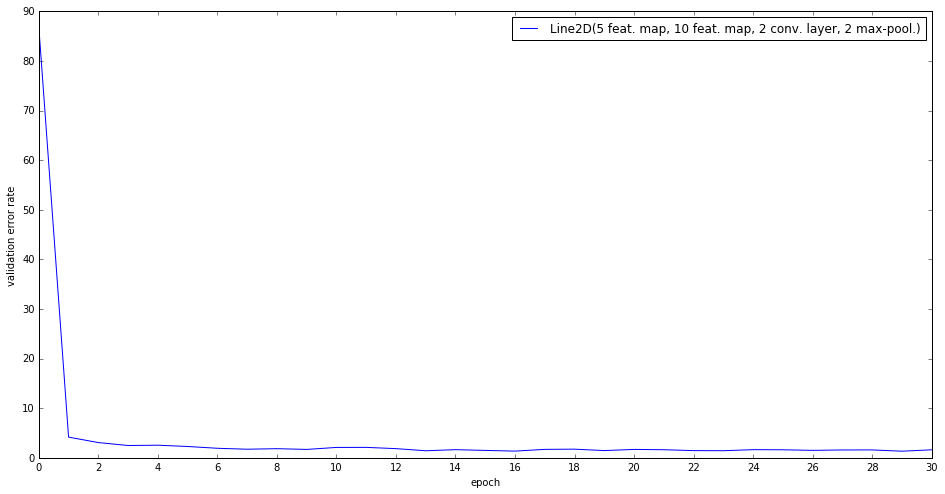

INFO:__main__:Testing the model 5 feat. map, 10 feat. map, 2 conv. layer, 2 max-pool. on test set:
INFO:__main__:MNIST test set accuracy is 98.61 % (cost is 0.062)


final learning rates on the test data, with initial learning rate 0.7
model                                                  error rate                                             
5 feat. map, 10 feat. map, 2 conv. layer, 2 max-pool.  1.39                                                   


In [96]:
tsk8_3_tr_accrs = get_train_accuracies(tsk8_3_stats)
tsk8_3_vd_accrs = get_valid_accuracies(tsk8_3_stats)

#plotting
tsk8_3_labels = [ job["label"] for job in tsk8_3_jobs]
plot_error_rate(tsk8_3_tr_accrs, tsk8_3_vd_accrs, tsk8_3_labels,figsize=(16,8))

test_dp_conv = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False, conv_reshape=True)
tsk8_3_test_stats = [test_model(job["model"], job["label"], test_dp=test_dp_conv) for job in tsk8_3_jobs]
tsk8_3_test_accrs = [test_stat[1] for test_stat in tsk8_3_test_stats ]
tsk8_3_labels = [ job["label"] for job in tsk8_3_jobs]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk8_3_test_accrs, tsk8_3_labels, padding=55)

#### Final results on the test data:
| Model               | Training dataset size | Number of Epoches|  Error rate | Accuracy %| 
| ------------------- | :--------------------:|:----------------:|:-----------:|:---------:| 
| 5 feat. map, 10 feat. map, 2 conv. layer, 2 max-pool. | 50000 | 30 |  1.39  |  98.61  | 

Well, performance of 2 conv. layer model is still high (98.61% accuracy or error rate of 1.39) but less than previous model.

As further experiments I have decided to train network on the augmented dataset from task 4 (shifting by 1px). As input for my experiment I will be using parameters adopted from   
http://neuralnetworksanddeeplearning.com/chap6.html  
I will change parameters so I have finite computation time. I will use smaller training data set (100000 instead of 250000), and lower number of feature maps: 10 and 20 (instead of 20 and 40). Also the number of epoches will be 30 instead of 60.  
These are, num of epoches 30. 10 and 20 feature maps in two Conv. Layers correspodingly and L2 regularization of 0.1

In [19]:
#reimport due to python kernel crash (I tried 20 and 40 feature maps and had some heavy problems with memory)
from mlp.layers import MLP_fast, Relu, Softmax
num_of_gen_data = 50000
lr_scheduler = LearningRateFixed(0.1, 30)
optimiser = SGDOptimiser(lr_scheduler, l2_weight=0.1)

logger.info("augmenting data")
tsk8_4_train_dp = MNISTDataProviderNoisy(dset='train', 
                                          num_of_gen_data=num_of_gen_data,
                                          noise_param=1,
                                          noise_fun=MNISTDataProviderNoisy.apply_shift,
                                          batch_size=100,
                                          max_num_batches=-10,
                                          conv_reshape=True)

def create_tsk8_4_model():
    cost = CECost()
    model = MLP_fast(cost=cost)

    model.add_layer(ConvRelu(num_inp_feat_maps=1,
                                num_out_feat_maps=10,
                                image_shape=(28,28),
                                kernel_shape=(5, 5),
                                stride=(1,1),
                                rng=rng, 
                                conv_fwd=my_conv_fwd2, 
                                conv_bck=my_conv_bck2, 
                                conv_grad=my_conv_grad2))

    model.add_layer(ConvMaxPool2D_Cython(num_feat_maps=10,
                                         conv_shape=(24, 24),
                                         pool_shape=(2, 2),
                                         pool_stride=(2, 2) ))
    
    model.add_layer(ConvRelu(num_inp_feat_maps=10,
                                num_out_feat_maps=20,
                                image_shape=(12,12),
                                kernel_shape=(5, 5),
                                stride=(1,1),
                                rng=rng, 
                                conv_fwd=my_conv_fwd2, 
                                conv_bck=my_conv_bck2, 
                                conv_grad=my_conv_grad2))
    
    model.add_layer(ConvMaxPool2D_Cython(num_feat_maps=20,
                                         conv_shape=(8, 8),
                                         pool_shape=(2, 2),
                                         pool_stride=(2, 2) ))
    
    #idim, odim,
    model.add_layer(Relu(idim=20*4*4, odim=100, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    logger.info("I created 10 and 20 feature maps! Just to be sure")
    return model

tsk8_4_jobs  = [
    {
    "model": create_tsk8_4_model(),
    "label": "10_20_feat_maps",
    "optimiser": optimiser,
    "train_dp": tsk8_4_train_dp,
    "valid_dp": valid_dp_conv,
    "save": True
    }
]

tsk8_4_stats = get_models_statistics(tsk8_4_jobs)

INFO:__main__:augmenting data
INFO:__main__:I created 10 and 20 feature maps! Just to be sure
INFO:__main__:Reinitialising data providers..
INFO:__main__:Training started 10_20_feat_maps ..
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 11.282. Accuracy is 10.22%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 11.283. Accuracy is 10.11%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 9.793. Accuracy is 92.40%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 9.622. Accuracy is 97.86%
INFO:mlp.optimisers:Epoch 1: Took 280 seconds. Training speed 368 pps. Validation speed 1135 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 8.809. Accuracy is 97.86%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 8.805. Accuracy is 98.12%
INFO:mlp.optimisers:Epoch 2: Took 290 seconds. Training speed 355 pps. Validation speed 1120 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 8.043. Accuracy is 98.39%
INFO:mlp.optimisers:Epoch 3: Va

saving data for 10_20_feat_maps


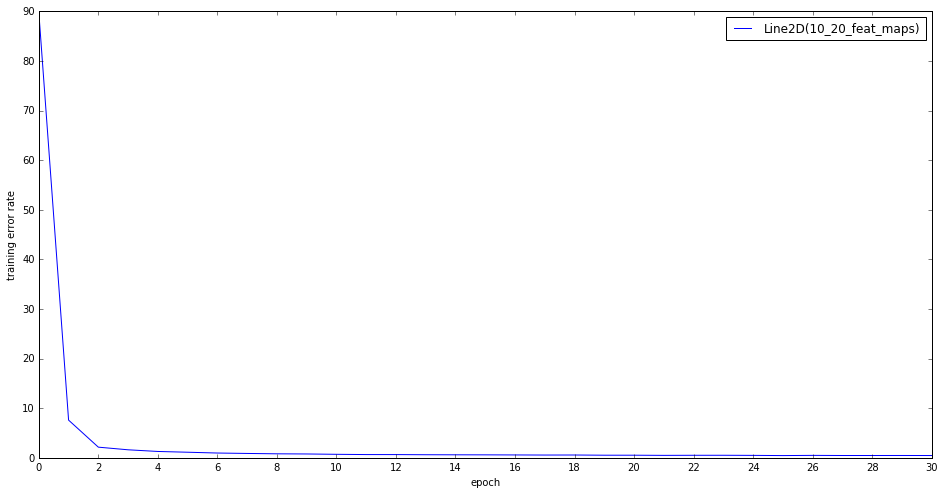

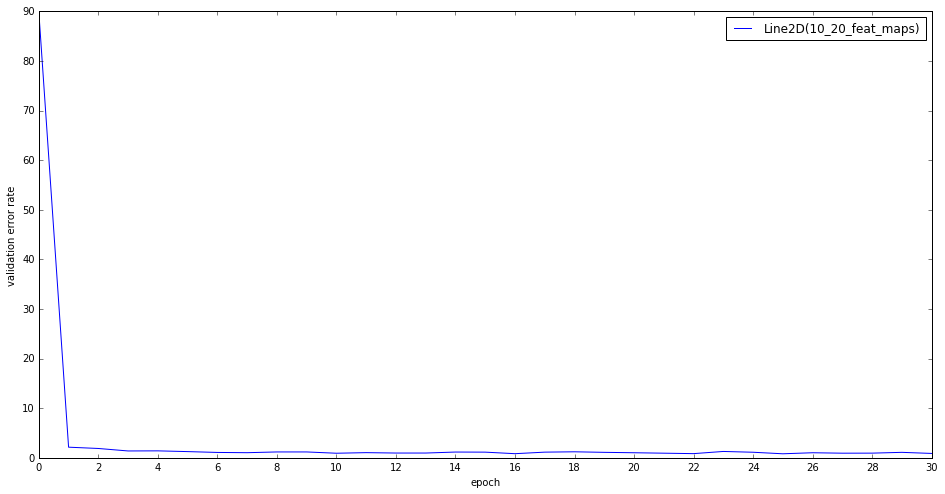

INFO:__main__:Testing the model 10_20_feat_maps on test set:
INFO:__main__:MNIST test set accuracy is 99.21 % (cost is 0.026)


final learning rates on the test data, with initial learning rate 0.7
model                                                  error rate                                             
10_20_feat_maps                                        0.79                                                   


In [20]:
tsk8_4_tr_accrs = get_train_accuracies(tsk8_4_stats)
tsk8_4_vd_accrs = get_valid_accuracies(tsk8_4_stats)

#plotting
tsk8_4_labels = [ job["label"] for job in tsk8_4_jobs]
plot_error_rate(tsk8_4_tr_accrs, tsk8_4_vd_accrs, tsk8_4_labels,figsize=(16,8))

test_dp_conv = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False, conv_reshape=True)
tsk8_4_test_stats = [test_model(job["model"], job["label"], test_dp=test_dp_conv) for job in tsk8_4_jobs]
tsk8_4_test_accrs = [test_stat[1] for test_stat in tsk8_4_test_stats ]
tsk8_4_labels = [ job["label"] for job in tsk8_4_jobs]
print "{:>16}".format("final learning rates on the test data, with initial learning rate 0.7")
print_test_error_rate(tsk8_4_test_accrs, tsk8_4_labels, padding=55)

#### Final results on the test data:
| Model            | Regularization |Augmented dataset size (shifts 1px) | Number of Epoches|  Error rate | Accuracy %| 
| ------------------- |:----------------:|:---------------------:|:----------------:|:-----------:|:---------:| 
| 10 feat. map, 20 feat. map, 2 conv. layer, 2 max-pool. | L2=0.1| 100000 | 30 |  0.79  |  99.21  | 

The accuracy is 99.21% or error rate is 0.79! This is the best model I have tried. According to the http://neuralnetworksanddeeplearning.com/chap6.html better resutls could be achieved with 250000 dataset and 20 and 40 feature maps, but in my case it takes too much time (probably if I ran it on the 4 cores instead of 2 it would be much better) and more importantly RAM. Also note that apparantely L2 regularization helped to prevent overfitting, probably one should try to find better values of L2. 

**This is the end of coursework 2.**

Please remember to save your notebook, and submit your notebook following the instructions at the top.  Please make sure that you have executed all the code cells when you submit the notebook.
